## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

# LABELS = [
#     "jalan_UL", "jalan_DR", "jalan_UR", "jalan_DL",
#     "sapu_UL", "sapu_DR", "sapu_UR", "sapu_DL",
#     # "barang_UL", "barang_DR", "barang_UR", "barang_DL",
#     # "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
#     "idle"
# ]

LABELS = np.array([
    "jalan_DR", "jalan_UR", "jalan_DL", "jalan_UL",
    "barang2_DR", "barang2_UR", "barang2_DL", "barang2_UL",
    "barang1l_DR", "barang1l_UR", "barang1l_DL", "barang1l_UL",
    "barang1r_DR", "barang1r_UR", "barang1r_DL", "barang1r_UL",
    "diam_ND"
])

# LABELS = np.array([    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ])


load = False
train = True
update = True


# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

# DATASET_PATH = "data/2a_Amplify/"

DATASET_PATH = "data/Direct2a2/Normalize/"
# DATASET_PATH = "data/Direct2/NoOverlap/NormalizeOnce/"

n_steps = 5
# n_steps = 8


X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print(training_data_count, test_data_count, n_input, n_classes)
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




31620 31620 36 17
(X shape, y shape, every X's mean, every X's standard deviation)
(31620, 5, 36) (31620, 1) 8.09652e-07 27.40669

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
#     lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)

    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1], state_is_tuple=True)

#     lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden*2, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_3 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2, lstm_cell_3], state_is_tuple=True)
    
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(17,) dtype=float32_ref>}
{'hidden': <tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>, 'out': <tf.Variable 'Variable_2:0' shape=(36, 17) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560

# training_iters = training_data_count *64
# training_iters = training_data_count *128
training_iters = training_data_count *256
# training_iters = training_data_count *512
# training_iters = training_data_count *1024
# training_iters = training_data_count *2048
# training_iters = training_data_count *3072
# training_iters = training_data_count *5120

#create saver before training
saver = tf.train.Saver()
# saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
# load = False
# train = True
# update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
if load:
    # import the inspect_checkpoint library
    from tensorflow.python.tools import inspect_checkpoint as chkp

    # print all tensors in checkpoint file
    chkp.print_tensors_in_checkpoint_file(DATASET_PATH + "model.ckpt", tensor_name='', all_tensors=True)

In [13]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 8.324282, Accuracy = 0.03125
PERFORMANCE ON TEST SET:             Batch Loss = 7.90251350402832, Accuracy = 0.08007590472698212
Iter #512:  Learning rate = 0.005000:   Batch Loss = 6.119585, Accuracy = 0.046875
PERFORMANCE ON TEST SET:             Batch Loss = 6.00091552734375, Accuracy = 0.07710310071706772
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 5.546739, Accuracy = 0.109375
PERFORMANCE ON TEST SET:             Batch Loss = 5.419408798217773, Accuracy = 0.09645793586969376
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 5.086988, Accuracy = 0.078125
PERFORMANCE ON TEST SET:             Batch Loss = 4.967002868652344, Accuracy = 0.1225806474685669
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 4.591476, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 4.748622894287109, Accuracy = 0.1598988026380539
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 4.729218, Accuracy = 0.171875
PERF

Iter #23040:  Learning rate = 0.005000:   Batch Loss = 2.904900, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.9609854221343994, Accuracy = 0.38317519426345825
Iter #23552:  Learning rate = 0.005000:   Batch Loss = 2.887393, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.964015245437622, Accuracy = 0.3780834972858429
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 2.821404, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.89839243888855, Accuracy = 0.39114484190940857
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 2.927398, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.936959743499756, Accuracy = 0.3806135356426239
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 3.159799, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.885939121246338, Accuracy = 0.4034155607223511
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 2.855488, Accuracy = 0.375
PERFO

Iter #46080:  Learning rate = 0.005000:   Batch Loss = 2.273578, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2990822792053223, Accuracy = 0.46783682703971863
Iter #46592:  Learning rate = 0.005000:   Batch Loss = 2.182051, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.2720844745635986, Accuracy = 0.4789057672023773
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.270528, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2678167819976807, Accuracy = 0.4780518710613251
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 2.236575, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.24306321144104, Accuracy = 0.4915876090526581
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 2.226929, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2429795265197754, Accuracy = 0.4895003139972687
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 2.222308, Accuracy = 0.39062

Iter #69120:  Learning rate = 0.005000:   Batch Loss = 2.002849, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9250133037567139, Accuracy = 0.5548387169837952
Iter #69632:  Learning rate = 0.005000:   Batch Loss = 1.801920, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9390645027160645, Accuracy = 0.549652099609375
Iter #70144:  Learning rate = 0.005000:   Batch Loss = 1.910089, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9187161922454834, Accuracy = 0.5517710447311401
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 1.859382, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9137053489685059, Accuracy = 0.5539848208427429
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 1.739762, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.889000654220581, Accuracy = 0.5607843399047852
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 1.747309, Accuracy = 0.625
P

Iter #92160:  Learning rate = 0.005000:   Batch Loss = 1.788293, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6477775573730469, Accuracy = 0.6338393688201904
Iter #92672:  Learning rate = 0.005000:   Batch Loss = 1.579944, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6583313941955566, Accuracy = 0.6155281662940979
Iter #93184:  Learning rate = 0.005000:   Batch Loss = 1.634199, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.642444372177124, Accuracy = 0.6366540193557739
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 1.717157, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6146302223205566, Accuracy = 0.6492409706115723
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 1.529197, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6237258911132812, Accuracy = 0.6510752439498901
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 1.529796, Accuracy = 0.78125
P

Iter #115200:  Learning rate = 0.004800:   Batch Loss = 1.326814, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.434461236000061, Accuracy = 0.702340304851532
Iter #115712:  Learning rate = 0.004800:   Batch Loss = 1.394265, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.418205976486206, Accuracy = 0.7049652338027954
Iter #116224:  Learning rate = 0.004800:   Batch Loss = 1.411616, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4294575452804565, Accuracy = 0.6958253979682922
Iter #116736:  Learning rate = 0.004800:   Batch Loss = 1.440180, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4172180891036987, Accuracy = 0.7123023271560669
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 1.346963, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4338315725326538, Accuracy = 0.7072739005088806
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 1.538038, Accuracy = 0

Iter #138240:  Learning rate = 0.004800:   Batch Loss = 1.174176, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3210117816925049, Accuracy = 0.7354838848114014
Iter #138752:  Learning rate = 0.004800:   Batch Loss = 1.381260, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3273022174835205, Accuracy = 0.7395003437995911
Iter #139264:  Learning rate = 0.004800:   Batch Loss = 1.526237, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3239524364471436, Accuracy = 0.7358633875846863
Iter #139776:  Learning rate = 0.004800:   Batch Loss = 1.381900, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.315846562385559, Accuracy = 0.7432953715324402
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 1.332493, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3609321117401123, Accuracy = 0.7191334366798401
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 1.271603, Accuracy = 0.

Iter #161280:  Learning rate = 0.004800:   Batch Loss = 1.257878, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2311612367630005, Accuracy = 0.7568943500518799
Iter #161792:  Learning rate = 0.004800:   Batch Loss = 1.150026, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.197685718536377, Accuracy = 0.7782099843025208
Iter #162304:  Learning rate = 0.004800:   Batch Loss = 1.273335, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1966744661331177, Accuracy = 0.7841556072235107
Iter #162816:  Learning rate = 0.004800:   Batch Loss = 1.316906, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2208995819091797, Accuracy = 0.7679000496864319
Iter #163328:  Learning rate = 0.004800:   Batch Loss = 1.181392, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2042741775512695, Accuracy = 0.7764706015586853
Iter #163840:  Learning rate = 0.004800:   Batch Loss = 1.118370, Accuracy

Iter #184320:  Learning rate = 0.004800:   Batch Loss = 1.075093, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1834197044372559, Accuracy = 0.7753320932388306
Iter #184832:  Learning rate = 0.004800:   Batch Loss = 1.155883, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1588550806045532, Accuracy = 0.7832068204879761
Iter #185344:  Learning rate = 0.004800:   Batch Loss = 1.050649, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1166120767593384, Accuracy = 0.8103731870651245
Iter #185856:  Learning rate = 0.004800:   Batch Loss = 1.073696, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1294852495193481, Accuracy = 0.8074319958686829
Iter #186368:  Learning rate = 0.004800:   Batch Loss = 1.122404, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1446377038955688, Accuracy = 0.795129656791687
Iter #186880:  Learning rate = 0.004800:   Batch Loss = 0.972718, Accurac

Iter #207360:  Learning rate = 0.004608:   Batch Loss = 1.042377, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0574688911437988, Accuracy = 0.8230550289154053
Iter #207872:  Learning rate = 0.004608:   Batch Loss = 1.058069, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.060795545578003, Accuracy = 0.8235926628112793
Iter #208384:  Learning rate = 0.004608:   Batch Loss = 0.949391, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.016052484512329, Accuracy = 0.8334914445877075
Iter #208896:  Learning rate = 0.004608:   Batch Loss = 1.051198, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0470242500305176, Accuracy = 0.8186274766921997
Iter #209408:  Learning rate = 0.004608:   Batch Loss = 1.084760, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0318931341171265, Accuracy = 0.8284313678741455
Iter #209920:  Learning rate = 0.004608:   Batch Loss = 1.127964, Accuracy =

Iter #230400:  Learning rate = 0.004608:   Batch Loss = 0.895320, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9304303526878357, Accuracy = 0.8645793795585632
Iter #230912:  Learning rate = 0.004608:   Batch Loss = 0.912375, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9420078992843628, Accuracy = 0.86119544506073
Iter #231424:  Learning rate = 0.004608:   Batch Loss = 1.090344, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9416871070861816, Accuracy = 0.8579696416854858
Iter #231936:  Learning rate = 0.004608:   Batch Loss = 0.952499, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9516618251800537, Accuracy = 0.8493042588233948
Iter #232448:  Learning rate = 0.004608:   Batch Loss = 0.977147, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9664008617401123, Accuracy = 0.843674898147583
Iter #232960:  Learning rate = 0.004608:   Batch Loss = 0.812391, Accuracy = 0.9

Iter #253440:  Learning rate = 0.004608:   Batch Loss = 0.934512, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8856736421585083, Accuracy = 0.8710626363754272
Iter #253952:  Learning rate = 0.004608:   Batch Loss = 0.831343, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8658488988876343, Accuracy = 0.8798229098320007
Iter #254464:  Learning rate = 0.004608:   Batch Loss = 0.866971, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8736701607704163, Accuracy = 0.8755534291267395
Iter #254976:  Learning rate = 0.004608:   Batch Loss = 0.803548, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8812078237533569, Accuracy = 0.8697026968002319
Iter #255488:  Learning rate = 0.004608:   Batch Loss = 0.946721, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8832356333732605, Accuracy = 0.8649272322654724
Iter #256000:  Learning rate = 0.004608:   Batch Loss = 0.740690, Accuracy = 

Iter #276480:  Learning rate = 0.004608:   Batch Loss = 0.873696, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8148710131645203, Accuracy = 0.8870018720626831
Iter #276992:  Learning rate = 0.004608:   Batch Loss = 0.768187, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8084900975227356, Accuracy = 0.8903225660324097
Iter #277504:  Learning rate = 0.004608:   Batch Loss = 0.922565, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8259211778640747, Accuracy = 0.881752073764801
Iter #278016:  Learning rate = 0.004608:   Batch Loss = 0.772561, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8417270183563232, Accuracy = 0.8784629702568054
Iter #278528:  Learning rate = 0.004608:   Batch Loss = 0.776021, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8286691904067993, Accuracy = 0.8821315765380859
Iter #279040:  Learning rate = 0.004608:   Batch Loss = 0.785690, Accurac

Iter #299520:  Learning rate = 0.004608:   Batch Loss = 0.628282, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7871662378311157, Accuracy = 0.893326997756958
Iter #300032:  Learning rate = 0.004424:   Batch Loss = 0.777516, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7766558527946472, Accuracy = 0.8964263200759888
Iter #300544:  Learning rate = 0.004424:   Batch Loss = 0.895656, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7719446420669556, Accuracy = 0.9019607901573181
Iter #301056:  Learning rate = 0.004424:   Batch Loss = 0.693079, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7986612915992737, Accuracy = 0.8898798227310181
Iter #301568:  Learning rate = 0.004424:   Batch Loss = 0.976085, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.824751615524292, Accuracy = 0.8787792325019836
Iter #302080:  Learning rate = 0.004424:   Batch Loss = 0.796917, Accuracy 

Iter #322560:  Learning rate = 0.004424:   Batch Loss = 0.669086, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.754625678062439, Accuracy = 0.8969639539718628
Iter #323072:  Learning rate = 0.004424:   Batch Loss = 0.766654, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7379974126815796, Accuracy = 0.9074952602386475
Iter #323584:  Learning rate = 0.004424:   Batch Loss = 0.797002, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7524325251579285, Accuracy = 0.9040480852127075
Iter #324096:  Learning rate = 0.004424:   Batch Loss = 0.729842, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7346879243850708, Accuracy = 0.9100252985954285
Iter #324608:  Learning rate = 0.004424:   Batch Loss = 0.656231, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.731897234916687, Accuracy = 0.9061669707298279
Iter #325120:  Learning rate = 0.004424:   Batch Loss = 0.691566, Accuracy = 

Iter #345600:  Learning rate = 0.004424:   Batch Loss = 0.785544, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7397466897964478, Accuracy = 0.8956356644630432
Iter #346112:  Learning rate = 0.004424:   Batch Loss = 0.801727, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7296452522277832, Accuracy = 0.9091398119926453
Iter #346624:  Learning rate = 0.004424:   Batch Loss = 0.759687, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7376580238342285, Accuracy = 0.8968690633773804
Iter #347136:  Learning rate = 0.004424:   Batch Loss = 0.712106, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7250089645385742, Accuracy = 0.8997153639793396
Iter #347648:  Learning rate = 0.004424:   Batch Loss = 0.621108, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7170716524124146, Accuracy = 0.907400369644165
Iter #348160:  Learning rate = 0.004424:   Batch Loss = 0.673493, Accuracy

Iter #368640:  Learning rate = 0.004424:   Batch Loss = 0.694116, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6953662633895874, Accuracy = 0.9120809435844421
Iter #369152:  Learning rate = 0.004424:   Batch Loss = 0.731046, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6725541949272156, Accuracy = 0.921284019947052
Iter #369664:  Learning rate = 0.004424:   Batch Loss = 0.628448, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6734249591827393, Accuracy = 0.9221062660217285
Iter #370176:  Learning rate = 0.004424:   Batch Loss = 0.705194, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6721129417419434, Accuracy = 0.918216347694397
Iter #370688:  Learning rate = 0.004424:   Batch Loss = 0.605946, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6565012335777283, Accuracy = 0.9245098233222961
Iter #371200:  Learning rate = 0.004424:   Batch Loss = 0.728046, Accuracy 

Iter #391680:  Learning rate = 0.004424:   Batch Loss = 0.700233, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6639467477798462, Accuracy = 0.9153067469596863
Iter #392192:  Learning rate = 0.004424:   Batch Loss = 0.527257, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6880934834480286, Accuracy = 0.9092662930488586
Iter #392704:  Learning rate = 0.004424:   Batch Loss = 0.759091, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6565014123916626, Accuracy = 0.9170461893081665
Iter #393216:  Learning rate = 0.004424:   Batch Loss = 0.825543, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6717488765716553, Accuracy = 0.9126185774803162
Iter #393728:  Learning rate = 0.004424:   Batch Loss = 0.552622, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6657543182373047, Accuracy = 0.9163187742233276
Iter #394240:  Learning rate = 0.004424:   Batch Loss = 0.608339, Accu

Iter #414720:  Learning rate = 0.004247:   Batch Loss = 0.485205, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.632301926612854, Accuracy = 0.9222959876060486
Iter #415232:  Learning rate = 0.004247:   Batch Loss = 0.563760, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.626250684261322, Accuracy = 0.9269766211509705
Iter #415744:  Learning rate = 0.004247:   Batch Loss = 0.572345, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6306930184364319, Accuracy = 0.9276723861694336
Iter #416256:  Learning rate = 0.004247:   Batch Loss = 0.634382, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6247351169586182, Accuracy = 0.9271979928016663
Iter #416768:  Learning rate = 0.004247:   Batch Loss = 0.561085, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6427751183509827, Accuracy = 0.920208752155304
Iter #417280:  Learning rate = 0.004247:   Batch Loss = 0.527790, Accuracy 

Iter #437760:  Learning rate = 0.004247:   Batch Loss = 0.647415, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6129636764526367, Accuracy = 0.9267551898956299
Iter #438272:  Learning rate = 0.004247:   Batch Loss = 0.643253, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6070404052734375, Accuracy = 0.9282416105270386
Iter #438784:  Learning rate = 0.004247:   Batch Loss = 0.606158, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5958073139190674, Accuracy = 0.9326059222221375
Iter #439296:  Learning rate = 0.004247:   Batch Loss = 0.604470, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5940771102905273, Accuracy = 0.9347248673439026
Iter #439808:  Learning rate = 0.004247:   Batch Loss = 0.561850, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6038932800292969, Accuracy = 0.9291271567344666
Iter #440320:  Learning rate = 0.004247:   Batch Loss = 0.550907, Accuracy 

Iter #460800:  Learning rate = 0.004247:   Batch Loss = 0.698795, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5965114235877991, Accuracy = 0.9329538345336914
Iter #461312:  Learning rate = 0.004247:   Batch Loss = 0.595538, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5969225168228149, Accuracy = 0.9336495995521545
Iter #461824:  Learning rate = 0.004247:   Batch Loss = 0.542355, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5917078256607056, Accuracy = 0.930866539478302
Iter #462336:  Learning rate = 0.004247:   Batch Loss = 0.470940, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5957392454147339, Accuracy = 0.9312776923179626
Iter #462848:  Learning rate = 0.004247:   Batch Loss = 0.522410, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.630906343460083, Accuracy = 0.9187223315238953
Iter #463360:  Learning rate = 0.004247:   Batch Loss = 0.639973, Accuracy = 

Iter #483840:  Learning rate = 0.004247:   Batch Loss = 0.593048, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5718621611595154, Accuracy = 0.9335547089576721
Iter #484352:  Learning rate = 0.004247:   Batch Loss = 0.515806, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5788561105728149, Accuracy = 0.9267868399620056
Iter #484864:  Learning rate = 0.004247:   Batch Loss = 0.517887, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5573450326919556, Accuracy = 0.938804566860199
Iter #485376:  Learning rate = 0.004247:   Batch Loss = 0.526053, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5869131088256836, Accuracy = 0.9289373755455017
Iter #485888:  Learning rate = 0.004247:   Batch Loss = 0.560280, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.609113335609436, Accuracy = 0.9262175559997559
Iter #486400:  Learning rate = 0.004247:   Batch Loss = 0.639943, Accuracy

Iter #506880:  Learning rate = 0.004077:   Batch Loss = 0.534960, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.567944347858429, Accuracy = 0.929411768913269
Iter #507392:  Learning rate = 0.004077:   Batch Loss = 0.552194, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5489076375961304, Accuracy = 0.9391840696334839
Iter #507904:  Learning rate = 0.004077:   Batch Loss = 0.528934, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5536184310913086, Accuracy = 0.9409551024436951
Iter #508416:  Learning rate = 0.004077:   Batch Loss = 0.537434, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5547417402267456, Accuracy = 0.9366540312767029
Iter #508928:  Learning rate = 0.004077:   Batch Loss = 0.638677, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6221363544464111, Accuracy = 0.9126502275466919
Iter #509440:  Learning rate = 0.004077:   Batch Loss = 0.663780, Accuracy 

Iter #529920:  Learning rate = 0.004077:   Batch Loss = 0.461477, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.554587721824646, Accuracy = 0.938266932964325
Iter #530432:  Learning rate = 0.004077:   Batch Loss = 0.529589, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5332624316215515, Accuracy = 0.9447817802429199
Iter #530944:  Learning rate = 0.004077:   Batch Loss = 0.572071, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5304917097091675, Accuracy = 0.9457938075065613
Iter #531456:  Learning rate = 0.004077:   Batch Loss = 0.459166, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5324558019638062, Accuracy = 0.9452245235443115
Iter #531968:  Learning rate = 0.004077:   Batch Loss = 0.454128, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.537958562374115, Accuracy = 0.9432637691497803
Iter #532480:  Learning rate = 0.004077:   Batch Loss = 0.500387, Accuracy =

Iter #552960:  Learning rate = 0.004077:   Batch Loss = 0.507762, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.49951666593551636, Accuracy = 0.9551866054534912
Iter #553472:  Learning rate = 0.004077:   Batch Loss = 0.491223, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5086095333099365, Accuracy = 0.9532574415206909
Iter #553984:  Learning rate = 0.004077:   Batch Loss = 0.612453, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5341496467590332, Accuracy = 0.9391840696334839
Iter #554496:  Learning rate = 0.004077:   Batch Loss = 0.492028, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5332398414611816, Accuracy = 0.9401012063026428
Iter #555008:  Learning rate = 0.004077:   Batch Loss = 0.519247, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5428739786148071, Accuracy = 0.9397532939910889
Iter #555520:  Learning rate = 0.004077:   Batch Loss = 0.515275, Accura

Iter #576000:  Learning rate = 0.004077:   Batch Loss = 0.523288, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5244795680046082, Accuracy = 0.9420936107635498
Iter #576512:  Learning rate = 0.004077:   Batch Loss = 0.531314, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5166812539100647, Accuracy = 0.946932315826416
Iter #577024:  Learning rate = 0.004077:   Batch Loss = 0.538074, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5143308639526367, Accuracy = 0.9453826546669006
Iter #577536:  Learning rate = 0.004077:   Batch Loss = 0.505744, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5341975688934326, Accuracy = 0.9425363540649414
Iter #578048:  Learning rate = 0.004077:   Batch Loss = 0.453665, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5139882564544678, Accuracy = 0.9484187364578247
Iter #578560:  Learning rate = 0.004077:   Batch Loss = 0.545089, Accuracy

Iter #599040:  Learning rate = 0.004077:   Batch Loss = 0.457467, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4999714493751526, Accuracy = 0.9496837258338928
Iter #599552:  Learning rate = 0.004077:   Batch Loss = 0.488595, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4949089288711548, Accuracy = 0.9518975615501404
Iter #600064:  Learning rate = 0.003914:   Batch Loss = 0.434833, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4844657778739929, Accuracy = 0.9580644965171814
Iter #600576:  Learning rate = 0.003914:   Batch Loss = 0.530995, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4824407696723938, Accuracy = 0.9552814960479736
Iter #601088:  Learning rate = 0.003914:   Batch Loss = 0.542826, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48392030596733093, Accuracy = 0.9561986327171326
Iter #601600:  Learning rate = 0.003914:   Batch Loss = 0.483064, Accuracy =

Iter #622080:  Learning rate = 0.003914:   Batch Loss = 0.430888, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.46323972940444946, Accuracy = 0.9607843160629272
Iter #622592:  Learning rate = 0.003914:   Batch Loss = 0.439941, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4989925026893616, Accuracy = 0.9447185397148132
Iter #623104:  Learning rate = 0.003914:   Batch Loss = 0.548368, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.478728711605072, Accuracy = 0.9543010592460632
Iter #623616:  Learning rate = 0.003914:   Batch Loss = 0.461270, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47458356618881226, Accuracy = 0.9557242393493652
Iter #624128:  Learning rate = 0.003914:   Batch Loss = 0.468514, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4732022285461426, Accuracy = 0.9562618732452393
Iter #624640:  Learning rate = 0.003914:   Batch Loss = 0.391466, Accur

Iter #645120:  Learning rate = 0.003914:   Batch Loss = 0.407607, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4612107276916504, Accuracy = 0.9600885510444641
Iter #645632:  Learning rate = 0.003914:   Batch Loss = 0.423843, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.49277281761169434, Accuracy = 0.9474067091941833
Iter #646144:  Learning rate = 0.003914:   Batch Loss = 0.476535, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4846356213092804, Accuracy = 0.9466792941093445
Iter #646656:  Learning rate = 0.003914:   Batch Loss = 0.417082, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4923458695411682, Accuracy = 0.9462049603462219
Iter #647168:  Learning rate = 0.003914:   Batch Loss = 0.424178, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48689165711402893, Accuracy = 0.9480392336845398
Iter #647680:  Learning rate = 0.003914:   Batch Loss = 0.504620, Accu

Iter #668160:  Learning rate = 0.003914:   Batch Loss = 0.478962, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.47643977403640747, Accuracy = 0.9506325125694275
Iter #668672:  Learning rate = 0.003914:   Batch Loss = 0.498127, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46369028091430664, Accuracy = 0.9569259881973267
Iter #669184:  Learning rate = 0.003914:   Batch Loss = 0.455132, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4745718240737915, Accuracy = 0.9527198076248169
Iter #669696:  Learning rate = 0.003914:   Batch Loss = 0.418439, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.46857964992523193, Accuracy = 0.9541113376617432
Iter #670208:  Learning rate = 0.003914:   Batch Loss = 0.525927, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4927583932876587, Accuracy = 0.9463314414024353
Iter #670720:  Learning rate = 0.003914:   Batch Loss = 0.466249, Ac

Iter #691200:  Learning rate = 0.003914:   Batch Loss = 0.396851, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4520379304885864, Accuracy = 0.9605312943458557
Iter #691712:  Learning rate = 0.003914:   Batch Loss = 0.407681, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.46249061822891235, Accuracy = 0.9560088515281677
Iter #692224:  Learning rate = 0.003914:   Batch Loss = 0.452152, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.43982553482055664, Accuracy = 0.9642947316169739
Iter #692736:  Learning rate = 0.003914:   Batch Loss = 0.413064, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44775334000587463, Accuracy = 0.9617014527320862
Iter #693248:  Learning rate = 0.003914:   Batch Loss = 0.387852, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4427962303161621, Accuracy = 0.9622390866279602
Iter #693760:  Learning rate = 0.003914:   Batch Loss = 0.496840, Accuracy = 

Iter #714240:  Learning rate = 0.003757:   Batch Loss = 0.420142, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4325301945209503, Accuracy = 0.9626818299293518
Iter #714752:  Learning rate = 0.003757:   Batch Loss = 0.464746, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4247821867465973, Accuracy = 0.9660657644271851
Iter #715264:  Learning rate = 0.003757:   Batch Loss = 0.396108, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4258683919906616, Accuracy = 0.9652435183525085
Iter #715776:  Learning rate = 0.003757:   Batch Loss = 0.442373, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4345724880695343, Accuracy = 0.9627767205238342
Iter #716288:  Learning rate = 0.003757:   Batch Loss = 0.364621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4202806055545807, Accuracy = 0.9672675728797913
Iter #716800:  Learning rate = 0.003757:   Batch Loss = 0.398902, Accuracy = 0.

Iter #737280:  Learning rate = 0.003757:   Batch Loss = 0.417100, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42805683612823486, Accuracy = 0.9647375345230103
Iter #737792:  Learning rate = 0.003757:   Batch Loss = 0.359522, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.42963653802871704, Accuracy = 0.9630613327026367
Iter #738304:  Learning rate = 0.003757:   Batch Loss = 0.454301, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.43331336975097656, Accuracy = 0.961385190486908
Iter #738816:  Learning rate = 0.003757:   Batch Loss = 0.447049, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.428707480430603, Accuracy = 0.9633143544197083
Iter #739328:  Learning rate = 0.003757:   Batch Loss = 0.464160, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4307194948196411, Accuracy = 0.9635673761367798
Iter #739840:  Learning rate = 0.003757:   Batch Loss = 0.518170, Accura

Iter #760320:  Learning rate = 0.003757:   Batch Loss = 0.402864, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4383121430873871, Accuracy = 0.9598671793937683
Iter #760832:  Learning rate = 0.003757:   Batch Loss = 0.504156, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44262373447418213, Accuracy = 0.9597406983375549
Iter #761344:  Learning rate = 0.003757:   Batch Loss = 0.504202, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44871580600738525, Accuracy = 0.9598355293273926
Iter #761856:  Learning rate = 0.003757:   Batch Loss = 0.391371, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4418918490409851, Accuracy = 0.9611638188362122
Iter #762368:  Learning rate = 0.003757:   Batch Loss = 0.452029, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4385274648666382, Accuracy = 0.9592978954315186
Iter #762880:  Learning rate = 0.003757:   Batch Loss = 0.379057, Accuracy

Iter #783360:  Learning rate = 0.003757:   Batch Loss = 0.421779, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.42693549394607544, Accuracy = 0.9616065621376038
Iter #783872:  Learning rate = 0.003757:   Batch Loss = 0.416079, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.426302433013916, Accuracy = 0.963915228843689
Iter #784384:  Learning rate = 0.003757:   Batch Loss = 0.398515, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41699445247650146, Accuracy = 0.9654332995414734
Iter #784896:  Learning rate = 0.003757:   Batch Loss = 0.364774, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4259299635887146, Accuracy = 0.9610373377799988
Iter #785408:  Learning rate = 0.003757:   Batch Loss = 0.365898, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4112626612186432, Accuracy = 0.9683111906051636
Iter #785920:  Learning rate = 0.003757:   Batch Loss = 0.394553, Accuracy =

Iter #806400:  Learning rate = 0.003607:   Batch Loss = 0.403457, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39639613032341003, Accuracy = 0.9694181084632874
Iter #806912:  Learning rate = 0.003607:   Batch Loss = 0.461596, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4227125346660614, Accuracy = 0.9605629444122314
Iter #807424:  Learning rate = 0.003607:   Batch Loss = 0.482504, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41855502128601074, Accuracy = 0.96280837059021
Iter #807936:  Learning rate = 0.003607:   Batch Loss = 0.378013, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42744219303131104, Accuracy = 0.9616382122039795
Iter #808448:  Learning rate = 0.003607:   Batch Loss = 0.383795, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4079781770706177, Accuracy = 0.9666982889175415
Iter #808960:  Learning rate = 0.003607:   Batch Loss = 0.332161, Accur

Iter #829440:  Learning rate = 0.003607:   Batch Loss = 0.401808, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4059954881668091, Accuracy = 0.966951310634613
Iter #829952:  Learning rate = 0.003607:   Batch Loss = 0.374066, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4021265506744385, Accuracy = 0.9687539339065552
Iter #830464:  Learning rate = 0.003607:   Batch Loss = 0.448117, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.41636115312576294, Accuracy = 0.9648956060409546
Iter #830976:  Learning rate = 0.003607:   Batch Loss = 0.400843, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4324851930141449, Accuracy = 0.9559139609336853
Iter #831488:  Learning rate = 0.003607:   Batch Loss = 0.413126, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.41530370712280273, Accuracy = 0.9630929827690125
Iter #832000:  Learning rate = 0.003607:   Batch Loss = 0.400703, Accur

Iter #852480:  Learning rate = 0.003607:   Batch Loss = 0.337338, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4249609708786011, Accuracy = 0.9585072994232178
Iter #852992:  Learning rate = 0.003607:   Batch Loss = 0.500555, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40661609172821045, Accuracy = 0.9647375345230103
Iter #853504:  Learning rate = 0.003607:   Batch Loss = 0.379188, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4069984555244446, Accuracy = 0.9651802778244019
Iter #854016:  Learning rate = 0.003607:   Batch Loss = 0.388800, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3968445062637329, Accuracy = 0.9653067588806152
Iter #854528:  Learning rate = 0.003607:   Batch Loss = 0.321990, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39755263924598694, Accuracy = 0.9645477533340454
Iter #855040:  Learning rate = 0.003607:   Batch Loss = 0.348055, Accuracy =

Iter #875520:  Learning rate = 0.003607:   Batch Loss = 0.323348, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.384594202041626, Accuracy = 0.9709993600845337
Iter #876032:  Learning rate = 0.003607:   Batch Loss = 0.395593, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4076560139656067, Accuracy = 0.9642947316169739
Iter #876544:  Learning rate = 0.003607:   Batch Loss = 0.396376, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4020692706108093, Accuracy = 0.967520534992218
Iter #877056:  Learning rate = 0.003607:   Batch Loss = 0.504961, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40632569789886475, Accuracy = 0.9652118682861328
Iter #877568:  Learning rate = 0.003607:   Batch Loss = 0.425358, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3924175500869751, Accuracy = 0.9685642123222351
Iter #878080:  Learning rate = 0.003607:   Batch Loss = 0.344570, Accuracy = 0.98

Iter #898560:  Learning rate = 0.003607:   Batch Loss = 0.355748, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40931031107902527, Accuracy = 0.9612902998924255
Iter #899072:  Learning rate = 0.003607:   Batch Loss = 0.385774, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3985189199447632, Accuracy = 0.9667299389839172
Iter #899584:  Learning rate = 0.003607:   Batch Loss = 0.366743, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4118923544883728, Accuracy = 0.9635041356086731
Iter #900096:  Learning rate = 0.003463:   Batch Loss = 0.523887, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.40064653754234314, Accuracy = 0.9682795405387878
Iter #900608:  Learning rate = 0.003463:   Batch Loss = 0.412772, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4064294099807739, Accuracy = 0.963535726070404
Iter #901120:  Learning rate = 0.003463:   Batch Loss = 0.394351, Accu

Iter #921600:  Learning rate = 0.003463:   Batch Loss = 0.315584, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.376303493976593, Accuracy = 0.969860851764679
Iter #922112:  Learning rate = 0.003463:   Batch Loss = 0.304648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.370202898979187, Accuracy = 0.9722011089324951
Iter #922624:  Learning rate = 0.003463:   Batch Loss = 0.325122, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37204307317733765, Accuracy = 0.9728652834892273
Iter #923136:  Learning rate = 0.003463:   Batch Loss = 0.316390, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3641662001609802, Accuracy = 0.9753953218460083
Iter #923648:  Learning rate = 0.003463:   Batch Loss = 0.313539, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3639550507068634, Accuracy = 0.9736559391021729
Iter #924160:  Learning rate = 0.003463:   Batch Loss = 0.345720, Accuracy = 

Iter #944640:  Learning rate = 0.003463:   Batch Loss = 0.325052, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3964120149612427, Accuracy = 0.9653699994087219
Iter #945152:  Learning rate = 0.003463:   Batch Loss = 0.424108, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.38599881529808044, Accuracy = 0.9661290049552917
Iter #945664:  Learning rate = 0.003463:   Batch Loss = 0.307558, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3851553201675415, Accuracy = 0.9666350483894348
Iter #946176:  Learning rate = 0.003463:   Batch Loss = 0.340667, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.38358426094055176, Accuracy = 0.9663504362106323
Iter #946688:  Learning rate = 0.003463:   Batch Loss = 0.341021, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39400404691696167, Accuracy = 0.9633775949478149
Iter #947200:  Learning rate = 0.003463:   Batch Loss = 0.417858, Accuracy = 0.

Iter #967680:  Learning rate = 0.003463:   Batch Loss = 0.296754, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.36837083101272583, Accuracy = 0.9710942506790161
Iter #968192:  Learning rate = 0.003463:   Batch Loss = 0.303974, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.36690378189086914, Accuracy = 0.9706830978393555
Iter #968704:  Learning rate = 0.003463:   Batch Loss = 0.336950, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36533334851264954, Accuracy = 0.9712207317352295
Iter #969216:  Learning rate = 0.003463:   Batch Loss = 0.349518, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3807483911514282, Accuracy = 0.9658128023147583
Iter #969728:  Learning rate = 0.003463:   Batch Loss = 0.400910, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.38286176323890686, Accuracy = 0.9677735567092896
Iter #970240:  Learning rate = 0.003463:   Batch Loss = 0.371493, Accuracy = 

Iter #990720:  Learning rate = 0.003463:   Batch Loss = 0.430640, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3626566529273987, Accuracy = 0.9704617261886597
Iter #991232:  Learning rate = 0.003463:   Batch Loss = 0.321861, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37543779611587524, Accuracy = 0.9662238955497742
Iter #991744:  Learning rate = 0.003463:   Batch Loss = 0.466424, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.371418297290802, Accuracy = 0.9708096385002136
Iter #992256:  Learning rate = 0.003463:   Batch Loss = 0.318645, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.365347683429718, Accuracy = 0.9705566167831421
Iter #992768:  Learning rate = 0.003463:   Batch Loss = 0.332509, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3611937463283539, Accuracy = 0.9712839722633362
Iter #993280:  Learning rate = 0.003463:   Batch Loss = 0.318158, Accura

Iter #1013760:  Learning rate = 0.003324:   Batch Loss = 0.291958, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.35754847526550293, Accuracy = 0.9713156223297119
Iter #1014272:  Learning rate = 0.003324:   Batch Loss = 0.360018, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35543397068977356, Accuracy = 0.9692283272743225
Iter #1014784:  Learning rate = 0.003324:   Batch Loss = 0.331421, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3584233820438385, Accuracy = 0.9688804745674133
Iter #1015296:  Learning rate = 0.003324:   Batch Loss = 0.359721, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3542972207069397, Accuracy = 0.9695762395858765
Iter #1015808:  Learning rate = 0.003324:   Batch Loss = 0.363181, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3613545596599579, Accuracy = 0.9686906933784485
Iter #1016320:  Learning rate = 0.003324:   Batch Loss = 0.388651, Acc

Iter #1036800:  Learning rate = 0.003324:   Batch Loss = 0.334766, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35784271359443665, Accuracy = 0.9690701961517334
Iter #1037312:  Learning rate = 0.003324:   Batch Loss = 0.266912, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3652033805847168, Accuracy = 0.9663187861442566
Iter #1037824:  Learning rate = 0.003324:   Batch Loss = 0.316850, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3522966504096985, Accuracy = 0.9715686440467834
Iter #1038336:  Learning rate = 0.003324:   Batch Loss = 0.364771, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3413108289241791, Accuracy = 0.9742884039878845
Iter #1038848:  Learning rate = 0.003324:   Batch Loss = 0.320017, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.344295471906662, Accuracy = 0.9736875295639038
Iter #1039360:  Learning rate = 0.003324:   Batch Loss = 0.306985, Accuracy =

Iter #1059840:  Learning rate = 0.003324:   Batch Loss = 0.326697, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3421425223350525, Accuracy = 0.9721378684043884
Iter #1060352:  Learning rate = 0.003324:   Batch Loss = 0.363856, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36771804094314575, Accuracy = 0.9641999006271362
Iter #1060864:  Learning rate = 0.003324:   Batch Loss = 0.368802, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3579027056694031, Accuracy = 0.9676154255867004
Iter #1061376:  Learning rate = 0.003324:   Batch Loss = 0.308495, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.363033652305603, Accuracy = 0.965907633304596
Iter #1061888:  Learning rate = 0.003324:   Batch Loss = 0.296811, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3535178303718567, Accuracy = 0.9657495021820068
Iter #1062400:  Learning rate = 0.003324:   Batch Loss = 0.297165, Accur

Iter #1082880:  Learning rate = 0.003324:   Batch Loss = 0.376883, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3513643145561218, Accuracy = 0.9697027206420898
Iter #1083392:  Learning rate = 0.003324:   Batch Loss = 0.294697, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3438267111778259, Accuracy = 0.9711574912071228
Iter #1083904:  Learning rate = 0.003324:   Batch Loss = 0.330951, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3384779095649719, Accuracy = 0.9722644090652466
Iter #1084416:  Learning rate = 0.003324:   Batch Loss = 0.374538, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.36600518226623535, Accuracy = 0.9635041356086731
Iter #1084928:  Learning rate = 0.003324:   Batch Loss = 0.431338, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3455951511859894, Accuracy = 0.9714105129241943
Iter #1085440:  Learning rate = 0.003324:   Batch Loss = 0.296809

Iter #1105920:  Learning rate = 0.003191:   Batch Loss = 0.274973, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3253061771392822, Accuracy = 0.9753320813179016
Iter #1106432:  Learning rate = 0.003191:   Batch Loss = 0.274466, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3187653422355652, Accuracy = 0.9774826169013977
Iter #1106944:  Learning rate = 0.003191:   Batch Loss = 0.326524, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3137519359588623, Accuracy = 0.9782416224479675
Iter #1107456:  Learning rate = 0.003191:   Batch Loss = 0.292505, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32263898849487305, Accuracy = 0.9758697152137756
Iter #1107968:  Learning rate = 0.003191:   Batch Loss = 0.304790, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3252268433570862, Accuracy = 0.9747312068939209
Iter #1108480:  Learning rate = 0.003191:   Batch Loss = 0.345882, Accuracy = 0.9

Iter #1128960:  Learning rate = 0.003191:   Batch Loss = 0.327257, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3309061527252197, Accuracy = 0.9716002345085144
Iter #1129472:  Learning rate = 0.003191:   Batch Loss = 0.281823, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3218275308609009, Accuracy = 0.97488933801651
Iter #1129984:  Learning rate = 0.003191:   Batch Loss = 0.310883, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34019070863723755, Accuracy = 0.9677419066429138
Iter #1130496:  Learning rate = 0.003191:   Batch Loss = 0.338229, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.337706983089447, Accuracy = 0.9699240922927856
Iter #1131008:  Learning rate = 0.003191:   Batch Loss = 0.282763, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3449867367744446, Accuracy = 0.9677103161811829
Iter #1131520:  Learning rate = 0.003191:   Batch Loss = 0.330486, Accurac

Iter #1152000:  Learning rate = 0.003191:   Batch Loss = 0.323410, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32454991340637207, Accuracy = 0.9736559391021729
Iter #1152512:  Learning rate = 0.003191:   Batch Loss = 0.289055, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.332558810710907, Accuracy = 0.97239089012146
Iter #1153024:  Learning rate = 0.003191:   Batch Loss = 0.391296, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3342428207397461, Accuracy = 0.9726439118385315
Iter #1153536:  Learning rate = 0.003191:   Batch Loss = 0.259065, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3277042508125305, Accuracy = 0.9735610485076904
Iter #1154048:  Learning rate = 0.003191:   Batch Loss = 0.341830, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32679128646850586, Accuracy = 0.9728336334228516
Iter #1154560:  Learning rate = 0.003191:   Batch Loss = 0.358030, Accurac

Iter #1175040:  Learning rate = 0.003191:   Batch Loss = 0.262027, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30472463369369507, Accuracy = 0.9786843657493591
Iter #1175552:  Learning rate = 0.003191:   Batch Loss = 0.298849, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.31947505474090576, Accuracy = 0.9717583656311035
Iter #1176064:  Learning rate = 0.003191:   Batch Loss = 0.258009, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3192300796508789, Accuracy = 0.9723592400550842
Iter #1176576:  Learning rate = 0.003191:   Batch Loss = 0.267923, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3157939910888672, Accuracy = 0.9734029173851013
Iter #1177088:  Learning rate = 0.003191:   Batch Loss = 0.251698, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31160950660705566, Accuracy = 0.9769765734672546
Iter #1177600:  Learning rate = 0.003191:   Batch Loss = 0.246953, Accur

Iter #1198080:  Learning rate = 0.003191:   Batch Loss = 0.335017, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30681174993515015, Accuracy = 0.9784313440322876
Iter #1198592:  Learning rate = 0.003191:   Batch Loss = 0.292355, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3207237124443054, Accuracy = 0.9714105129241943
Iter #1199104:  Learning rate = 0.003191:   Batch Loss = 0.272483, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30707383155822754, Accuracy = 0.9771663546562195
Iter #1199616:  Learning rate = 0.003191:   Batch Loss = 0.271705, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3095008432865143, Accuracy = 0.9761859774589539
Iter #1200128:  Learning rate = 0.003064:   Batch Loss = 0.311788, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30610382556915283, Accuracy = 0.9768184423446655
Iter #1200640:  Learning rate = 0.003064:   Batch Loss = 0.287262, Accuracy = 0

Iter #1221120:  Learning rate = 0.003064:   Batch Loss = 0.286933, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33039945363998413, Accuracy = 0.9660341739654541
Iter #1221632:  Learning rate = 0.003064:   Batch Loss = 0.359310, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.34142786264419556, Accuracy = 0.9645161032676697
Iter #1222144:  Learning rate = 0.003064:   Batch Loss = 0.350877, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3466588854789734, Accuracy = 0.960468053817749
Iter #1222656:  Learning rate = 0.003064:   Batch Loss = 0.275353, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.31651270389556885, Accuracy = 0.9704933762550354
Iter #1223168:  Learning rate = 0.003064:   Batch Loss = 0.274030, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31496524810791016, Accuracy = 0.9728336334228516
Iter #1223680:  Learning rate = 0.003064:   Batch Loss = 0.27842

Iter #1244160:  Learning rate = 0.003064:   Batch Loss = 0.285276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28102150559425354, Accuracy = 0.9837128520011902
Iter #1244672:  Learning rate = 0.003064:   Batch Loss = 0.254743, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2868606448173523, Accuracy = 0.9821631908416748
Iter #1245184:  Learning rate = 0.003064:   Batch Loss = 0.252639, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28962740302085876, Accuracy = 0.9809614419937134
Iter #1245696:  Learning rate = 0.003064:   Batch Loss = 0.246135, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.282617449760437, Accuracy = 0.9814990758895874
Iter #1246208:  Learning rate = 0.003064:   Batch Loss = 0.258590, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28933730721473694, Accuracy = 0.9795066118240356
Iter #1246720:  Learning rate = 0.003064:   Batch Loss = 0.236615, Accuracy = 

Iter #1267200:  Learning rate = 0.003064:   Batch Loss = 0.287005, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29952460527420044, Accuracy = 0.9771663546562195
Iter #1267712:  Learning rate = 0.003064:   Batch Loss = 0.255357, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2948583662509918, Accuracy = 0.9765654802322388
Iter #1268224:  Learning rate = 0.003064:   Batch Loss = 0.280077, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3060366213321686, Accuracy = 0.974920928478241
Iter #1268736:  Learning rate = 0.003064:   Batch Loss = 0.272683, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2875954210758209, Accuracy = 0.9798861742019653
Iter #1269248:  Learning rate = 0.003064:   Batch Loss = 0.263938, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2841222584247589, Accuracy = 0.9807400107383728
Iter #1269760:  Learning rate = 0.003064:   Batch Loss = 0.253430

Iter #1290240:  Learning rate = 0.003064:   Batch Loss = 0.300747, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2886158227920532, Accuracy = 0.9788424968719482
Iter #1290752:  Learning rate = 0.003064:   Batch Loss = 0.274442, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2793300151824951, Accuracy = 0.9816572070121765
Iter #1291264:  Learning rate = 0.003064:   Batch Loss = 0.297114, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28295379877090454, Accuracy = 0.9813092947006226
Iter #1291776:  Learning rate = 0.003064:   Batch Loss = 0.290100, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3136119544506073, Accuracy = 0.9685325622558594
Iter #1292288:  Learning rate = 0.003064:   Batch Loss = 0.258679, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2900666892528534, Accuracy = 0.9774826169013977
Iter #1292800:  Learning rate = 0.003064:   Batch Loss = 0.264936, Acc

Iter #1313280:  Learning rate = 0.002941:   Batch Loss = 0.239232, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28278565406799316, Accuracy = 0.978874146938324
Iter #1313792:  Learning rate = 0.002941:   Batch Loss = 0.234544, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28048431873321533, Accuracy = 0.9797596335411072
Iter #1314304:  Learning rate = 0.002941:   Batch Loss = 0.260374, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28304439783096313, Accuracy = 0.9789689779281616
Iter #1314816:  Learning rate = 0.002941:   Batch Loss = 0.264269, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2822609543800354, Accuracy = 0.9801075458526611
Iter #1315328:  Learning rate = 0.002941:   Batch Loss = 0.274521, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.29635295271873474, Accuracy = 0.9737191796302795
Iter #1315840:  Learning rate = 0.002941:   Batch Loss = 0.245009, 

Iter #1336320:  Learning rate = 0.002941:   Batch Loss = 0.323556, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.294832706451416, Accuracy = 0.9726755023002625
Iter #1336832:  Learning rate = 0.002941:   Batch Loss = 0.238616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2996239960193634, Accuracy = 0.9708096385002136
Iter #1337344:  Learning rate = 0.002941:   Batch Loss = 0.262758, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2830573618412018, Accuracy = 0.9786211252212524
Iter #1337856:  Learning rate = 0.002941:   Batch Loss = 0.320533, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28303706645965576, Accuracy = 0.979981005191803
Iter #1338368:  Learning rate = 0.002941:   Batch Loss = 0.251429, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2807762324810028, Accuracy = 0.9806451797485352
Iter #1338880:  Learning rate = 0.002941:   Batch Loss = 0.286443, Accuracy =

Iter #1359360:  Learning rate = 0.002941:   Batch Loss = 0.306799, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28240442276000977, Accuracy = 0.9787476062774658
Iter #1359872:  Learning rate = 0.002941:   Batch Loss = 0.263013, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3333112895488739, Accuracy = 0.9615433216094971
Iter #1360384:  Learning rate = 0.002941:   Batch Loss = 0.264657, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3133906126022339, Accuracy = 0.9670462012290955
Iter #1360896:  Learning rate = 0.002941:   Batch Loss = 0.502328, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3368350565433502, Accuracy = 0.9600253105163574
Iter #1361408:  Learning rate = 0.002941:   Batch Loss = 0.261444, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3306182622909546, Accuracy = 0.9627767205238342
Iter #1361920:  Learning rate = 0.002941:   Batch Loss = 0.247584, Acc

Iter #1382400:  Learning rate = 0.002941:   Batch Loss = 0.262183, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2766723930835724, Accuracy = 0.9799177646636963
Iter #1382912:  Learning rate = 0.002941:   Batch Loss = 0.275365, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2749798893928528, Accuracy = 0.9801391363143921
Iter #1383424:  Learning rate = 0.002941:   Batch Loss = 0.246139, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27073904871940613, Accuracy = 0.9814357757568359
Iter #1383936:  Learning rate = 0.002941:   Batch Loss = 0.259414, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2681988477706909, Accuracy = 0.98197340965271
Iter #1384448:  Learning rate = 0.002941:   Batch Loss = 0.242213, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2642330527305603, Accuracy = 0.983396589756012
Iter #1384960:  Learning rate = 0.002941:   Batch Loss = 0.290813, Accuracy = 0.96

Iter #1405440:  Learning rate = 0.002823:   Batch Loss = 0.218842, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2676798105239868, Accuracy = 0.9809930324554443
Iter #1405952:  Learning rate = 0.002823:   Batch Loss = 0.245652, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2737676799297333, Accuracy = 0.9787476062774658
Iter #1406464:  Learning rate = 0.002823:   Batch Loss = 0.269734, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2743895649909973, Accuracy = 0.9793168902397156
Iter #1406976:  Learning rate = 0.002823:   Batch Loss = 0.256312, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2688615918159485, Accuracy = 0.9818152785301208
Iter #1407488:  Learning rate = 0.002823:   Batch Loss = 0.282373, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2709254026412964, Accuracy = 0.981404185295105
Iter #1408000:  Learning rate = 0.002823:   Batch Loss = 0.225188, Accur

Iter #1428480:  Learning rate = 0.002823:   Batch Loss = 0.257795, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2608468532562256, Accuracy = 0.9815306663513184
Iter #1428992:  Learning rate = 0.002823:   Batch Loss = 0.241248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25997790694236755, Accuracy = 0.9818785786628723
Iter #1429504:  Learning rate = 0.002823:   Batch Loss = 0.220178, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2551693320274353, Accuracy = 0.9843453764915466
Iter #1430016:  Learning rate = 0.002823:   Batch Loss = 0.349014, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2771551012992859, Accuracy = 0.977988600730896
Iter #1430528:  Learning rate = 0.002823:   Batch Loss = 0.279523, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2732909917831421, Accuracy = 0.9789689779281616
Iter #1431040:  Learning rate = 0.002823:   Batch Loss = 0.224560, Accuracy = 1.

Iter #1451520:  Learning rate = 0.002823:   Batch Loss = 0.268418, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.254425585269928, Accuracy = 0.9846932291984558
Iter #1452032:  Learning rate = 0.002823:   Batch Loss = 0.225135, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2660168409347534, Accuracy = 0.9800443053245544
Iter #1452544:  Learning rate = 0.002823:   Batch Loss = 0.229341, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2539597153663635, Accuracy = 0.9828589558601379
Iter #1453056:  Learning rate = 0.002823:   Batch Loss = 0.241910, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26627275347709656, Accuracy = 0.9798228740692139
Iter #1453568:  Learning rate = 0.002823:   Batch Loss = 0.231337, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26371249556541443, Accuracy = 0.9813409447669983
Iter #1454080:  Learning rate = 0.002823:   Batch Loss = 0.223288, Ac

Iter #1474560:  Learning rate = 0.002823:   Batch Loss = 0.221462, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2777315378189087, Accuracy = 0.9772295951843262
Iter #1475072:  Learning rate = 0.002823:   Batch Loss = 0.255343, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.277910441160202, Accuracy = 0.976533830165863
Iter #1475584:  Learning rate = 0.002823:   Batch Loss = 0.235664, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26634669303894043, Accuracy = 0.9802656769752502
Iter #1476096:  Learning rate = 0.002823:   Batch Loss = 0.249876, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26810216903686523, Accuracy = 0.9796331524848938
Iter #1476608:  Learning rate = 0.002823:   Batch Loss = 0.276718, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2692604959011078, Accuracy = 0.9793168902397156
Iter #1477120:  Learning rate = 0.002823:   Batch Loss = 0.212454, Acc

Iter #1497600:  Learning rate = 0.002823:   Batch Loss = 0.209441, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2534432113170624, Accuracy = 0.9849146008491516
Iter #1498112:  Learning rate = 0.002823:   Batch Loss = 0.222001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2557174563407898, Accuracy = 0.9833649396896362
Iter #1498624:  Learning rate = 0.002823:   Batch Loss = 0.221244, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24795764684677124, Accuracy = 0.9837128520011902
Iter #1499136:  Learning rate = 0.002823:   Batch Loss = 0.204079, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25013378262519836, Accuracy = 0.9833649396896362
Iter #1499648:  Learning rate = 0.002823:   Batch Loss = 0.259757, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24777619540691376, Accuracy = 0.9847248792648315
Iter #1500160:  Learning rate = 0.002710:   Batch Loss = 0.243363, Accuracy = 

Iter #1520640:  Learning rate = 0.002710:   Batch Loss = 0.228196, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28060874342918396, Accuracy = 0.9726439118385315
Iter #1521152:  Learning rate = 0.002710:   Batch Loss = 0.278583, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25828006863594055, Accuracy = 0.9807716608047485
Iter #1521664:  Learning rate = 0.002710:   Batch Loss = 0.216219, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26182258129119873, Accuracy = 0.9789057374000549
Iter #1522176:  Learning rate = 0.002710:   Batch Loss = 0.208461, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2528362274169922, Accuracy = 0.9827008247375488
Iter #1522688:  Learning rate = 0.002710:   Batch Loss = 0.277742, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2725657820701599, Accuracy = 0.9766919612884521
Iter #1523200:  Learning rate = 0.002710:   Batch Loss = 0.227756, Accura

Iter #1543680:  Learning rate = 0.002710:   Batch Loss = 0.216032, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.244809091091156, Accuracy = 0.9826691746711731
Iter #1544192:  Learning rate = 0.002710:   Batch Loss = 0.310514, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25331300497055054, Accuracy = 0.9802340269088745
Iter #1544704:  Learning rate = 0.002710:   Batch Loss = 0.213268, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.265251100063324, Accuracy = 0.9755534529685974
Iter #1545216:  Learning rate = 0.002710:   Batch Loss = 0.206888, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2546865940093994, Accuracy = 0.9836179614067078
Iter #1545728:  Learning rate = 0.002710:   Batch Loss = 0.225768, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2520637512207031, Accuracy = 0.9820999503135681
Iter #1546240:  Learning rate = 0.002710:   Batch Loss = 0.280275, Accuracy = 0.968

Iter #1566720:  Learning rate = 0.002710:   Batch Loss = 0.224222, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25017279386520386, Accuracy = 0.981404185295105
Iter #1567232:  Learning rate = 0.002710:   Batch Loss = 0.193292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2495228350162506, Accuracy = 0.981941819190979
Iter #1567744:  Learning rate = 0.002710:   Batch Loss = 0.232532, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2523658573627472, Accuracy = 0.9815306663513184
Iter #1568256:  Learning rate = 0.002710:   Batch Loss = 0.242868, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2424936443567276, Accuracy = 0.9856420159339905
Iter #1568768:  Learning rate = 0.002710:   Batch Loss = 0.265118, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.250657856464386, Accuracy = 0.9832701086997986
Iter #1569280:  Learning rate = 0.002710:   Batch Loss = 0.221530, Accuracy = 0.

Iter #1589760:  Learning rate = 0.002710:   Batch Loss = 0.231632, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27182427048683167, Accuracy = 0.9749525785446167
Iter #1590272:  Learning rate = 0.002710:   Batch Loss = 0.187119, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2518666386604309, Accuracy = 0.9812776446342468
Iter #1590784:  Learning rate = 0.002710:   Batch Loss = 0.265471, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2579212188720703, Accuracy = 0.9793801307678223
Iter #1591296:  Learning rate = 0.002710:   Batch Loss = 0.210344, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2511984705924988, Accuracy = 0.981941819190979
Iter #1591808:  Learning rate = 0.002710:   Batch Loss = 0.218921, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25127798318862915, Accuracy = 0.9810246825218201
Iter #1592320:  Learning rate = 0.002710:   Batch Loss = 0.217170, Accuracy = 1.0
PER

Iter #1612800:  Learning rate = 0.002602:   Batch Loss = 0.201419, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2393607646226883, Accuracy = 0.9850727319717407
Iter #1613312:  Learning rate = 0.002602:   Batch Loss = 0.198102, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.245770663022995, Accuracy = 0.9826059341430664
Iter #1613824:  Learning rate = 0.002602:   Batch Loss = 0.227972, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23662033677101135, Accuracy = 0.9852625131607056
Iter #1614336:  Learning rate = 0.002602:   Batch Loss = 0.195582, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23954570293426514, Accuracy = 0.9851676225662231
Iter #1614848:  Learning rate = 0.002602:   Batch Loss = 0.247214, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2464999109506607, Accuracy = 0.9836812019348145
Iter #1615360:  Learning rate = 0.002602:   Batch Loss = 0.219029, Accuracy = 1.

Iter #1635840:  Learning rate = 0.002602:   Batch Loss = 0.237089, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23843437433242798, Accuracy = 0.9844402074813843
Iter #1636352:  Learning rate = 0.002602:   Batch Loss = 0.242801, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24939879775047302, Accuracy = 0.9800443053245544
Iter #1636864:  Learning rate = 0.002602:   Batch Loss = 0.230350, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2479233741760254, Accuracy = 0.9805502891540527
Iter #1637376:  Learning rate = 0.002602:   Batch Loss = 0.195563, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24884295463562012, Accuracy = 0.9818785786628723
Iter #1637888:  Learning rate = 0.002602:   Batch Loss = 0.234692, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27371299266815186, Accuracy = 0.9706198573112488
Iter #1638400:  Learning rate = 0.002602:   Batch Loss = 0.201035, Accuracy =

Iter #1658880:  Learning rate = 0.002602:   Batch Loss = 0.215108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26179662346839905, Accuracy = 0.9773560762405396
Iter #1659392:  Learning rate = 0.002602:   Batch Loss = 0.244767, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2573948800563812, Accuracy = 0.9785894751548767
Iter #1659904:  Learning rate = 0.002602:   Batch Loss = 0.212290, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2567484676837921, Accuracy = 0.9785578846931458
Iter #1660416:  Learning rate = 0.002602:   Batch Loss = 0.226976, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2432054877281189, Accuracy = 0.9843137264251709
Iter #1660928:  Learning rate = 0.002602:   Batch Loss = 0.225912, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23572880029678345, Accuracy = 0.9865907430648804
Iter #1661440:  Learning rate = 0.002602:   Batch Loss = 0.233859, Accuracy = 1.0
P

Iter #1681920:  Learning rate = 0.002602:   Batch Loss = 0.234662, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2439703643321991, Accuracy = 0.9833649396896362
Iter #1682432:  Learning rate = 0.002602:   Batch Loss = 0.232296, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24098822474479675, Accuracy = 0.9842820763587952
Iter #1682944:  Learning rate = 0.002602:   Batch Loss = 0.244997, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24483177065849304, Accuracy = 0.9821948409080505
Iter #1683456:  Learning rate = 0.002602:   Batch Loss = 0.208272, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2438143491744995, Accuracy = 0.9835230708122253
Iter #1683968:  Learning rate = 0.002602:   Batch Loss = 0.241875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2354280948638916, Accuracy = 0.9861479997634888
Iter #1684480:  Learning rate = 0.002602:   Batch Loss = 0.208883, Ac

Iter #1704960:  Learning rate = 0.002498:   Batch Loss = 0.207376, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2308453619480133, Accuracy = 0.9861796498298645
Iter #1705472:  Learning rate = 0.002498:   Batch Loss = 0.191875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2260359525680542, Accuracy = 0.9877293109893799
Iter #1705984:  Learning rate = 0.002498:   Batch Loss = 0.196421, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22406069934368134, Accuracy = 0.987539529800415
Iter #1706496:  Learning rate = 0.002498:   Batch Loss = 0.195098, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21811750531196594, Accuracy = 0.9892789125442505
Iter #1707008:  Learning rate = 0.002498:   Batch Loss = 0.174455, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22229565680027008, Accuracy = 0.9871916770935059
Iter #1707520:  Learning rate = 0.002498:   Batch Loss = 0.213858, Accuracy = 1.0
PERFOR

Iter #1728000:  Learning rate = 0.002498:   Batch Loss = 0.216225, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.237807035446167, Accuracy = 0.9838709831237793
Iter #1728512:  Learning rate = 0.002498:   Batch Loss = 0.214538, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24064041674137115, Accuracy = 0.9829854369163513
Iter #1729024:  Learning rate = 0.002498:   Batch Loss = 0.286967, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2367958128452301, Accuracy = 0.9845983386039734
Iter #1729536:  Learning rate = 0.002498:   Batch Loss = 0.213840, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23520877957344055, Accuracy = 0.9843137264251709
Iter #1730048:  Learning rate = 0.002498:   Batch Loss = 0.198394, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.231510728597641, Accuracy = 0.9866223931312561
Iter #1730560:  Learning rate = 0.002498:   Batch Loss = 0.199370, Accuracy 

Iter #1751040:  Learning rate = 0.002498:   Batch Loss = 0.222709, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23471373319625854, Accuracy = 0.9849778413772583
Iter #1751552:  Learning rate = 0.002498:   Batch Loss = 0.209540, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23230426013469696, Accuracy = 0.9851043820381165
Iter #1752064:  Learning rate = 0.002498:   Batch Loss = 0.219471, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22988146543502808, Accuracy = 0.9856736063957214
Iter #1752576:  Learning rate = 0.002498:   Batch Loss = 0.214292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2352355420589447, Accuracy = 0.9845983386039734
Iter #1753088:  Learning rate = 0.002498:   Batch Loss = 0.207017, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2297908067703247, Accuracy = 0.9849146008491516
Iter #1753600:  Learning rate = 0.002498:   Batch Loss = 0.175401, Accuracy =

Iter #1774080:  Learning rate = 0.002498:   Batch Loss = 0.210949, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2233923375606537, Accuracy = 0.9880139231681824
Iter #1774592:  Learning rate = 0.002498:   Batch Loss = 0.217595, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22169959545135498, Accuracy = 0.9858633875846863
Iter #1775104:  Learning rate = 0.002498:   Batch Loss = 0.214978, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23500365018844604, Accuracy = 0.9822896718978882
Iter #1775616:  Learning rate = 0.002498:   Batch Loss = 0.220551, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22469155490398407, Accuracy = 0.9861796498298645
Iter #1776128:  Learning rate = 0.002498:   Batch Loss = 0.235742, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23006904125213623, Accuracy = 0.9834914803504944
Iter #1776640:  Learning rate = 0.002498:   Batch Loss = 0.211399, Accuracy 

Iter #1797120:  Learning rate = 0.002498:   Batch Loss = 0.245220, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25021618604660034, Accuracy = 0.9796015024185181
Iter #1797632:  Learning rate = 0.002498:   Batch Loss = 0.222593, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24925684928894043, Accuracy = 0.9782416224479675
Iter #1798144:  Learning rate = 0.002498:   Batch Loss = 0.230524, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24431228637695312, Accuracy = 0.9801391363143921
Iter #1798656:  Learning rate = 0.002498:   Batch Loss = 0.216846, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2350980043411255, Accuracy = 0.9855471253395081
Iter #1799168:  Learning rate = 0.002498:   Batch Loss = 0.183865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.245916485786438, Accuracy = 0.98197340965271
Iter #1799680:  Learning rate = 0.002498:   Batch Loss = 0.215996, Accuracy 

Iter #1820160:  Learning rate = 0.002398:   Batch Loss = 0.180450, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2265724390745163, Accuracy = 0.98447185754776
Iter #1820672:  Learning rate = 0.002398:   Batch Loss = 0.249330, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23713698983192444, Accuracy = 0.980487048625946
Iter #1821184:  Learning rate = 0.002398:   Batch Loss = 0.278748, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23988452553749084, Accuracy = 0.9814990758895874
Iter #1821696:  Learning rate = 0.002398:   Batch Loss = 0.214468, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2352316975593567, Accuracy = 0.9822264313697815
Iter #1822208:  Learning rate = 0.002398:   Batch Loss = 0.198789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22319817543029785, Accuracy = 0.986464262008667
Iter #1822720:  Learning rate = 0.002398:   Batch Loss = 0.221771, Accuracy = 0.98

Iter #1843200:  Learning rate = 0.002398:   Batch Loss = 0.235940, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.21933400630950928, Accuracy = 0.9882985353469849
Iter #1843712:  Learning rate = 0.002398:   Batch Loss = 0.225899, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22563835978507996, Accuracy = 0.9871916770935059
Iter #1844224:  Learning rate = 0.002398:   Batch Loss = 0.175063, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21772369742393494, Accuracy = 0.9882036447525024
Iter #1844736:  Learning rate = 0.002398:   Batch Loss = 0.183172, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22412601113319397, Accuracy = 0.9851043820381165
Iter #1845248:  Learning rate = 0.002398:   Batch Loss = 0.196788, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22903668880462646, Accuracy = 0.9834598302841187
Iter #1845760:  Learning rate = 0.002398:   Batch Loss = 0.198376, Accuracy 

Iter #1866240:  Learning rate = 0.002398:   Batch Loss = 0.229170, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.21644873917102814, Accuracy = 0.988456666469574
Iter #1866752:  Learning rate = 0.002398:   Batch Loss = 0.198329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2279251515865326, Accuracy = 0.9855154752731323
Iter #1867264:  Learning rate = 0.002398:   Batch Loss = 0.229042, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22872185707092285, Accuracy = 0.9848197102546692
Iter #1867776:  Learning rate = 0.002398:   Batch Loss = 0.202529, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2293154001235962, Accuracy = 0.984123945236206
Iter #1868288:  Learning rate = 0.002398:   Batch Loss = 0.205659, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22401303052902222, Accuracy = 0.9856103658676147
Iter #1868800:  Learning rate = 0.002398:   Batch Loss = 0.223784, Accuracy = 0.98437

Iter #1889280:  Learning rate = 0.002398:   Batch Loss = 0.211358, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23277047276496887, Accuracy = 0.9818785786628723
Iter #1889792:  Learning rate = 0.002398:   Batch Loss = 0.220322, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23296400904655457, Accuracy = 0.9829221963882446
Iter #1890304:  Learning rate = 0.002398:   Batch Loss = 0.214838, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23427900671958923, Accuracy = 0.9813409447669983
Iter #1890816:  Learning rate = 0.002398:   Batch Loss = 0.245932, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.22442129254341125, Accuracy = 0.9856420159339905
Iter #1891328:  Learning rate = 0.002398:   Batch Loss = 0.195573, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23543255031108856, Accuracy = 0.9827957153320312
Iter #1891840:  Learning rate = 0.002398:   Batch Loss = 0.212414, Accuracy

Iter #1912320:  Learning rate = 0.002302:   Batch Loss = 0.181553, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23209646344184875, Accuracy = 0.9826375842094421
Iter #1912832:  Learning rate = 0.002302:   Batch Loss = 0.216644, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22275766730308533, Accuracy = 0.9847248792648315
Iter #1913344:  Learning rate = 0.002302:   Batch Loss = 0.215909, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22158092260360718, Accuracy = 0.9867172837257385
Iter #1913856:  Learning rate = 0.002302:   Batch Loss = 0.208894, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21930527687072754, Accuracy = 0.9879822731018066
Iter #1914368:  Learning rate = 0.002302:   Batch Loss = 0.191239, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21891233325004578, Accuracy = 0.9879506826400757
Iter #1914880:  Learning rate = 0.002302:   Batch Loss = 0.206396, Accuracy = 1.

Iter #1935360:  Learning rate = 0.002302:   Batch Loss = 0.238816, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24382518231868744, Accuracy = 0.9790955185890198
Iter #1935872:  Learning rate = 0.002302:   Batch Loss = 0.202984, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.263181209564209, Accuracy = 0.972011387348175
Iter #1936384:  Learning rate = 0.002302:   Batch Loss = 0.230334, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24902799725532532, Accuracy = 0.9762492179870605
Iter #1936896:  Learning rate = 0.002302:   Batch Loss = 0.203788, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2460530400276184, Accuracy = 0.9769765734672546
Iter #1937408:  Learning rate = 0.002302:   Batch Loss = 0.214289, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23660999536514282, Accuracy = 0.9817520380020142
Iter #1937920:  Learning rate = 0.002302:   Batch Loss = 0.229573, Accurac

Iter #1958400:  Learning rate = 0.002302:   Batch Loss = 0.190919, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21736398339271545, Accuracy = 0.9862744808197021
Iter #1958912:  Learning rate = 0.002302:   Batch Loss = 0.199399, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.212571382522583, Accuracy = 0.9874762892723083
Iter #1959424:  Learning rate = 0.002302:   Batch Loss = 0.193217, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21606162190437317, Accuracy = 0.9872865080833435
Iter #1959936:  Learning rate = 0.002302:   Batch Loss = 0.185773, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21826386451721191, Accuracy = 0.9869386553764343
Iter #1960448:  Learning rate = 0.002302:   Batch Loss = 0.214395, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.21433407068252563, Accuracy = 0.9867172837257385
Iter #1960960:  Learning rate = 0.002302:   Batch Loss = 0.215291, Accuracy = 0

Iter #1981440:  Learning rate = 0.002302:   Batch Loss = 0.197296, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23545175790786743, Accuracy = 0.9838393330574036
Iter #1981952:  Learning rate = 0.002302:   Batch Loss = 0.202540, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22326618432998657, Accuracy = 0.9852941036224365
Iter #1982464:  Learning rate = 0.002302:   Batch Loss = 0.231507, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21643652021884918, Accuracy = 0.9875078797340393
Iter #1982976:  Learning rate = 0.002302:   Batch Loss = 0.191752, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.224945068359375, Accuracy = 0.9837444424629211
Iter #1983488:  Learning rate = 0.002302:   Batch Loss = 0.192620, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22390085458755493, Accuracy = 0.9852941036224365
Iter #1984000:  Learning rate = 0.002302:   Batch Loss = 0.185605, Accuracy = 1.0


Iter #2004480:  Learning rate = 0.002210:   Batch Loss = 0.210907, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2082151472568512, Accuracy = 0.9894370436668396
Iter #2004992:  Learning rate = 0.002210:   Batch Loss = 0.177501, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2123834788799286, Accuracy = 0.9871916770935059
Iter #2005504:  Learning rate = 0.002210:   Batch Loss = 0.194125, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21195507049560547, Accuracy = 0.9875078797340393
Iter #2006016:  Learning rate = 0.002210:   Batch Loss = 0.199280, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21479398012161255, Accuracy = 0.9860847592353821
Iter #2006528:  Learning rate = 0.002210:   Batch Loss = 0.184690, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21547773480415344, Accuracy = 0.9858001470565796
Iter #2007040:  Learning rate = 0.002210:   Batch Loss = 0.189145, Accuracy = 1.0


Iter #2027520:  Learning rate = 0.002210:   Batch Loss = 0.216469, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22269253432750702, Accuracy = 0.98447185754776
Iter #2028032:  Learning rate = 0.002210:   Batch Loss = 0.182473, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2126157283782959, Accuracy = 0.9871283769607544
Iter #2028544:  Learning rate = 0.002210:   Batch Loss = 0.197649, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21256032586097717, Accuracy = 0.9873181581497192
Iter #2029056:  Learning rate = 0.002210:   Batch Loss = 0.225159, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22717377543449402, Accuracy = 0.9832068085670471
Iter #2029568:  Learning rate = 0.002210:   Batch Loss = 0.201117, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2139991819858551, Accuracy = 0.9868754148483276
Iter #2030080:  Learning rate = 0.002210:   Batch Loss = 0.180881, Accuracy = 1.0
PE

Iter #2050560:  Learning rate = 0.002210:   Batch Loss = 0.212152, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2123124897480011, Accuracy = 0.9887729287147522
Iter #2051072:  Learning rate = 0.002210:   Batch Loss = 0.192109, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21929171681404114, Accuracy = 0.9856420159339905
Iter #2051584:  Learning rate = 0.002210:   Batch Loss = 0.182430, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21522828936576843, Accuracy = 0.9867805242538452
Iter #2052096:  Learning rate = 0.002210:   Batch Loss = 0.206356, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22556906938552856, Accuracy = 0.9825743436813354
Iter #2052608:  Learning rate = 0.002210:   Batch Loss = 0.172173, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21184208989143372, Accuracy = 0.988456666469574
Iter #2053120:  Learning rate = 0.002210:   Batch Loss = 0.172949, Accuracy = 1.0


Iter #2073600:  Learning rate = 0.002210:   Batch Loss = 0.199633, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21772021055221558, Accuracy = 0.9852941036224365
Iter #2074112:  Learning rate = 0.002210:   Batch Loss = 0.191011, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22173205018043518, Accuracy = 0.9825743436813354
Iter #2074624:  Learning rate = 0.002210:   Batch Loss = 0.182478, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21333816647529602, Accuracy = 0.9856420159339905
Iter #2075136:  Learning rate = 0.002210:   Batch Loss = 0.195263, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21059519052505493, Accuracy = 0.9870967864990234
Iter #2075648:  Learning rate = 0.002210:   Batch Loss = 0.191545, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21294504404067993, Accuracy = 0.9857684969902039
Iter #2076160:  Learning rate = 0.002210:   Batch Loss = 0.177645, Accuracy

Iter #2096640:  Learning rate = 0.002210:   Batch Loss = 0.197449, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24304592609405518, Accuracy = 0.9768184423446655
Iter #2097152:  Learning rate = 0.002210:   Batch Loss = 0.185182, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22436466813087463, Accuracy = 0.9831119775772095
Iter #2097664:  Learning rate = 0.002210:   Batch Loss = 0.235754, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.226698100566864, Accuracy = 0.9831119775772095
Iter #2098176:  Learning rate = 0.002210:   Batch Loss = 0.237336, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23149164021015167, Accuracy = 0.9808349013328552
Iter #2098688:  Learning rate = 0.002210:   Batch Loss = 0.184923, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2249557077884674, Accuracy = 0.9835547208786011
Iter #2099200:  Learning rate = 0.002210:   Batch Loss = 0.201597, Accuracy = 

Iter #2119680:  Learning rate = 0.002122:   Batch Loss = 0.212958, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20286071300506592, Accuracy = 0.989531934261322
Iter #2120192:  Learning rate = 0.002122:   Batch Loss = 0.178304, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20679375529289246, Accuracy = 0.9877293109893799
Iter #2120704:  Learning rate = 0.002122:   Batch Loss = 0.203375, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20130452513694763, Accuracy = 0.9895951747894287
Iter #2121216:  Learning rate = 0.002122:   Batch Loss = 0.202000, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20050883293151855, Accuracy = 0.9899430871009827
Iter #2121728:  Learning rate = 0.002122:   Batch Loss = 0.219140, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20918114483356476, Accuracy = 0.9871283769607544
Iter #2122240:  Learning rate = 0.002122:   Batch Loss = 0.208322,

Iter #2142720:  Learning rate = 0.002122:   Batch Loss = 0.175105, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2040511667728424, Accuracy = 0.9879506826400757
Iter #2143232:  Learning rate = 0.002122:   Batch Loss = 0.194031, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20416520535945892, Accuracy = 0.989342212677002
Iter #2143744:  Learning rate = 0.002122:   Batch Loss = 0.194045, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2185908854007721, Accuracy = 0.984123945236206
Iter #2144256:  Learning rate = 0.002122:   Batch Loss = 0.195277, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21574151515960693, Accuracy = 0.9840607047080994
Iter #2144768:  Learning rate = 0.002122:   Batch Loss = 0.195109, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2114158570766449, Accuracy = 0.9860215187072754
Iter #2145280:  Learning rate = 0.002122:   Batch Loss = 0.209106, Accuracy = 0.984375
PER

Iter #2165760:  Learning rate = 0.002122:   Batch Loss = 0.253714, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2147795855998993, Accuracy = 0.9857052564620972
Iter #2166272:  Learning rate = 0.002122:   Batch Loss = 0.192683, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21410305798053741, Accuracy = 0.9859582781791687
Iter #2166784:  Learning rate = 0.002122:   Batch Loss = 0.213282, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21172496676445007, Accuracy = 0.9863377809524536
Iter #2167296:  Learning rate = 0.002122:   Batch Loss = 0.186705, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20650845766067505, Accuracy = 0.9878557920455933
Iter #2167808:  Learning rate = 0.002122:   Batch Loss = 0.215398, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20676562190055847, Accuracy = 0.9877925515174866
Iter #2168320:  Learning rate = 0.002122:   Batch Loss = 0.191409, Accur

Iter #2188800:  Learning rate = 0.002122:   Batch Loss = 0.269148, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2106548547744751, Accuracy = 0.9857052564620972
Iter #2189312:  Learning rate = 0.002122:   Batch Loss = 0.215287, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20935770869255066, Accuracy = 0.9861796498298645
Iter #2189824:  Learning rate = 0.002122:   Batch Loss = 0.212307, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2034839540719986, Accuracy = 0.9882669448852539
Iter #2190336:  Learning rate = 0.002122:   Batch Loss = 0.200555, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.20926979184150696, Accuracy = 0.9884883165359497
Iter #2190848:  Learning rate = 0.002122:   Batch Loss = 0.228426, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20670455694198608, Accuracy = 0.9894370436668396
Iter #2191360:  Learning rate = 0.002122:   Batch Loss = 0.1734

Iter #2211840:  Learning rate = 0.002037:   Batch Loss = 0.178143, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2094355672597885, Accuracy = 0.9873181581497192
Iter #2212352:  Learning rate = 0.002037:   Batch Loss = 0.183199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20190441608428955, Accuracy = 0.9888994097709656
Iter #2212864:  Learning rate = 0.002037:   Batch Loss = 0.211629, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20823045074939728, Accuracy = 0.9859898686408997
Iter #2213376:  Learning rate = 0.002037:   Batch Loss = 0.184892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20540663599967957, Accuracy = 0.988456666469574
Iter #2213888:  Learning rate = 0.002037:   Batch Loss = 0.169226, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20579025149345398, Accuracy = 0.9870651364326477
Iter #2214400:  Learning rate = 0.002037:   Batch Loss = 0.205861, Accuracy = 0.98

Iter #2234880:  Learning rate = 0.002037:   Batch Loss = 0.200485, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2180105298757553, Accuracy = 0.9846615791320801
Iter #2235392:  Learning rate = 0.002037:   Batch Loss = 0.226995, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2114141285419464, Accuracy = 0.9864010214805603
Iter #2235904:  Learning rate = 0.002037:   Batch Loss = 0.175083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21530795097351074, Accuracy = 0.9863061308860779
Iter #2236416:  Learning rate = 0.002037:   Batch Loss = 0.182531, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2050389051437378, Accuracy = 0.9878241419792175
Iter #2236928:  Learning rate = 0.002037:   Batch Loss = 0.216373, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.20898374915122986, Accuracy = 0.9855154752731323
Iter #2237440:  Learning rate = 0.002037:   Batch Loss = 0.164089, Accurac

Iter #2257920:  Learning rate = 0.002037:   Batch Loss = 0.162700, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19868525862693787, Accuracy = 0.9899114370346069
Iter #2258432:  Learning rate = 0.002037:   Batch Loss = 0.188304, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19979631900787354, Accuracy = 0.9891207814216614
Iter #2258944:  Learning rate = 0.002037:   Batch Loss = 0.163884, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2008204311132431, Accuracy = 0.9894370436668396
Iter #2259456:  Learning rate = 0.002037:   Batch Loss = 0.217030, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19993433356285095, Accuracy = 0.989342212677002
Iter #2259968:  Learning rate = 0.002037:   Batch Loss = 0.164556, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20368269085884094, Accuracy = 0.9872549176216125
Iter #2260480:  Learning rate = 0.002037:   Batch Loss = 0.193950, Accuracy =

Iter #2280960:  Learning rate = 0.002037:   Batch Loss = 0.186895, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20367279648780823, Accuracy = 0.9878241419792175
Iter #2281472:  Learning rate = 0.002037:   Batch Loss = 0.182974, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20694532990455627, Accuracy = 0.9861479997634888
Iter #2281984:  Learning rate = 0.002037:   Batch Loss = 0.216720, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20877087116241455, Accuracy = 0.9856103658676147
Iter #2282496:  Learning rate = 0.002037:   Batch Loss = 0.172940, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2076243758201599, Accuracy = 0.9869070053100586
Iter #2283008:  Learning rate = 0.002037:   Batch Loss = 0.171183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19932053983211517, Accuracy = 0.9893105626106262
Iter #2283520:  Learning rate = 0.002037:   Batch Loss = 0.168345, Accuracy = 1.0

Iter #2304000:  Learning rate = 0.001955:   Batch Loss = 0.161757, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20161393284797668, Accuracy = 0.9892473220825195
Iter #2304512:  Learning rate = 0.001955:   Batch Loss = 0.191261, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19542087614536285, Accuracy = 0.9901012182235718
Iter #2305024:  Learning rate = 0.001955:   Batch Loss = 0.173964, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.202053964138031, Accuracy = 0.9868437647819519
Iter #2305536:  Learning rate = 0.001955:   Batch Loss = 0.178899, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1976461112499237, Accuracy = 0.9882036447525024
Iter #2306048:  Learning rate = 0.001955:   Batch Loss = 0.169424, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1969146728515625, Accuracy = 0.9888678193092346
Iter #2306560:  Learning rate = 0.001955:   Batch Loss = 0.192384, Accuracy = 0.984375
PE

Iter #2327040:  Learning rate = 0.001955:   Batch Loss = 0.189814, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19759029150009155, Accuracy = 0.9881720542907715
Iter #2327552:  Learning rate = 0.001955:   Batch Loss = 0.171218, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.201923206448555, Accuracy = 0.9871600270271301
Iter #2328064:  Learning rate = 0.001955:   Batch Loss = 0.160678, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19315969944000244, Accuracy = 0.9902909398078918
Iter #2328576:  Learning rate = 0.001955:   Batch Loss = 0.208274, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19730021059513092, Accuracy = 0.988962709903717
Iter #2329088:  Learning rate = 0.001955:   Batch Loss = 0.163814, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2013813704252243, Accuracy = 0.9866856336593628
Iter #2329600:  Learning rate = 0.001955:   Batch Loss = 0.179262, Accuracy = 1

Iter #2350080:  Learning rate = 0.001955:   Batch Loss = 0.176374, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2017153799533844, Accuracy = 0.9863693714141846
Iter #2350592:  Learning rate = 0.001955:   Batch Loss = 0.192246, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2026565670967102, Accuracy = 0.9868437647819519
Iter #2351104:  Learning rate = 0.001955:   Batch Loss = 0.177041, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21125689148902893, Accuracy = 0.9843769669532776
Iter #2351616:  Learning rate = 0.001955:   Batch Loss = 0.174262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.198732390999794, Accuracy = 0.9885515570640564
Iter #2352128:  Learning rate = 0.001955:   Batch Loss = 0.163006, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1960132122039795, Accuracy = 0.9887729287147522
Iter #2352640:  Learning rate = 0.001955:   Batch Loss = 0.223251, Accuracy = 0.96875

Iter #2373120:  Learning rate = 0.001955:   Batch Loss = 0.260334, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21009749174118042, Accuracy = 0.9853573441505432
Iter #2373632:  Learning rate = 0.001955:   Batch Loss = 0.171461, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20567160844802856, Accuracy = 0.9867172837257385
Iter #2374144:  Learning rate = 0.001955:   Batch Loss = 0.187874, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20675599575042725, Accuracy = 0.9847248792648315
Iter #2374656:  Learning rate = 0.001955:   Batch Loss = 0.170201, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20248275995254517, Accuracy = 0.9872232675552368
Iter #2375168:  Learning rate = 0.001955:   Batch Loss = 0.197872, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20414268970489502, Accuracy = 0.9868437647819519
Iter #2375680:  Learning rate = 0.001955:   Batch Loss = 0.184065, Acc

Iter #2396160:  Learning rate = 0.001955:   Batch Loss = 0.247237, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2170107066631317, Accuracy = 0.9834281802177429
Iter #2396672:  Learning rate = 0.001955:   Batch Loss = 0.191593, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2205808460712433, Accuracy = 0.983017086982727
Iter #2397184:  Learning rate = 0.001955:   Batch Loss = 0.174025, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20815449953079224, Accuracy = 0.9861164093017578
Iter #2397696:  Learning rate = 0.001955:   Batch Loss = 0.245546, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22993892431259155, Accuracy = 0.9785894751548767
Iter #2398208:  Learning rate = 0.001955:   Batch Loss = 0.252385, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2118811309337616, Accuracy = 0.9860531091690063
Iter #2398720:  Learning rate = 0.001955:   Batch Loss = 0.176830, Accu

Iter #2419200:  Learning rate = 0.001877:   Batch Loss = 0.163975, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19058021903038025, Accuracy = 0.989879846572876
Iter #2419712:  Learning rate = 0.001877:   Batch Loss = 0.196823, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1949426829814911, Accuracy = 0.9888678193092346
Iter #2420224:  Learning rate = 0.001877:   Batch Loss = 0.166939, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2063826024532318, Accuracy = 0.9839974641799927
Iter #2420736:  Learning rate = 0.001877:   Batch Loss = 0.219716, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.1986875832080841, Accuracy = 0.9880455136299133
Iter #2421248:  Learning rate = 0.001877:   Batch Loss = 0.164660, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19639471173286438, Accuracy = 0.9888045787811279
Iter #2421760:  Learning rate = 0.001877:   Batch Loss = 0.176851, Accuracy = 1.0
PER

Iter #2442240:  Learning rate = 0.001877:   Batch Loss = 0.190199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20675873756408691, Accuracy = 0.9845350980758667
Iter #2442752:  Learning rate = 0.001877:   Batch Loss = 0.156992, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1981962025165558, Accuracy = 0.9887412786483765
Iter #2443264:  Learning rate = 0.001877:   Batch Loss = 0.243842, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22174763679504395, Accuracy = 0.9797596335411072
Iter #2443776:  Learning rate = 0.001877:   Batch Loss = 0.195301, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2163693904876709, Accuracy = 0.9833016991615295
Iter #2444288:  Learning rate = 0.001877:   Batch Loss = 0.165946, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19877858459949493, Accuracy = 0.988425076007843
Iter #2444800:  Learning rate = 0.001877:   Batch Loss = 0.183314, Accuracy = 1

Iter #2465280:  Learning rate = 0.001877:   Batch Loss = 0.188672, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19602149724960327, Accuracy = 0.9891840815544128
Iter #2465792:  Learning rate = 0.001877:   Batch Loss = 0.174480, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1914213001728058, Accuracy = 0.9899430871009827
Iter #2466304:  Learning rate = 0.001877:   Batch Loss = 0.177771, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20107299089431763, Accuracy = 0.9865591526031494
Iter #2466816:  Learning rate = 0.001877:   Batch Loss = 0.186976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2007412314414978, Accuracy = 0.9861479997634888
Iter #2467328:  Learning rate = 0.001877:   Batch Loss = 0.173104, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1958603858947754, Accuracy = 0.987887442111969
Iter #2467840:  Learning rate = 0.001877:   Batch Loss = 0.161961, Accuracy = 1.0
PERFORM

Iter #2488320:  Learning rate = 0.001877:   Batch Loss = 0.192636, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19819334149360657, Accuracy = 0.9866540431976318
Iter #2488832:  Learning rate = 0.001877:   Batch Loss = 0.164535, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19093552231788635, Accuracy = 0.988962709903717
Iter #2489344:  Learning rate = 0.001877:   Batch Loss = 0.180103, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19322773814201355, Accuracy = 0.987887442111969
Iter #2489856:  Learning rate = 0.001877:   Batch Loss = 0.188305, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18945463001728058, Accuracy = 0.9890259504318237
Iter #2490368:  Learning rate = 0.001877:   Batch Loss = 0.171766, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1951691061258316, Accuracy = 0.9871916770935059
Iter #2490880:  Learning rate = 0.001877:   Batch Loss = 0.164571, Accuracy = 1.0
P

Iter #2511360:  Learning rate = 0.001802:   Batch Loss = 0.165638, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19986633956432343, Accuracy = 0.9877293109893799
Iter #2511872:  Learning rate = 0.001802:   Batch Loss = 0.194001, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1951262652873993, Accuracy = 0.9885515570640564
Iter #2512384:  Learning rate = 0.001802:   Batch Loss = 0.157189, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19616782665252686, Accuracy = 0.9869702458381653
Iter #2512896:  Learning rate = 0.001802:   Batch Loss = 0.162994, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18894171714782715, Accuracy = 0.9892789125442505
Iter #2513408:  Learning rate = 0.001802:   Batch Loss = 0.185906, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1879870444536209, Accuracy = 0.9896268248558044
Iter #2513920:  Learning rate = 0.001802:   Batch Loss = 0.199834, Accuracy =

Iter #2534400:  Learning rate = 0.001802:   Batch Loss = 0.190184, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1888357400894165, Accuracy = 0.9901644587516785
Iter #2534912:  Learning rate = 0.001802:   Batch Loss = 0.153676, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18834450840950012, Accuracy = 0.9901328086853027
Iter #2535424:  Learning rate = 0.001802:   Batch Loss = 0.145467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18694542348384857, Accuracy = 0.9898481965065002
Iter #2535936:  Learning rate = 0.001802:   Batch Loss = 0.159860, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18449454009532928, Accuracy = 0.9911132454872131
Iter #2536448:  Learning rate = 0.001802:   Batch Loss = 0.188530, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1915121227502823, Accuracy = 0.9879822731018066
Iter #2536960:  Learning rate = 0.001802:   Batch Loss = 0.155527, Accuracy = 1.0


Iter #2557440:  Learning rate = 0.001802:   Batch Loss = 0.167645, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19107264280319214, Accuracy = 0.989531934261322
Iter #2557952:  Learning rate = 0.001802:   Batch Loss = 0.169701, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20193816721439362, Accuracy = 0.9852625131607056
Iter #2558464:  Learning rate = 0.001802:   Batch Loss = 0.158804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18824930489063263, Accuracy = 0.9896268248558044
Iter #2558976:  Learning rate = 0.001802:   Batch Loss = 0.172160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19202440977096558, Accuracy = 0.9888678193092346
Iter #2559488:  Learning rate = 0.001802:   Batch Loss = 0.174180, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19235605001449585, Accuracy = 0.988994300365448
Iter #2560000:  Learning rate = 0.001802:   Batch Loss = 0.185796, Accuracy = 1.0
PERFO

Iter #2580480:  Learning rate = 0.001802:   Batch Loss = 0.212926, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20761418342590332, Accuracy = 0.9839658737182617
Iter #2580992:  Learning rate = 0.001802:   Batch Loss = 0.179051, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20500227808952332, Accuracy = 0.9861164093017578
Iter #2581504:  Learning rate = 0.001802:   Batch Loss = 0.188023, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2052403688430786, Accuracy = 0.9858317375183105
Iter #2582016:  Learning rate = 0.001802:   Batch Loss = 0.164119, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19907885789871216, Accuracy = 0.9871600270271301
Iter #2582528:  Learning rate = 0.001802:   Batch Loss = 0.169973, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1949920952320099, Accuracy = 0.9885831475257874
Iter #2583040:  Learning rate = 0.001802:   Batch Loss = 0.176754, Accuracy = 1.0


Iter #2603520:  Learning rate = 0.001730:   Batch Loss = 0.166312, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18368084728717804, Accuracy = 0.9913029670715332
Iter #2604032:  Learning rate = 0.001730:   Batch Loss = 0.164975, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18427404761314392, Accuracy = 0.9917773604393005
Iter #2604544:  Learning rate = 0.001730:   Batch Loss = 0.240267, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19256344437599182, Accuracy = 0.9879822731018066
Iter #2605056:  Learning rate = 0.001730:   Batch Loss = 0.177666, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18808098137378693, Accuracy = 0.9907336831092834
Iter #2605568:  Learning rate = 0.001730:   Batch Loss = 0.159506, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18804654479026794, Accuracy = 0.9902593493461609
Iter #2606080:  Learning rate = 0.001730:   Batch Loss = 0.186377, Acc

Iter #2626560:  Learning rate = 0.001730:   Batch Loss = 0.173621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19906730949878693, Accuracy = 0.9845667481422424
Iter #2627072:  Learning rate = 0.001730:   Batch Loss = 0.179154, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19301237165927887, Accuracy = 0.9871600270271301
Iter #2627584:  Learning rate = 0.001730:   Batch Loss = 0.166997, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19216841459274292, Accuracy = 0.9881404042243958
Iter #2628096:  Learning rate = 0.001730:   Batch Loss = 0.150831, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19162869453430176, Accuracy = 0.9886147975921631
Iter #2628608:  Learning rate = 0.001730:   Batch Loss = 0.175369, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18860472738742828, Accuracy = 0.988962709903717
Iter #2629120:  Learning rate = 0.001730:   Batch Loss = 0.173744, Accuracy = 1.0
PERF

Iter #2649600:  Learning rate = 0.001730:   Batch Loss = 0.179546, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2051713913679123, Accuracy = 0.9832701086997986
Iter #2650112:  Learning rate = 0.001730:   Batch Loss = 0.161426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19490854442119598, Accuracy = 0.9868754148483276
Iter #2650624:  Learning rate = 0.001730:   Batch Loss = 0.179642, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1936301589012146, Accuracy = 0.988962709903717
Iter #2651136:  Learning rate = 0.001730:   Batch Loss = 0.169882, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18982264399528503, Accuracy = 0.9901328086853027
Iter #2651648:  Learning rate = 0.001730:   Batch Loss = 0.161470, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18625757098197937, Accuracy = 0.9910499453544617
Iter #2652160:  Learning rate = 0.001730:   Batch Loss = 0.180458, Accuracy = 1.0
P

Iter #2672640:  Learning rate = 0.001730:   Batch Loss = 0.174200, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21092160046100616, Accuracy = 0.9823213219642639
Iter #2673152:  Learning rate = 0.001730:   Batch Loss = 0.190380, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1911323219537735, Accuracy = 0.9898165464401245
Iter #2673664:  Learning rate = 0.001730:   Batch Loss = 0.209971, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.1912325918674469, Accuracy = 0.9893738031387329
Iter #2674176:  Learning rate = 0.001730:   Batch Loss = 0.181036, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19004857540130615, Accuracy = 0.9897217154502869
Iter #2674688:  Learning rate = 0.001730:   Batch Loss = 0.151220, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18941429257392883, Accuracy = 0.9905123114585876
Iter #2675200:  Learning rate = 0.001730:   Batch Loss = 0.201160, Accuracy =

Iter #2695680:  Learning rate = 0.001730:   Batch Loss = 0.179993, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1918335109949112, Accuracy = 0.9887729287147522
Iter #2696192:  Learning rate = 0.001730:   Batch Loss = 0.172235, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18641100823879242, Accuracy = 0.9899746775627136
Iter #2696704:  Learning rate = 0.001730:   Batch Loss = 0.171670, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1912156194448471, Accuracy = 0.9896900653839111
Iter #2697216:  Learning rate = 0.001730:   Batch Loss = 0.151408, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18730756640434265, Accuracy = 0.9900379776954651
Iter #2697728:  Learning rate = 0.001730:   Batch Loss = 0.161850, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18765318393707275, Accuracy = 0.9901960492134094
Iter #2698240:  Learning rate = 0.001730:   Batch Loss = 0.155352, Accuracy = 1.0


Iter #2718720:  Learning rate = 0.001661:   Batch Loss = 0.220649, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19005252420902252, Accuracy = 0.988425076007843
Iter #2719232:  Learning rate = 0.001661:   Batch Loss = 0.188262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18715205788612366, Accuracy = 0.9896268248558044
Iter #2719744:  Learning rate = 0.001661:   Batch Loss = 0.157482, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18911442160606384, Accuracy = 0.9885515570640564
Iter #2720256:  Learning rate = 0.001661:   Batch Loss = 0.165680, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18631359934806824, Accuracy = 0.9895635843276978
Iter #2720768:  Learning rate = 0.001661:   Batch Loss = 0.160736, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1932947337627411, Accuracy = 0.9872549176216125
Iter #2721280:  Learning rate = 0.001661:   Batch Loss = 0.168784, Accuracy = 1.0


Iter #2741760:  Learning rate = 0.001661:   Batch Loss = 0.153706, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1926056146621704, Accuracy = 0.9885831475257874
Iter #2742272:  Learning rate = 0.001661:   Batch Loss = 0.158821, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1919051855802536, Accuracy = 0.9888994097709656
Iter #2742784:  Learning rate = 0.001661:   Batch Loss = 0.180494, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18760372698307037, Accuracy = 0.9900379776954651
Iter #2743296:  Learning rate = 0.001661:   Batch Loss = 0.156817, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19105252623558044, Accuracy = 0.9883617758750916
Iter #2743808:  Learning rate = 0.001661:   Batch Loss = 0.171818, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19571873545646667, Accuracy = 0.9870335459709167
Iter #2744320:  Learning rate = 0.001661:   Batch Loss = 0.157739, Accuracy = 1.0


Iter #2764800:  Learning rate = 0.001661:   Batch Loss = 0.167204, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1862594187259674, Accuracy = 0.9901012182235718
Iter #2765312:  Learning rate = 0.001661:   Batch Loss = 0.162337, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18791338801383972, Accuracy = 0.9888994097709656
Iter #2765824:  Learning rate = 0.001661:   Batch Loss = 0.163193, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18753382563591003, Accuracy = 0.9887096881866455
Iter #2766336:  Learning rate = 0.001661:   Batch Loss = 0.164677, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1830449104309082, Accuracy = 0.9911132454872131
Iter #2766848:  Learning rate = 0.001661:   Batch Loss = 0.155545, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18764203786849976, Accuracy = 0.9894054532051086
Iter #2767360:  Learning rate = 0.001661:   Batch Loss = 0.154307, Accuracy = 1.0
PERFO

Iter #2787840:  Learning rate = 0.001661:   Batch Loss = 0.164186, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20088747143745422, Accuracy = 0.9853257536888123
Iter #2788352:  Learning rate = 0.001661:   Batch Loss = 0.188311, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20600321888923645, Accuracy = 0.9851043820381165
Iter #2788864:  Learning rate = 0.001661:   Batch Loss = 0.196796, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19631841778755188, Accuracy = 0.9876976609230042
Iter #2789376:  Learning rate = 0.001661:   Batch Loss = 0.198222, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19756236672401428, Accuracy = 0.988425076007843
Iter #2789888:  Learning rate = 0.001661:   Batch Loss = 0.193079, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19047778844833374, Accuracy = 0.9901644587516785
Iter #2790400:  Learning rate = 0.001661:   Batch Loss = 0.165696, Accu

Iter #2810880:  Learning rate = 0.001594:   Batch Loss = 0.154732, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1783946007490158, Accuracy = 0.9906388521194458
Iter #2811392:  Learning rate = 0.001594:   Batch Loss = 0.142781, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18257343769073486, Accuracy = 0.9899746775627136
Iter #2811904:  Learning rate = 0.001594:   Batch Loss = 0.156291, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17793698608875275, Accuracy = 0.9913029670715332
Iter #2812416:  Learning rate = 0.001594:   Batch Loss = 0.151817, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.182323157787323, Accuracy = 0.9895003437995911
Iter #2812928:  Learning rate = 0.001594:   Batch Loss = 0.144812, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18499712646007538, Accuracy = 0.9883617758750916
Iter #2813440:  Learning rate = 0.001594:   Batch Loss = 0.172343, Accuracy = 0.984375
P

Iter #2833920:  Learning rate = 0.001594:   Batch Loss = 0.136035, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1861949861049652, Accuracy = 0.9888678193092346
Iter #2834432:  Learning rate = 0.001594:   Batch Loss = 0.188504, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.18284490704536438, Accuracy = 0.9902593493461609
Iter #2834944:  Learning rate = 0.001594:   Batch Loss = 0.197542, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.20410765707492828, Accuracy = 0.9837128520011902
Iter #2835456:  Learning rate = 0.001594:   Batch Loss = 0.192863, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19108840823173523, Accuracy = 0.9884883165359497
Iter #2835968:  Learning rate = 0.001594:   Batch Loss = 0.177088, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19309881329536438, Accuracy = 0.9870967864990234
Iter #2836480:  Learning rate = 0.001594:   Batch Loss = 0.165929, Accura

Iter #2856960:  Learning rate = 0.001594:   Batch Loss = 0.161015, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18425145745277405, Accuracy = 0.9896268248558044
Iter #2857472:  Learning rate = 0.001594:   Batch Loss = 0.158185, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18862050771713257, Accuracy = 0.9883617758750916
Iter #2857984:  Learning rate = 0.001594:   Batch Loss = 0.156666, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18737375736236572, Accuracy = 0.9883934259414673
Iter #2858496:  Learning rate = 0.001594:   Batch Loss = 0.161412, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18344689905643463, Accuracy = 0.9892789125442505
Iter #2859008:  Learning rate = 0.001594:   Batch Loss = 0.186590, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18786676228046417, Accuracy = 0.9873813986778259
Iter #2859520:  Learning rate = 0.001594:   Batch Loss = 0.159729, Accuracy = 1.0
PER

Iter #2880000:  Learning rate = 0.001594:   Batch Loss = 0.158136, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1808132380247116, Accuracy = 0.990986704826355
Iter #2880512:  Learning rate = 0.001594:   Batch Loss = 0.196584, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1803293377161026, Accuracy = 0.9905439615249634
Iter #2881024:  Learning rate = 0.001594:   Batch Loss = 0.184323, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1792702078819275, Accuracy = 0.9908602237701416
Iter #2881536:  Learning rate = 0.001594:   Batch Loss = 0.183139, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19215643405914307, Accuracy = 0.9875711798667908
Iter #2882048:  Learning rate = 0.001594:   Batch Loss = 0.174494, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1898210048675537, Accuracy = 0.9888994097709656
Iter #2882560:  Learning rate = 0.001594:   Batch Loss = 0.196164, Accuracy

Iter #2903040:  Learning rate = 0.001531:   Batch Loss = 0.164650, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18475916981697083, Accuracy = 0.9891207814216614
Iter #2903552:  Learning rate = 0.001531:   Batch Loss = 0.166450, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18662551045417786, Accuracy = 0.988425076007843
Iter #2904064:  Learning rate = 0.001531:   Batch Loss = 0.202406, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17959602177143097, Accuracy = 0.9910815954208374
Iter #2904576:  Learning rate = 0.001531:   Batch Loss = 0.156627, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18258899450302124, Accuracy = 0.9899114370346069
Iter #2905088:  Learning rate = 0.001531:   Batch Loss = 0.155972, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18349651992321014, Accuracy = 0.9892156720161438
Iter #2905600:  Learning rate = 0.001531:   Batch Loss = 0.159565, Accuracy = 1.0

Iter #2926080:  Learning rate = 0.001531:   Batch Loss = 0.164390, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17987337708473206, Accuracy = 0.9901960492134094
Iter #2926592:  Learning rate = 0.001531:   Batch Loss = 0.174482, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1788879930973053, Accuracy = 0.9900379776954651
Iter #2927104:  Learning rate = 0.001531:   Batch Loss = 0.171790, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18761351704597473, Accuracy = 0.9879190325737
Iter #2927616:  Learning rate = 0.001531:   Batch Loss = 0.215868, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18737627565860748, Accuracy = 0.988994300365448
Iter #2928128:  Learning rate = 0.001531:   Batch Loss = 0.202717, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1850462257862091, Accuracy = 0.9899746775627136
Iter #2928640:  Learning rate = 0.001531:   Batch Loss = 0.176712, Accu

Iter #2949120:  Learning rate = 0.001531:   Batch Loss = 0.165040, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1890592724084854, Accuracy = 0.9885199069976807
Iter #2949632:  Learning rate = 0.001531:   Batch Loss = 0.196369, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20428383350372314, Accuracy = 0.9832384586334229
Iter #2950144:  Learning rate = 0.001531:   Batch Loss = 0.196540, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21223169565200806, Accuracy = 0.9822580814361572
Iter #2950656:  Learning rate = 0.001531:   Batch Loss = 0.180457, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.221529021859169, Accuracy = 0.9777039885520935
Iter #2951168:  Learning rate = 0.001531:   Batch Loss = 0.184315, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21087759733200073, Accuracy = 0.9821631908416748
Iter #2951680:  Learning rate = 0.001531:   Batch Loss = 0.179336, Accuracy = 1.0
P

Iter #2972160:  Learning rate = 0.001531:   Batch Loss = 0.155084, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1801469922065735, Accuracy = 0.9905439615249634
Iter #2972672:  Learning rate = 0.001531:   Batch Loss = 0.168276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17846085131168365, Accuracy = 0.9911448359489441
Iter #2973184:  Learning rate = 0.001531:   Batch Loss = 0.170282, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.175385981798172, Accuracy = 0.991492748260498
Iter #2973696:  Learning rate = 0.001531:   Batch Loss = 0.156655, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17610310018062592, Accuracy = 0.9914610981941223
Iter #2974208:  Learning rate = 0.001531:   Batch Loss = 0.159733, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18010470271110535, Accuracy = 0.990986704826355
Iter #2974720:  Learning rate = 0.001531:   Batch Loss = 0.177504, Accuracy = 1.0
PERFORMA

Iter #2995200:  Learning rate = 0.001531:   Batch Loss = 0.175082, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18119560182094574, Accuracy = 0.9888045787811279
Iter #2995712:  Learning rate = 0.001531:   Batch Loss = 0.180258, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18631306290626526, Accuracy = 0.9878557920455933
Iter #2996224:  Learning rate = 0.001531:   Batch Loss = 0.159468, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1927613914012909, Accuracy = 0.9864326119422913
Iter #2996736:  Learning rate = 0.001531:   Batch Loss = 0.178889, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21051713824272156, Accuracy = 0.9803289175033569
Iter #2997248:  Learning rate = 0.001531:   Batch Loss = 0.149748, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2088720202445984, Accuracy = 0.981056272983551
Iter #2997760:  Learning rate = 0.001531:   Batch Loss = 0.159377, Accuracy = 1.0
P

Iter #3018240:  Learning rate = 0.001469:   Batch Loss = 0.167777, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17738285660743713, Accuracy = 0.9913029670715332
Iter #3018752:  Learning rate = 0.001469:   Batch Loss = 0.155382, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18216145038604736, Accuracy = 0.9901960492134094
Iter #3019264:  Learning rate = 0.001469:   Batch Loss = 0.153696, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18129964172840118, Accuracy = 0.9895003437995911
Iter #3019776:  Learning rate = 0.001469:   Batch Loss = 0.165241, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1855214536190033, Accuracy = 0.9875711798667908
Iter #3020288:  Learning rate = 0.001469:   Batch Loss = 0.152049, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18760019540786743, Accuracy = 0.9872865080833435
Iter #3020800:  Learning rate = 0.001469:   Batch Loss = 0.207020, Accuracy = 0.96875


Iter #3041280:  Learning rate = 0.001469:   Batch Loss = 0.152222, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1868729293346405, Accuracy = 0.9891840815544128
Iter #3041792:  Learning rate = 0.001469:   Batch Loss = 0.201357, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.18509140610694885, Accuracy = 0.990069568157196
Iter #3042304:  Learning rate = 0.001469:   Batch Loss = 0.146240, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17632992565631866, Accuracy = 0.992061972618103
Iter #3042816:  Learning rate = 0.001469:   Batch Loss = 0.154105, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1842230260372162, Accuracy = 0.9897217154502869
Iter #3043328:  Learning rate = 0.001469:   Batch Loss = 0.165724, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1852252036333084, Accuracy = 0.9882036447525024
Iter #3043840:  Learning rate = 0.001469:   Batch Loss = 0.170620, Accuracy = 1.0
PERF

Iter #3064320:  Learning rate = 0.001469:   Batch Loss = 0.152736, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18077397346496582, Accuracy = 0.9895951747894287
Iter #3064832:  Learning rate = 0.001469:   Batch Loss = 0.141765, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17679008841514587, Accuracy = 0.9906388521194458
Iter #3065344:  Learning rate = 0.001469:   Batch Loss = 0.165203, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1815873682498932, Accuracy = 0.9889310598373413
Iter #3065856:  Learning rate = 0.001469:   Batch Loss = 0.161233, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1794348806142807, Accuracy = 0.9913662075996399
Iter #3066368:  Learning rate = 0.001469:   Batch Loss = 0.161758, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18458081781864166, Accuracy = 0.9879822731018066
Iter #3066880:  Learning rate = 0.001469:   Batch Loss = 0.160177, Accuracy =

Iter #3087360:  Learning rate = 0.001469:   Batch Loss = 0.150605, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17595432698726654, Accuracy = 0.9908918142318726
Iter #3087872:  Learning rate = 0.001469:   Batch Loss = 0.137648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17146991193294525, Accuracy = 0.9922517538070679
Iter #3088384:  Learning rate = 0.001469:   Batch Loss = 0.139510, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17634737491607666, Accuracy = 0.9895003437995911
Iter #3088896:  Learning rate = 0.001469:   Batch Loss = 0.157057, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1817093789577484, Accuracy = 0.9887096881866455
Iter #3089408:  Learning rate = 0.001469:   Batch Loss = 0.140454, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1744949221611023, Accuracy = 0.9910815954208374
Iter #3089920:  Learning rate = 0.001469:   Batch Loss = 0.170628, Accuracy = 0.984375


Iter #3110400:  Learning rate = 0.001411:   Batch Loss = 0.178236, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1906946897506714, Accuracy = 0.9870967864990234
Iter #3110912:  Learning rate = 0.001411:   Batch Loss = 0.190624, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17935703694820404, Accuracy = 0.9908918142318726
Iter #3111424:  Learning rate = 0.001411:   Batch Loss = 0.170364, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1825927197933197, Accuracy = 0.9885831475257874
Iter #3111936:  Learning rate = 0.001411:   Batch Loss = 0.139579, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1832735538482666, Accuracy = 0.9880139231681824
Iter #3112448:  Learning rate = 0.001411:   Batch Loss = 0.156387, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18243542313575745, Accuracy = 0.9876660108566284
Iter #3112960:  Learning rate = 0.001411:   Batch Loss = 0.169265, Accuracy = 0.984

Iter #3133440:  Learning rate = 0.001411:   Batch Loss = 0.147279, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17533069849014282, Accuracy = 0.9914294481277466
Iter #3133952:  Learning rate = 0.001411:   Batch Loss = 0.143725, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18111589550971985, Accuracy = 0.9886780381202698
Iter #3134464:  Learning rate = 0.001411:   Batch Loss = 0.198361, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17850390076637268, Accuracy = 0.9899430871009827
Iter #3134976:  Learning rate = 0.001411:   Batch Loss = 0.155933, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1885482519865036, Accuracy = 0.9865275025367737
Iter #3135488:  Learning rate = 0.001411:   Batch Loss = 0.171090, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18176232278347015, Accuracy = 0.9892156720161438
Iter #3136000:  Learning rate = 0.001411:   Batch Loss = 0.154260, Accuracy 

Iter #3156480:  Learning rate = 0.001411:   Batch Loss = 0.173991, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17317607998847961, Accuracy = 0.9906388521194458
Iter #3156992:  Learning rate = 0.001411:   Batch Loss = 0.151936, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1720006763935089, Accuracy = 0.9913978576660156
Iter #3157504:  Learning rate = 0.001411:   Batch Loss = 0.151449, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17723050713539124, Accuracy = 0.9902593493461609
Iter #3158016:  Learning rate = 0.001411:   Batch Loss = 0.148704, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17283453047275543, Accuracy = 0.9917773604393005
Iter #3158528:  Learning rate = 0.001411:   Batch Loss = 0.149680, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17860694229602814, Accuracy = 0.9896268248558044
Iter #3159040:  Learning rate = 0.001411:   Batch Loss = 0.157649, Accuracy = 1.0

Iter #3179520:  Learning rate = 0.001411:   Batch Loss = 0.170453, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1776958405971527, Accuracy = 0.9897217154502869
Iter #3180032:  Learning rate = 0.001411:   Batch Loss = 0.145361, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17999723553657532, Accuracy = 0.988962709903717
Iter #3180544:  Learning rate = 0.001411:   Batch Loss = 0.167829, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18438434600830078, Accuracy = 0.9865275025367737
Iter #3181056:  Learning rate = 0.001411:   Batch Loss = 0.186615, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18075799942016602, Accuracy = 0.9893105626106262
Iter #3181568:  Learning rate = 0.001411:   Batch Loss = 0.156743, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17888018488883972, Accuracy = 0.9896900653839111
Iter #3182080:  Learning rate = 0.001411:   Batch Loss = 0.177704, Accuracy =

Iter #3202560:  Learning rate = 0.001354:   Batch Loss = 0.180793, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.17740362882614136, Accuracy = 0.9896268248558044
Iter #3203072:  Learning rate = 0.001354:   Batch Loss = 0.151294, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17448690533638, Accuracy = 0.9911448359489441
Iter #3203584:  Learning rate = 0.001354:   Batch Loss = 0.159673, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17202210426330566, Accuracy = 0.9917457103729248
Iter #3204096:  Learning rate = 0.001354:   Batch Loss = 0.172760, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18541112542152405, Accuracy = 0.9877609014511108
Iter #3204608:  Learning rate = 0.001354:   Batch Loss = 0.152698, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17985272407531738, Accuracy = 0.9894054532051086
Iter #3205120:  Learning rate = 0.001354:   Batch Loss = 0.167071, Accuracy = 0

Iter #3225600:  Learning rate = 0.001354:   Batch Loss = 0.183217, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18548452854156494, Accuracy = 0.9877609014511108
Iter #3226112:  Learning rate = 0.001354:   Batch Loss = 0.167870, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17510391771793365, Accuracy = 0.9918090105056763
Iter #3226624:  Learning rate = 0.001354:   Batch Loss = 0.175217, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18165548145771027, Accuracy = 0.9895951747894287
Iter #3227136:  Learning rate = 0.001354:   Batch Loss = 0.149183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1939292848110199, Accuracy = 0.9854838848114014
Iter #3227648:  Learning rate = 0.001354:   Batch Loss = 0.166504, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17412041127681732, Accuracy = 0.9914294481277466
Iter #3228160:  Learning rate = 0.001354:   Batch Loss = 0.158723, Accuracy 

Iter #3248640:  Learning rate = 0.001354:   Batch Loss = 0.146605, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17335215210914612, Accuracy = 0.9911132454872131
Iter #3249152:  Learning rate = 0.001354:   Batch Loss = 0.151153, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17027541995048523, Accuracy = 0.9922833442687988
Iter #3249664:  Learning rate = 0.001354:   Batch Loss = 0.148900, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17330577969551086, Accuracy = 0.9906704425811768
Iter #3250176:  Learning rate = 0.001354:   Batch Loss = 0.175871, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.17203238606452942, Accuracy = 0.9908918142318726
Iter #3250688:  Learning rate = 0.001354:   Batch Loss = 0.152125, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17464587092399597, Accuracy = 0.9906072020530701
Iter #3251200:  Learning rate = 0.001354:   Batch Loss = 0.159376, Accuracy = 1.0

Iter #3271680:  Learning rate = 0.001354:   Batch Loss = 0.171103, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16996748745441437, Accuracy = 0.991872251033783
Iter #3272192:  Learning rate = 0.001354:   Batch Loss = 0.145052, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.173484206199646, Accuracy = 0.9896900653839111
Iter #3272704:  Learning rate = 0.001354:   Batch Loss = 0.160345, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17240478098392487, Accuracy = 0.9903858304023743
Iter #3273216:  Learning rate = 0.001354:   Batch Loss = 0.141649, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17639777064323425, Accuracy = 0.9891207814216614
Iter #3273728:  Learning rate = 0.001354:   Batch Loss = 0.183792, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.17073211073875427, Accuracy = 0.9918090105056763
Iter #3274240:  Learning rate = 0.001354:   Batch Loss = 0.172898, Accuracy = 0.9843

Iter #3294720:  Learning rate = 0.001354:   Batch Loss = 0.198155, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19828617572784424, Accuracy = 0.9834914803504944
Iter #3295232:  Learning rate = 0.001354:   Batch Loss = 0.162528, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1929965317249298, Accuracy = 0.9848830103874207
Iter #3295744:  Learning rate = 0.001354:   Batch Loss = 0.140240, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18752801418304443, Accuracy = 0.988456666469574
Iter #3296256:  Learning rate = 0.001354:   Batch Loss = 0.172248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19515778124332428, Accuracy = 0.9851676225662231
Iter #3296768:  Learning rate = 0.001354:   Batch Loss = 0.154293, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17867110669612885, Accuracy = 0.9900379776954651
Iter #3297280:  Learning rate = 0.001354:   Batch Loss = 0.181345, Accuracy =

Iter #3317760:  Learning rate = 0.001300:   Batch Loss = 0.152274, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17319902777671814, Accuracy = 0.9908285737037659
Iter #3318272:  Learning rate = 0.001300:   Batch Loss = 0.150320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18278050422668457, Accuracy = 0.9879190325737
Iter #3318784:  Learning rate = 0.001300:   Batch Loss = 0.163527, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17188440263271332, Accuracy = 0.991524338722229
Iter #3319296:  Learning rate = 0.001300:   Batch Loss = 0.147782, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1755199432373047, Accuracy = 0.9897533059120178
Iter #3319808:  Learning rate = 0.001300:   Batch Loss = 0.155105, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16889037191867828, Accuracy = 0.9921252131462097
Iter #3320320:  Learning rate = 0.001300:   Batch Loss = 0.148024, Accuracy = 1.0
PERFORMA

Iter #3340800:  Learning rate = 0.001300:   Batch Loss = 0.170121, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16947361826896667, Accuracy = 0.9920303821563721
Iter #3341312:  Learning rate = 0.001300:   Batch Loss = 0.158240, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17171086370944977, Accuracy = 0.9902909398078918
Iter #3341824:  Learning rate = 0.001300:   Batch Loss = 0.182225, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17268693447113037, Accuracy = 0.9903541803359985
Iter #3342336:  Learning rate = 0.001300:   Batch Loss = 0.143187, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16929803788661957, Accuracy = 0.9908918142318726
Iter #3342848:  Learning rate = 0.001300:   Batch Loss = 0.145672, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16910488903522491, Accuracy = 0.9915875792503357
Iter #3343360:  Learning rate = 0.001300:   Batch Loss = 0.134165, Acc

Iter #3363840:  Learning rate = 0.001300:   Batch Loss = 0.167994, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17364609241485596, Accuracy = 0.9898481965065002
Iter #3364352:  Learning rate = 0.001300:   Batch Loss = 0.152682, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1740121692419052, Accuracy = 0.9908918142318726
Iter #3364864:  Learning rate = 0.001300:   Batch Loss = 0.159455, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1720443069934845, Accuracy = 0.9905123114585876
Iter #3365376:  Learning rate = 0.001300:   Batch Loss = 0.156833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16743987798690796, Accuracy = 0.9922201037406921
Iter #3365888:  Learning rate = 0.001300:   Batch Loss = 0.158913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1693447232246399, Accuracy = 0.9919670820236206
Iter #3366400:  Learning rate = 0.001300:   Batch Loss = 0.154715, Accuracy = 1.0
PERFOR

Iter #3386880:  Learning rate = 0.001300:   Batch Loss = 0.143350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1713259071111679, Accuracy = 0.9917773604393005
Iter #3387392:  Learning rate = 0.001300:   Batch Loss = 0.140994, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16983798146247864, Accuracy = 0.9913662075996399
Iter #3387904:  Learning rate = 0.001300:   Batch Loss = 0.162609, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18201306462287903, Accuracy = 0.9881088137626648
Iter #3388416:  Learning rate = 0.001300:   Batch Loss = 0.147216, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17294622957706451, Accuracy = 0.9920936226844788
Iter #3388928:  Learning rate = 0.001300:   Batch Loss = 0.162949, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18659353256225586, Accuracy = 0.9858949780464172
Iter #3389440:  Learning rate = 0.001300:   Batch Loss = 0.147269, Accuracy = 1.0

Iter #3409920:  Learning rate = 0.001248:   Batch Loss = 0.182263, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18341895937919617, Accuracy = 0.987349808216095
Iter #3410432:  Learning rate = 0.001248:   Batch Loss = 0.181223, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17716024816036224, Accuracy = 0.9893738031387329
Iter #3410944:  Learning rate = 0.001248:   Batch Loss = 0.158456, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1738174855709076, Accuracy = 0.9911448359489441
Iter #3411456:  Learning rate = 0.001248:   Batch Loss = 0.142488, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16742372512817383, Accuracy = 0.993516743183136
Iter #3411968:  Learning rate = 0.001248:   Batch Loss = 0.172375, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17527520656585693, Accuracy = 0.9910183548927307
Iter #3412480:  Learning rate = 0.001248:   Batch Loss = 0.159440, Accuracy = 

Iter #3432960:  Learning rate = 0.001248:   Batch Loss = 0.139711, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17163251340389252, Accuracy = 0.9899430871009827
Iter #3433472:  Learning rate = 0.001248:   Batch Loss = 0.145864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16972166299819946, Accuracy = 0.9907653331756592
Iter #3433984:  Learning rate = 0.001248:   Batch Loss = 0.172430, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17059074342250824, Accuracy = 0.9908602237701416
Iter #3434496:  Learning rate = 0.001248:   Batch Loss = 0.189729, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.1813315749168396, Accuracy = 0.9873181581497192
Iter #3435008:  Learning rate = 0.001248:   Batch Loss = 0.140625, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17410163581371307, Accuracy = 0.988994300365448
Iter #3435520:  Learning rate = 0.001248:   Batch Loss = 0.150932, Accuracy = 1.0
P

Iter #3456000:  Learning rate = 0.001248:   Batch Loss = 0.173862, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17016451060771942, Accuracy = 0.9910499453544617
Iter #3456512:  Learning rate = 0.001248:   Batch Loss = 0.144691, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1669318526983261, Accuracy = 0.991492748260498
Iter #3457024:  Learning rate = 0.001248:   Batch Loss = 0.141919, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17013105750083923, Accuracy = 0.9905439615249634
Iter #3457536:  Learning rate = 0.001248:   Batch Loss = 0.165361, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1680690050125122, Accuracy = 0.9911448359489441
Iter #3458048:  Learning rate = 0.001248:   Batch Loss = 0.147435, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17137102782726288, Accuracy = 0.9896268248558044
Iter #3458560:  Learning rate = 0.001248:   Batch Loss = 0.178513, Accuracy = 0.984

Iter #3479040:  Learning rate = 0.001248:   Batch Loss = 0.142116, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17080657184123993, Accuracy = 0.9901012182235718
Iter #3479552:  Learning rate = 0.001248:   Batch Loss = 0.171669, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17242905497550964, Accuracy = 0.989531934261322
Iter #3480064:  Learning rate = 0.001248:   Batch Loss = 0.162787, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17704951763153076, Accuracy = 0.9882669448852539
Iter #3480576:  Learning rate = 0.001248:   Batch Loss = 0.146291, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1705155223608017, Accuracy = 0.9903858304023743
Iter #3481088:  Learning rate = 0.001248:   Batch Loss = 0.136389, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1733132153749466, Accuracy = 0.9892156720161438
Iter #3481600:  Learning rate = 0.001248:   Batch Loss = 0.181365, Accuracy = 0.984

Iter #3502080:  Learning rate = 0.001198:   Batch Loss = 0.147293, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16796374320983887, Accuracy = 0.9918406009674072
Iter #3502592:  Learning rate = 0.001198:   Batch Loss = 0.154721, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16507260501384735, Accuracy = 0.9927577376365662
Iter #3503104:  Learning rate = 0.001198:   Batch Loss = 0.146742, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16429290175437927, Accuracy = 0.9925363659858704
Iter #3503616:  Learning rate = 0.001198:   Batch Loss = 0.139991, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16427472233772278, Accuracy = 0.9924731254577637
Iter #3504128:  Learning rate = 0.001198:   Batch Loss = 0.147578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16594234108924866, Accuracy = 0.9917457103729248
Iter #3504640:  Learning rate = 0.001198:   Batch Loss = 0.159297, Accuracy = 1.0
PER

Iter #3525120:  Learning rate = 0.001198:   Batch Loss = 0.151070, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16808225214481354, Accuracy = 0.9917141199111938
Iter #3525632:  Learning rate = 0.001198:   Batch Loss = 0.182595, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16783250868320465, Accuracy = 0.9914610981941223
Iter #3526144:  Learning rate = 0.001198:   Batch Loss = 0.159361, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.164883092045784, Accuracy = 0.992061972618103
Iter #3526656:  Learning rate = 0.001198:   Batch Loss = 0.168202, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17072457075119019, Accuracy = 0.9907020926475525
Iter #3527168:  Learning rate = 0.001198:   Batch Loss = 0.154443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17433889210224152, Accuracy = 0.9908918142318726
Iter #3527680:  Learning rate = 0.001198:   Batch Loss = 0.139496, Accuracy = 

Iter #3548160:  Learning rate = 0.001198:   Batch Loss = 0.168080, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17092160880565643, Accuracy = 0.9908285737037659
Iter #3548672:  Learning rate = 0.001198:   Batch Loss = 0.153315, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16856178641319275, Accuracy = 0.9903858304023743
Iter #3549184:  Learning rate = 0.001198:   Batch Loss = 0.188228, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16615909337997437, Accuracy = 0.9911132454872131
Iter #3549696:  Learning rate = 0.001198:   Batch Loss = 0.162907, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16886572539806366, Accuracy = 0.990449070930481
Iter #3550208:  Learning rate = 0.001198:   Batch Loss = 0.154073, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17457273602485657, Accuracy = 0.9886780381202698
Iter #3550720:  Learning rate = 0.001198:   Batch Loss = 0.132177, Accuracy 

Iter #3571200:  Learning rate = 0.001198:   Batch Loss = 0.154808, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1717352271080017, Accuracy = 0.9899430871009827
Iter #3571712:  Learning rate = 0.001198:   Batch Loss = 0.203326, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.17123185098171234, Accuracy = 0.9903225898742676
Iter #3572224:  Learning rate = 0.001198:   Batch Loss = 0.155027, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1706438958644867, Accuracy = 0.9918090105056763
Iter #3572736:  Learning rate = 0.001198:   Batch Loss = 0.173426, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16432148218154907, Accuracy = 0.9928842782974243
Iter #3573248:  Learning rate = 0.001198:   Batch Loss = 0.152914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17139436304569244, Accuracy = 0.990069568157196
Iter #3573760:  Learning rate = 0.001198:   Batch Loss = 0.149974, Accuracy = 1

Iter #3594240:  Learning rate = 0.001198:   Batch Loss = 0.148486, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17097213864326477, Accuracy = 0.990069568157196
Iter #3594752:  Learning rate = 0.001198:   Batch Loss = 0.159538, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17705398797988892, Accuracy = 0.988456666469574
Iter #3595264:  Learning rate = 0.001198:   Batch Loss = 0.138396, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17080244421958923, Accuracy = 0.9900063276290894
Iter #3595776:  Learning rate = 0.001198:   Batch Loss = 0.157318, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1762925237417221, Accuracy = 0.9886147975921631
Iter #3596288:  Learning rate = 0.001198:   Batch Loss = 0.163089, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16943354904651642, Accuracy = 0.9915559887886047
Iter #3596800:  Learning rate = 0.001198:   Batch Loss = 0.163418, Accuracy = 0.984

Iter #3617280:  Learning rate = 0.001150:   Batch Loss = 0.152651, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17602527141571045, Accuracy = 0.9888994097709656
Iter #3617792:  Learning rate = 0.001150:   Batch Loss = 0.157254, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1700936108827591, Accuracy = 0.9903225898742676
Iter #3618304:  Learning rate = 0.001150:   Batch Loss = 0.133951, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16882315278053284, Accuracy = 0.9923466444015503
Iter #3618816:  Learning rate = 0.001150:   Batch Loss = 0.164154, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16539233922958374, Accuracy = 0.9924731254577637
Iter #3619328:  Learning rate = 0.001150:   Batch Loss = 0.160192, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16610515117645264, Accuracy = 0.9912397265434265
Iter #3619840:  Learning rate = 0.001150:   Batch Loss = 0.150023, Accuracy 

Iter #3640320:  Learning rate = 0.001150:   Batch Loss = 0.172303, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1715414673089981, Accuracy = 0.9901644587516785
Iter #3640832:  Learning rate = 0.001150:   Batch Loss = 0.144981, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1665559709072113, Accuracy = 0.9924731254577637
Iter #3641344:  Learning rate = 0.001150:   Batch Loss = 0.146771, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16646099090576172, Accuracy = 0.9922201037406921
Iter #3641856:  Learning rate = 0.001150:   Batch Loss = 0.149371, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1669994592666626, Accuracy = 0.9908602237701416
Iter #3642368:  Learning rate = 0.001150:   Batch Loss = 0.152140, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1687469780445099, Accuracy = 0.9913346171379089
Iter #3642880:  Learning rate = 0.001150:   Batch Loss = 0.141630, Accuracy = 1.0
PE

Iter #3663360:  Learning rate = 0.001150:   Batch Loss = 0.144814, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16898733377456665, Accuracy = 0.9909234642982483
Iter #3663872:  Learning rate = 0.001150:   Batch Loss = 0.142419, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17056399583816528, Accuracy = 0.9899430871009827
Iter #3664384:  Learning rate = 0.001150:   Batch Loss = 0.161769, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16357865929603577, Accuracy = 0.9925047159194946
Iter #3664896:  Learning rate = 0.001150:   Batch Loss = 0.152414, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16757813096046448, Accuracy = 0.9917141199111938
Iter #3665408:  Learning rate = 0.001150:   Batch Loss = 0.162469, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1654929220676422, Accuracy = 0.991524338722229
Iter #3665920:  Learning rate = 0.001150:   Batch Loss = 0.139853, Accuracy = 1.0


Iter #3686400:  Learning rate = 0.001150:   Batch Loss = 0.151676, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16884945333003998, Accuracy = 0.9912713766098022
Iter #3686912:  Learning rate = 0.001150:   Batch Loss = 0.187890, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17359934747219086, Accuracy = 0.9894686937332153
Iter #3687424:  Learning rate = 0.001150:   Batch Loss = 0.146805, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16599661111831665, Accuracy = 0.9914610981941223
Iter #3687936:  Learning rate = 0.001150:   Batch Loss = 0.150570, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17250901460647583, Accuracy = 0.9894686937332153
Iter #3688448:  Learning rate = 0.001150:   Batch Loss = 0.163867, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1729995310306549, Accuracy = 0.9898165464401245
Iter #3688960:  Learning rate = 0.001150:   Batch Loss = 0.153103, Accuracy 

Iter #3709440:  Learning rate = 0.001104:   Batch Loss = 0.139753, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16556887328624725, Accuracy = 0.9924414753913879
Iter #3709952:  Learning rate = 0.001104:   Batch Loss = 0.146012, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16414523124694824, Accuracy = 0.9923782348632812
Iter #3710464:  Learning rate = 0.001104:   Batch Loss = 0.159610, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1652153730392456, Accuracy = 0.9918090105056763
Iter #3710976:  Learning rate = 0.001104:   Batch Loss = 0.136143, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16470967233181, Accuracy = 0.9916192293167114
Iter #3711488:  Learning rate = 0.001104:   Batch Loss = 0.137031, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16313686966896057, Accuracy = 0.9926628470420837
Iter #3712000:  Learning rate = 0.001104:   Batch Loss = 0.136729, Accuracy = 1.0
PERFORM

Iter #3732480:  Learning rate = 0.001104:   Batch Loss = 0.160376, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15916374325752258, Accuracy = 0.9921885132789612
Iter #3732992:  Learning rate = 0.001104:   Batch Loss = 0.144342, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16128325462341309, Accuracy = 0.9918090105056763
Iter #3733504:  Learning rate = 0.001104:   Batch Loss = 0.135763, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16194692254066467, Accuracy = 0.9912713766098022
Iter #3734016:  Learning rate = 0.001104:   Batch Loss = 0.140962, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15964853763580322, Accuracy = 0.9921252131462097
Iter #3734528:  Learning rate = 0.001104:   Batch Loss = 0.143068, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15848715603351593, Accuracy = 0.993516743183136
Iter #3735040:  Learning rate = 0.001104:   Batch Loss = 0.143359, Accuracy = 1.0

Iter #3755520:  Learning rate = 0.001104:   Batch Loss = 0.157523, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17274534702301025, Accuracy = 0.9896900653839111
Iter #3756032:  Learning rate = 0.001104:   Batch Loss = 0.148075, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1806786209344864, Accuracy = 0.9863061308860779
Iter #3756544:  Learning rate = 0.001104:   Batch Loss = 0.208078, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.17653939127922058, Accuracy = 0.9882985353469849
Iter #3757056:  Learning rate = 0.001104:   Batch Loss = 0.154485, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18427342176437378, Accuracy = 0.9858633875846863
Iter #3757568:  Learning rate = 0.001104:   Batch Loss = 0.141627, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17494940757751465, Accuracy = 0.9885199069976807
Iter #3758080:  Learning rate = 0.001104:   Batch Loss = 0.163741, Accuracy = 0.98

Iter #3778560:  Learning rate = 0.001104:   Batch Loss = 0.139268, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16372060775756836, Accuracy = 0.9914294481277466
Iter #3779072:  Learning rate = 0.001104:   Batch Loss = 0.163791, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1734110414981842, Accuracy = 0.9865907430648804
Iter #3779584:  Learning rate = 0.001104:   Batch Loss = 0.141145, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17565982043743134, Accuracy = 0.9864326119422913
Iter #3780096:  Learning rate = 0.001104:   Batch Loss = 0.137183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16549937427043915, Accuracy = 0.9907336831092834
Iter #3780608:  Learning rate = 0.001104:   Batch Loss = 0.157205, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16305623948574066, Accuracy = 0.9917773604393005
Iter #3781120:  Learning rate = 0.001104:   Batch Loss = 0.151232, Accuracy = 0.9

Iter #3801600:  Learning rate = 0.001060:   Batch Loss = 0.142764, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1606399267911911, Accuracy = 0.9933270215988159
Iter #3802112:  Learning rate = 0.001060:   Batch Loss = 0.134652, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1636108160018921, Accuracy = 0.9925363659858704
Iter #3802624:  Learning rate = 0.001060:   Batch Loss = 0.143368, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16036191582679749, Accuracy = 0.9926944971084595
Iter #3803136:  Learning rate = 0.001060:   Batch Loss = 0.162310, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16034679114818573, Accuracy = 0.9931688904762268
Iter #3803648:  Learning rate = 0.001060:   Batch Loss = 0.144232, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16182056069374084, Accuracy = 0.9926312565803528
Iter #3804160:  Learning rate = 0.001060:   Batch Loss = 0.136040, Accuracy = 1.0
PERFO

Iter #3824640:  Learning rate = 0.001060:   Batch Loss = 0.149219, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16035276651382446, Accuracy = 0.9921568632125854
Iter #3825152:  Learning rate = 0.001060:   Batch Loss = 0.143974, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15932612121105194, Accuracy = 0.9928842782974243
Iter #3825664:  Learning rate = 0.001060:   Batch Loss = 0.133624, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1601162999868393, Accuracy = 0.9922833442687988
Iter #3826176:  Learning rate = 0.001060:   Batch Loss = 0.136937, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1599305272102356, Accuracy = 0.9919987320899963
Iter #3826688:  Learning rate = 0.001060:   Batch Loss = 0.150608, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16046081483364105, Accuracy = 0.9919354915618896
Iter #3827200:  Learning rate = 0.001060:   Batch Loss = 0.145908, Accuracy = 1.0
PERFO

Iter #3847680:  Learning rate = 0.001060:   Batch Loss = 0.158521, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1744111180305481, Accuracy = 0.989342212677002
Iter #3848192:  Learning rate = 0.001060:   Batch Loss = 0.149505, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17289291322231293, Accuracy = 0.9890891909599304
Iter #3848704:  Learning rate = 0.001060:   Batch Loss = 0.143424, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16582198441028595, Accuracy = 0.9906388521194458
Iter #3849216:  Learning rate = 0.001060:   Batch Loss = 0.152157, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17428511381149292, Accuracy = 0.9883301854133606
Iter #3849728:  Learning rate = 0.001060:   Batch Loss = 0.176037, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16420327126979828, Accuracy = 0.9913662075996399
Iter #3850240:  Learning rate = 0.001060:   Batch Loss = 0.140249, Accuracy =

Iter #3870720:  Learning rate = 0.001060:   Batch Loss = 0.168881, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16536357998847961, Accuracy = 0.9913662075996399
Iter #3871232:  Learning rate = 0.001060:   Batch Loss = 0.139399, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16195793449878693, Accuracy = 0.9919038414955139
Iter #3871744:  Learning rate = 0.001060:   Batch Loss = 0.131466, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1698932647705078, Accuracy = 0.9893105626106262
Iter #3872256:  Learning rate = 0.001060:   Batch Loss = 0.166372, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16559097170829773, Accuracy = 0.9896900653839111
Iter #3872768:  Learning rate = 0.001060:   Batch Loss = 0.170134, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1618872731924057, Accuracy = 0.9910815954208374
Iter #3873280:  Learning rate = 0.001060:   Batch Loss = 0.149246, Accuracy = 1.0


Iter #3893760:  Learning rate = 0.001060:   Batch Loss = 0.158785, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17341750860214233, Accuracy = 0.9892789125442505
Iter #3894272:  Learning rate = 0.001060:   Batch Loss = 0.148518, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17152321338653564, Accuracy = 0.9893738031387329
Iter #3894784:  Learning rate = 0.001060:   Batch Loss = 0.165301, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1695202738046646, Accuracy = 0.9894686937332153
Iter #3895296:  Learning rate = 0.001060:   Batch Loss = 0.170330, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1627453863620758, Accuracy = 0.9929158687591553
Iter #3895808:  Learning rate = 0.001060:   Batch Loss = 0.151853, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1674676537513733, Accuracy = 0.9898165464401245
Iter #3896320:  Learning rate = 0.001060:   Batch Loss = 0.157068, Accuracy = 0.984

Iter #3916800:  Learning rate = 0.001018:   Batch Loss = 0.159757, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18285605311393738, Accuracy = 0.9863061308860779
Iter #3917312:  Learning rate = 0.001018:   Batch Loss = 0.143536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1657203584909439, Accuracy = 0.9908602237701416
Iter #3917824:  Learning rate = 0.001018:   Batch Loss = 0.163078, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16702060401439667, Accuracy = 0.9896584153175354
Iter #3918336:  Learning rate = 0.001018:   Batch Loss = 0.134452, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16952234506607056, Accuracy = 0.9893738031387329
Iter #3918848:  Learning rate = 0.001018:   Batch Loss = 0.140370, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16488826274871826, Accuracy = 0.9912397265434265
Iter #3919360:  Learning rate = 0.001018:   Batch Loss = 0.134125, Accuracy 

Iter #3939840:  Learning rate = 0.001018:   Batch Loss = 0.146890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16837547719478607, Accuracy = 0.9890575408935547
Iter #3940352:  Learning rate = 0.001018:   Batch Loss = 0.140998, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16185785830020905, Accuracy = 0.991492748260498
Iter #3940864:  Learning rate = 0.001018:   Batch Loss = 0.153573, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17064376175403595, Accuracy = 0.9875711798667908
Iter #3941376:  Learning rate = 0.001018:   Batch Loss = 0.142044, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16412021219730377, Accuracy = 0.9907969832420349
Iter #3941888:  Learning rate = 0.001018:   Batch Loss = 0.145914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16340045630931854, Accuracy = 0.9915875792503357
Iter #3942400:  Learning rate = 0.001018:   Batch Loss = 0.155275, Accuracy = 1.0
PERF

Iter #3962880:  Learning rate = 0.001018:   Batch Loss = 0.141385, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17025837302207947, Accuracy = 0.9879822731018066
Iter #3963392:  Learning rate = 0.001018:   Batch Loss = 0.159142, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16572332382202148, Accuracy = 0.9907969832420349
Iter #3963904:  Learning rate = 0.001018:   Batch Loss = 0.133312, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16328397393226624, Accuracy = 0.9913978576660156
Iter #3964416:  Learning rate = 0.001018:   Batch Loss = 0.138954, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16117316484451294, Accuracy = 0.992061972618103
Iter #3964928:  Learning rate = 0.001018:   Batch Loss = 0.163048, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1620255410671234, Accuracy = 0.9911764860153198
Iter #3965440:  Learning rate = 0.001018:   Batch Loss = 0.133495, Accuracy = 1.0
PERFO

Iter #3985920:  Learning rate = 0.001018:   Batch Loss = 0.133251, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16079574823379517, Accuracy = 0.991872251033783
Iter #3986432:  Learning rate = 0.001018:   Batch Loss = 0.186628, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.16013747453689575, Accuracy = 0.991872251033783
Iter #3986944:  Learning rate = 0.001018:   Batch Loss = 0.150982, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17271794378757477, Accuracy = 0.9875078797340393
Iter #3987456:  Learning rate = 0.001018:   Batch Loss = 0.150919, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16393998265266418, Accuracy = 0.9913978576660156
Iter #3987968:  Learning rate = 0.001018:   Batch Loss = 0.134772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15982596576213837, Accuracy = 0.9924414753913879
Iter #3988480:  Learning rate = 0.001018:   Batch Loss = 0.138192, Accuracy = 1.0
P

Iter #4008960:  Learning rate = 0.000977:   Batch Loss = 0.162194, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16242089867591858, Accuracy = 0.9919354915618896
Iter #4009472:  Learning rate = 0.000977:   Batch Loss = 0.142199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16490915417671204, Accuracy = 0.990986704826355
Iter #4009984:  Learning rate = 0.000977:   Batch Loss = 0.146164, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16998741030693054, Accuracy = 0.9882985353469849
Iter #4010496:  Learning rate = 0.000977:   Batch Loss = 0.131914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1665772795677185, Accuracy = 0.9902593493461609
Iter #4011008:  Learning rate = 0.000977:   Batch Loss = 0.160921, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16366378962993622, Accuracy = 0.9920936226844788
Iter #4011520:  Learning rate = 0.000977:   Batch Loss = 0.137590, Accuracy = 1.0


Iter #4032000:  Learning rate = 0.000977:   Batch Loss = 0.143599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16150827705860138, Accuracy = 0.9908602237701416
Iter #4032512:  Learning rate = 0.000977:   Batch Loss = 0.147728, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1581687480211258, Accuracy = 0.9922833442687988
Iter #4033024:  Learning rate = 0.000977:   Batch Loss = 0.146993, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16425812244415283, Accuracy = 0.9907336831092834
Iter #4033536:  Learning rate = 0.000977:   Batch Loss = 0.148234, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16058886051177979, Accuracy = 0.9911764860153198
Iter #4034048:  Learning rate = 0.000977:   Batch Loss = 0.149743, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16217805445194244, Accuracy = 0.9904807209968567
Iter #4034560:  Learning rate = 0.000977:   Batch Loss = 0.140384, Accuracy = 1.0
PERF

Iter #4055040:  Learning rate = 0.000977:   Batch Loss = 0.132389, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16244103014469147, Accuracy = 0.9908602237701416
Iter #4055552:  Learning rate = 0.000977:   Batch Loss = 0.135513, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1587103009223938, Accuracy = 0.9925680160522461
Iter #4056064:  Learning rate = 0.000977:   Batch Loss = 0.131326, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15792466700077057, Accuracy = 0.992061972618103
Iter #4056576:  Learning rate = 0.000977:   Batch Loss = 0.164889, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15699294209480286, Accuracy = 0.9925047159194946
Iter #4057088:  Learning rate = 0.000977:   Batch Loss = 0.143248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1566484570503235, Accuracy = 0.9927577376365662
Iter #4057600:  Learning rate = 0.000977:   Batch Loss = 0.135015, Accuracy = 1.0
P

Iter #4078080:  Learning rate = 0.000977:   Batch Loss = 0.130404, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1608835905790329, Accuracy = 0.9919354915618896
Iter #4078592:  Learning rate = 0.000977:   Batch Loss = 0.155647, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16798245906829834, Accuracy = 0.9895951747894287
Iter #4079104:  Learning rate = 0.000977:   Batch Loss = 0.149935, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16131830215454102, Accuracy = 0.9913346171379089
Iter #4079616:  Learning rate = 0.000977:   Batch Loss = 0.167737, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16710427403450012, Accuracy = 0.9897533059120178
Iter #4080128:  Learning rate = 0.000977:   Batch Loss = 0.142002, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16528096795082092, Accuracy = 0.9912713766098022
Iter #4080640:  Learning rate = 0.000977:   Batch Loss = 0.168497, Accuracy 

Iter #4101120:  Learning rate = 0.000938:   Batch Loss = 0.134850, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16117709875106812, Accuracy = 0.9912713766098022
Iter #4101632:  Learning rate = 0.000938:   Batch Loss = 0.142579, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15945681929588318, Accuracy = 0.9921568632125854
Iter #4102144:  Learning rate = 0.000938:   Batch Loss = 0.127287, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16244196891784668, Accuracy = 0.9910815954208374
Iter #4102656:  Learning rate = 0.000938:   Batch Loss = 0.131491, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1629006266593933, Accuracy = 0.9907653331756592
Iter #4103168:  Learning rate = 0.000938:   Batch Loss = 0.135395, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17056189477443695, Accuracy = 0.9869386553764343
Iter #4103680:  Learning rate = 0.000938:   Batch Loss = 0.149065, Accuracy = 1.0
PERF

Iter #4124160:  Learning rate = 0.000938:   Batch Loss = 0.146475, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.158890038728714, Accuracy = 0.9915875792503357
Iter #4124672:  Learning rate = 0.000938:   Batch Loss = 0.134849, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15933758020401, Accuracy = 0.9919670820236206
Iter #4125184:  Learning rate = 0.000938:   Batch Loss = 0.153082, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16127252578735352, Accuracy = 0.9910183548927307
Iter #4125696:  Learning rate = 0.000938:   Batch Loss = 0.130108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15823808312416077, Accuracy = 0.992061972618103
Iter #4126208:  Learning rate = 0.000938:   Batch Loss = 0.158451, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15931116044521332, Accuracy = 0.9916508793830872
Iter #4126720:  Learning rate = 0.000938:   Batch Loss = 0.142716, Accuracy = 1.0
PERFORMAN

Iter #4147200:  Learning rate = 0.000938:   Batch Loss = 0.137483, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1631467044353485, Accuracy = 0.9902276992797852
Iter #4147712:  Learning rate = 0.000938:   Batch Loss = 0.138857, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16132929921150208, Accuracy = 0.9907653331756592
Iter #4148224:  Learning rate = 0.000938:   Batch Loss = 0.134085, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1581641435623169, Accuracy = 0.9919670820236206
Iter #4148736:  Learning rate = 0.000938:   Batch Loss = 0.131951, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15938231348991394, Accuracy = 0.9911132454872131
Iter #4149248:  Learning rate = 0.000938:   Batch Loss = 0.133195, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1574852168560028, Accuracy = 0.9917457103729248
Iter #4149760:  Learning rate = 0.000938:   Batch Loss = 0.143377, Accuracy = 1.0
PERFOR

Iter #4170240:  Learning rate = 0.000938:   Batch Loss = 0.139885, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16043682396411896, Accuracy = 0.9906072020530701
Iter #4170752:  Learning rate = 0.000938:   Batch Loss = 0.130690, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1585700511932373, Accuracy = 0.992061972618103
Iter #4171264:  Learning rate = 0.000938:   Batch Loss = 0.139929, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16075611114501953, Accuracy = 0.9908602237701416
Iter #4171776:  Learning rate = 0.000938:   Batch Loss = 0.135334, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16006837785243988, Accuracy = 0.9913662075996399
Iter #4172288:  Learning rate = 0.000938:   Batch Loss = 0.124606, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1580868363380432, Accuracy = 0.9919987320899963
Iter #4172800:  Learning rate = 0.000938:   Batch Loss = 0.152211, Accuracy = 1.0
PERFOR

Iter #4193280:  Learning rate = 0.000938:   Batch Loss = 0.130990, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15639309585094452, Accuracy = 0.9932637810707092
Iter #4193792:  Learning rate = 0.000938:   Batch Loss = 0.125568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15668845176696777, Accuracy = 0.9927893877029419
Iter #4194304:  Learning rate = 0.000938:   Batch Loss = 0.157185, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1607220470905304, Accuracy = 0.9906704425811768
Iter #4194816:  Learning rate = 0.000938:   Batch Loss = 0.127555, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15867720544338226, Accuracy = 0.9916824698448181
Iter #4195328:  Learning rate = 0.000938:   Batch Loss = 0.135394, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1678394228219986, Accuracy = 0.9883301854133606
Iter #4195840:  Learning rate = 0.000938:   Batch Loss = 0.146301, Accuracy = 1.0


Iter #4216320:  Learning rate = 0.000900:   Batch Loss = 0.141229, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15960946679115295, Accuracy = 0.9917457103729248
Iter #4216832:  Learning rate = 0.000900:   Batch Loss = 0.136117, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15888240933418274, Accuracy = 0.9916192293167114
Iter #4217344:  Learning rate = 0.000900:   Batch Loss = 0.126991, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15677395462989807, Accuracy = 0.9921252131462097
Iter #4217856:  Learning rate = 0.000900:   Batch Loss = 0.142138, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15797825157642365, Accuracy = 0.9916508793830872
Iter #4218368:  Learning rate = 0.000900:   Batch Loss = 0.130049, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1609611064195633, Accuracy = 0.9903225898742676
Iter #4218880:  Learning rate = 0.000900:   Batch Loss = 0.141989, Accuracy = 1.0
PERF

Iter #4239360:  Learning rate = 0.000900:   Batch Loss = 0.158433, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16356727480888367, Accuracy = 0.9894686937332153
Iter #4239872:  Learning rate = 0.000900:   Batch Loss = 0.129987, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1636446714401245, Accuracy = 0.9916508793830872
Iter #4240384:  Learning rate = 0.000900:   Batch Loss = 0.139011, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15937164425849915, Accuracy = 0.992409884929657
Iter #4240896:  Learning rate = 0.000900:   Batch Loss = 0.141982, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16586264967918396, Accuracy = 0.9894370436668396
Iter #4241408:  Learning rate = 0.000900:   Batch Loss = 0.158691, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16427424550056458, Accuracy = 0.9905123114585876
Iter #4241920:  Learning rate = 0.000900:   Batch Loss = 0.170024, Accuracy = 0.98

Iter #4262400:  Learning rate = 0.000900:   Batch Loss = 0.150845, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16771459579467773, Accuracy = 0.9884883165359497
Iter #4262912:  Learning rate = 0.000900:   Batch Loss = 0.138348, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1609218567609787, Accuracy = 0.9914610981941223
Iter #4263424:  Learning rate = 0.000900:   Batch Loss = 0.140549, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16125378012657166, Accuracy = 0.9916508793830872
Iter #4263936:  Learning rate = 0.000900:   Batch Loss = 0.173149, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16463728249073029, Accuracy = 0.9901960492134094
Iter #4264448:  Learning rate = 0.000900:   Batch Loss = 0.137212, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15838603675365448, Accuracy = 0.9922833442687988
Iter #4264960:  Learning rate = 0.000900:   Batch Loss = 0.155534, Accuracy = 1.0

Iter #4285440:  Learning rate = 0.000900:   Batch Loss = 0.127995, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16540592908859253, Accuracy = 0.9891207814216614
Iter #4285952:  Learning rate = 0.000900:   Batch Loss = 0.139301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15827350318431854, Accuracy = 0.9917141199111938
Iter #4286464:  Learning rate = 0.000900:   Batch Loss = 0.162205, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15746010839939117, Accuracy = 0.9919354915618896
Iter #4286976:  Learning rate = 0.000900:   Batch Loss = 0.140944, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1613612174987793, Accuracy = 0.9904807209968567
Iter #4287488:  Learning rate = 0.000900:   Batch Loss = 0.138176, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15549428761005402, Accuracy = 0.992409884929657
Iter #4288000:  Learning rate = 0.000900:   Batch Loss = 0.183933, Accuracy = 0.984375


Iter #4308480:  Learning rate = 0.000864:   Batch Loss = 0.163495, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15758094191551208, Accuracy = 0.9923782348632812
Iter #4308992:  Learning rate = 0.000864:   Batch Loss = 0.138140, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15452922880649567, Accuracy = 0.9928209781646729
Iter #4309504:  Learning rate = 0.000864:   Batch Loss = 0.130194, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.157989040017128, Accuracy = 0.9920303821563721
Iter #4310016:  Learning rate = 0.000864:   Batch Loss = 0.135085, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15662120282649994, Accuracy = 0.9921252131462097
Iter #4310528:  Learning rate = 0.000864:   Batch Loss = 0.127966, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15398815274238586, Accuracy = 0.9927893877029419
Iter #4311040:  Learning rate = 0.000864:   Batch Loss = 0.152009, Accuracy = 1.0


Iter #4331520:  Learning rate = 0.000864:   Batch Loss = 0.131674, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15549948811531067, Accuracy = 0.9916508793830872
Iter #4332032:  Learning rate = 0.000864:   Batch Loss = 0.143930, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1546211540699005, Accuracy = 0.991872251033783
Iter #4332544:  Learning rate = 0.000864:   Batch Loss = 0.131177, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1672285497188568, Accuracy = 0.987539529800415
Iter #4333056:  Learning rate = 0.000864:   Batch Loss = 0.130971, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1599772870540619, Accuracy = 0.9902909398078918
Iter #4333568:  Learning rate = 0.000864:   Batch Loss = 0.147800, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15544725954532623, Accuracy = 0.9918406009674072
Iter #4334080:  Learning rate = 0.000864:   Batch Loss = 0.130920, Accuracy = 1.0
PERFORMA

Iter #4354560:  Learning rate = 0.000864:   Batch Loss = 0.139885, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1579180806875229, Accuracy = 0.9914294481277466
Iter #4355072:  Learning rate = 0.000864:   Batch Loss = 0.141044, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15730267763137817, Accuracy = 0.9906704425811768
Iter #4355584:  Learning rate = 0.000864:   Batch Loss = 0.157758, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16040320694446564, Accuracy = 0.9902276992797852
Iter #4356096:  Learning rate = 0.000864:   Batch Loss = 0.154933, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1585535705089569, Accuracy = 0.990986704826355
Iter #4356608:  Learning rate = 0.000864:   Batch Loss = 0.144710, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1688680797815323, Accuracy = 0.9885515570640564
Iter #4357120:  Learning rate = 0.000864:   Batch Loss = 0.138877, Accuracy = 1

Iter #4377600:  Learning rate = 0.000864:   Batch Loss = 0.131252, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16033728420734406, Accuracy = 0.9902909398078918
Iter #4378112:  Learning rate = 0.000864:   Batch Loss = 0.179948, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.15915226936340332, Accuracy = 0.9908285737037659
Iter #4378624:  Learning rate = 0.000864:   Batch Loss = 0.142979, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16087229549884796, Accuracy = 0.9908918142318726
Iter #4379136:  Learning rate = 0.000864:   Batch Loss = 0.150990, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16373872756958008, Accuracy = 0.9901960492134094
Iter #4379648:  Learning rate = 0.000864:   Batch Loss = 0.138609, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16204066574573517, Accuracy = 0.9902276992797852
Iter #4380160:  Learning rate = 0.000864:   Batch Loss = 0.149144, Accuracy = 1.0

Iter #4400640:  Learning rate = 0.000830:   Batch Loss = 0.142564, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1604388803243637, Accuracy = 0.9910815954208374
Iter #4401152:  Learning rate = 0.000830:   Batch Loss = 0.145186, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15565720200538635, Accuracy = 0.9917457103729248
Iter #4401664:  Learning rate = 0.000830:   Batch Loss = 0.138282, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15843525528907776, Accuracy = 0.9907020926475525
Iter #4402176:  Learning rate = 0.000830:   Batch Loss = 0.131716, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15774914622306824, Accuracy = 0.9911764860153198
Iter #4402688:  Learning rate = 0.000830:   Batch Loss = 0.150104, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15829524397850037, Accuracy = 0.9907020926475525
Iter #4403200:  Learning rate = 0.000830:   Batch Loss = 0.135309, Accuracy 

Iter #4423680:  Learning rate = 0.000830:   Batch Loss = 0.129246, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15670707821846008, Accuracy = 0.990986704826355
Iter #4424192:  Learning rate = 0.000830:   Batch Loss = 0.129496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15824362635612488, Accuracy = 0.9910183548927307
Iter #4424704:  Learning rate = 0.000830:   Batch Loss = 0.133309, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15656745433807373, Accuracy = 0.9913029670715332
Iter #4425216:  Learning rate = 0.000830:   Batch Loss = 0.147306, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15956172347068787, Accuracy = 0.9897533059120178
Iter #4425728:  Learning rate = 0.000830:   Batch Loss = 0.127086, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1573416143655777, Accuracy = 0.9921252131462097
Iter #4426240:  Learning rate = 0.000830:   Batch Loss = 0.172217, Accuracy = 0.98

Iter #4446720:  Learning rate = 0.000830:   Batch Loss = 0.127009, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15612122416496277, Accuracy = 0.9916192293167114
Iter #4447232:  Learning rate = 0.000830:   Batch Loss = 0.129072, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15674759447574615, Accuracy = 0.9915559887886047
Iter #4447744:  Learning rate = 0.000830:   Batch Loss = 0.135187, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1603461354970932, Accuracy = 0.9902593493461609
Iter #4448256:  Learning rate = 0.000830:   Batch Loss = 0.117855, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1561717391014099, Accuracy = 0.991492748260498
Iter #4448768:  Learning rate = 0.000830:   Batch Loss = 0.145523, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15732234716415405, Accuracy = 0.9911764860153198
Iter #4449280:  Learning rate = 0.000830:   Batch Loss = 0.128168, Accuracy = 1.0
P

Iter #4469760:  Learning rate = 0.000830:   Batch Loss = 0.168846, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16095921397209167, Accuracy = 0.9894686937332153
Iter #4470272:  Learning rate = 0.000830:   Batch Loss = 0.151491, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1570792943239212, Accuracy = 0.9917457103729248
Iter #4470784:  Learning rate = 0.000830:   Batch Loss = 0.125256, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15656661987304688, Accuracy = 0.9923782348632812
Iter #4471296:  Learning rate = 0.000830:   Batch Loss = 0.122101, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1569465696811676, Accuracy = 0.9913662075996399
Iter #4471808:  Learning rate = 0.000830:   Batch Loss = 0.148037, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15763548016548157, Accuracy = 0.9905756115913391
Iter #4472320:  Learning rate = 0.000830:   Batch Loss = 0.142741, Accuracy = 1.0


Iter #4492800:  Learning rate = 0.000830:   Batch Loss = 0.136458, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1554265320301056, Accuracy = 0.9921885132789612
Iter #4493312:  Learning rate = 0.000830:   Batch Loss = 0.124835, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15544277429580688, Accuracy = 0.9920936226844788
Iter #4493824:  Learning rate = 0.000830:   Batch Loss = 0.135579, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15475712716579437, Accuracy = 0.9922201037406921
Iter #4494336:  Learning rate = 0.000830:   Batch Loss = 0.150102, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15418514609336853, Accuracy = 0.9919670820236206
Iter #4494848:  Learning rate = 0.000830:   Batch Loss = 0.123303, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15639638900756836, Accuracy = 0.991872251033783
Iter #4495360:  Learning rate = 0.000830:   Batch Loss = 0.133521, Accuracy = 1.0


Iter #4515840:  Learning rate = 0.000796:   Batch Loss = 0.135666, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15660196542739868, Accuracy = 0.9917141199111938
Iter #4516352:  Learning rate = 0.000796:   Batch Loss = 0.129802, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15328824520111084, Accuracy = 0.9928209781646729
Iter #4516864:  Learning rate = 0.000796:   Batch Loss = 0.146202, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15710866451263428, Accuracy = 0.991524338722229
Iter #4517376:  Learning rate = 0.000796:   Batch Loss = 0.145257, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15580148994922638, Accuracy = 0.9921885132789612
Iter #4517888:  Learning rate = 0.000796:   Batch Loss = 0.128505, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1536101996898651, Accuracy = 0.9923782348632812
Iter #4518400:  Learning rate = 0.000796:   Batch Loss = 0.141064, Accuracy = 1.0


Iter #4538880:  Learning rate = 0.000796:   Batch Loss = 0.119215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1542108654975891, Accuracy = 0.9923782348632812
Iter #4539392:  Learning rate = 0.000796:   Batch Loss = 0.136149, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1546696424484253, Accuracy = 0.9917773604393005
Iter #4539904:  Learning rate = 0.000796:   Batch Loss = 0.141639, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1530809849500656, Accuracy = 0.9917457103729248
Iter #4540416:  Learning rate = 0.000796:   Batch Loss = 0.166986, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17525462806224823, Accuracy = 0.9846299886703491
Iter #4540928:  Learning rate = 0.000796:   Batch Loss = 0.156076, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18902413547039032, Accuracy = 0.9799177646636963
Iter #4541440:  Learning rate = 0.000796:   Batch Loss = 0.133337, Accuracy = 

Iter #4561920:  Learning rate = 0.000796:   Batch Loss = 0.126252, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15001210570335388, Accuracy = 0.9931372404098511
Iter #4562432:  Learning rate = 0.000796:   Batch Loss = 0.134618, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15184569358825684, Accuracy = 0.992947518825531
Iter #4562944:  Learning rate = 0.000796:   Batch Loss = 0.136453, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15417543053627014, Accuracy = 0.9919038414955139
Iter #4563456:  Learning rate = 0.000796:   Batch Loss = 0.156659, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15722382068634033, Accuracy = 0.9910183548927307
Iter #4563968:  Learning rate = 0.000796:   Batch Loss = 0.132242, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1570756733417511, Accuracy = 0.9911764860153198
Iter #4564480:  Learning rate = 0.000796:   Batch Loss = 0.126026, Accuracy = 1.0
PERFO

Iter #4584960:  Learning rate = 0.000796:   Batch Loss = 0.127778, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15422211587429047, Accuracy = 0.9911448359489441
Iter #4585472:  Learning rate = 0.000796:   Batch Loss = 0.136659, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15296921133995056, Accuracy = 0.9921885132789612
Iter #4585984:  Learning rate = 0.000796:   Batch Loss = 0.138680, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1558012068271637, Accuracy = 0.9910815954208374
Iter #4586496:  Learning rate = 0.000796:   Batch Loss = 0.121930, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15705791115760803, Accuracy = 0.9899746775627136
Iter #4587008:  Learning rate = 0.000796:   Batch Loss = 0.143890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1595505028963089, Accuracy = 0.9900063276290894
Iter #4587520:  Learning rate = 0.000796:   Batch Loss = 0.164499, Accuracy = 1.0
PERFO

Iter #4608000:  Learning rate = 0.000765:   Batch Loss = 0.121888, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15198519825935364, Accuracy = 0.9932004809379578
Iter #4608512:  Learning rate = 0.000765:   Batch Loss = 0.147237, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16384410858154297, Accuracy = 0.9890259504318237
Iter #4609024:  Learning rate = 0.000765:   Batch Loss = 0.135760, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15672585368156433, Accuracy = 0.9920303821563721
Iter #4609536:  Learning rate = 0.000765:   Batch Loss = 0.133971, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15672904253005981, Accuracy = 0.9913029670715332
Iter #4610048:  Learning rate = 0.000765:   Batch Loss = 0.140369, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15951943397521973, Accuracy = 0.9903858304023743
Iter #4610560:  Learning rate = 0.000765:   Batch Loss = 0.137429, Accuracy = 1.0
PER

Iter #4631040:  Learning rate = 0.000765:   Batch Loss = 0.129086, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16306573152542114, Accuracy = 0.9884883165359497
Iter #4631552:  Learning rate = 0.000765:   Batch Loss = 0.160190, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15725547075271606, Accuracy = 0.9912080764770508
Iter #4632064:  Learning rate = 0.000765:   Batch Loss = 0.140788, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1626667082309723, Accuracy = 0.9896900653839111
Iter #4632576:  Learning rate = 0.000765:   Batch Loss = 0.123472, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16241051256656647, Accuracy = 0.9888994097709656
Iter #4633088:  Learning rate = 0.000765:   Batch Loss = 0.138492, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16504207253456116, Accuracy = 0.9886147975921631
Iter #4633600:  Learning rate = 0.000765:   Batch Loss = 0.142612, Accuracy = 1.0
PERF

Iter #4654080:  Learning rate = 0.000765:   Batch Loss = 0.145522, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.153263658285141, Accuracy = 0.9924414753913879
Iter #4654592:  Learning rate = 0.000765:   Batch Loss = 0.130944, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15516529977321625, Accuracy = 0.9917773604393005
Iter #4655104:  Learning rate = 0.000765:   Batch Loss = 0.132019, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15291054546833038, Accuracy = 0.9928842782974243
Iter #4655616:  Learning rate = 0.000765:   Batch Loss = 0.131140, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15206633508205414, Accuracy = 0.9928842782974243
Iter #4656128:  Learning rate = 0.000765:   Batch Loss = 0.120027, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15274754166603088, Accuracy = 0.9924414753913879
Iter #4656640:  Learning rate = 0.000765:   Batch Loss = 0.134230, Accuracy = 1.0


Iter #4677120:  Learning rate = 0.000765:   Batch Loss = 0.126390, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15780024230480194, Accuracy = 0.9910183548927307
Iter #4677632:  Learning rate = 0.000765:   Batch Loss = 0.123941, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.161714568734169, Accuracy = 0.9896268248558044
Iter #4678144:  Learning rate = 0.000765:   Batch Loss = 0.134270, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1611519455909729, Accuracy = 0.9906072020530701
Iter #4678656:  Learning rate = 0.000765:   Batch Loss = 0.129954, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15521816909313202, Accuracy = 0.9917457103729248
Iter #4679168:  Learning rate = 0.000765:   Batch Loss = 0.142577, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15520106256008148, Accuracy = 0.9913029670715332
Iter #4679680:  Learning rate = 0.000765:   Batch Loss = 0.127067, Accuracy = 1.0
PERFOR

Iter #4700160:  Learning rate = 0.000734:   Batch Loss = 0.131129, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1511061191558838, Accuracy = 0.9924731254577637
Iter #4700672:  Learning rate = 0.000734:   Batch Loss = 0.127972, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.150883287191391, Accuracy = 0.9930739998817444
Iter #4701184:  Learning rate = 0.000734:   Batch Loss = 0.134334, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14952154457569122, Accuracy = 0.9937697649002075
Iter #4701696:  Learning rate = 0.000734:   Batch Loss = 0.137420, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15079496800899506, Accuracy = 0.9924731254577637
Iter #4702208:  Learning rate = 0.000734:   Batch Loss = 0.138794, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15133988857269287, Accuracy = 0.9914294481277466
Iter #4702720:  Learning rate = 0.000734:   Batch Loss = 0.139475, Accuracy = 1.0
PERFOR

Iter #4723200:  Learning rate = 0.000734:   Batch Loss = 0.124261, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15207475423812866, Accuracy = 0.9918090105056763
Iter #4723712:  Learning rate = 0.000734:   Batch Loss = 0.136119, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15357577800750732, Accuracy = 0.9912713766098022
Iter #4724224:  Learning rate = 0.000734:   Batch Loss = 0.121403, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15638777613639832, Accuracy = 0.9901328086853027
Iter #4724736:  Learning rate = 0.000734:   Batch Loss = 0.122163, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15134426951408386, Accuracy = 0.992599606513977
Iter #4725248:  Learning rate = 0.000734:   Batch Loss = 0.137934, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15234887599945068, Accuracy = 0.9926312565803528
Iter #4725760:  Learning rate = 0.000734:   Batch Loss = 0.137308, Accuracy = 1.0
PERF

Iter #4746240:  Learning rate = 0.000734:   Batch Loss = 0.135763, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1615726202726364, Accuracy = 0.9892789125442505
Iter #4746752:  Learning rate = 0.000734:   Batch Loss = 0.162109, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15470540523529053, Accuracy = 0.9919987320899963
Iter #4747264:  Learning rate = 0.000734:   Batch Loss = 0.154110, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15572619438171387, Accuracy = 0.9917457103729248
Iter #4747776:  Learning rate = 0.000734:   Batch Loss = 0.136930, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15642206370830536, Accuracy = 0.990449070930481
Iter #4748288:  Learning rate = 0.000734:   Batch Loss = 0.140738, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15274310111999512, Accuracy = 0.9922833442687988
Iter #4748800:  Learning rate = 0.000734:   Batch Loss = 0.122571, Accuracy = 1.0


Iter #4769280:  Learning rate = 0.000734:   Batch Loss = 0.129259, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15389619767665863, Accuracy = 0.992409884929657
Iter #4769792:  Learning rate = 0.000734:   Batch Loss = 0.136602, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15360045433044434, Accuracy = 0.9917773604393005
Iter #4770304:  Learning rate = 0.000734:   Batch Loss = 0.137584, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1550927311182022, Accuracy = 0.9912713766098022
Iter #4770816:  Learning rate = 0.000734:   Batch Loss = 0.125903, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15125896036624908, Accuracy = 0.9919038414955139
Iter #4771328:  Learning rate = 0.000734:   Batch Loss = 0.134445, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15240979194641113, Accuracy = 0.9918090105056763
Iter #4771840:  Learning rate = 0.000734:   Batch Loss = 0.141908, Accuracy = 1.0
PERFO

Iter #4792320:  Learning rate = 0.000734:   Batch Loss = 0.126615, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1508496105670929, Accuracy = 0.9930739998817444
Iter #4792832:  Learning rate = 0.000734:   Batch Loss = 0.138184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15130338072776794, Accuracy = 0.992599606513977
Iter #4793344:  Learning rate = 0.000734:   Batch Loss = 0.134186, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15427559614181519, Accuracy = 0.9912713766098022
Iter #4793856:  Learning rate = 0.000734:   Batch Loss = 0.135915, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1522718369960785, Accuracy = 0.9921252131462097
Iter #4794368:  Learning rate = 0.000734:   Batch Loss = 0.140273, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14919042587280273, Accuracy = 0.992947518825531
Iter #4794880:  Learning rate = 0.000734:   Batch Loss = 0.129304, Accuracy = 1.0
PERFORM

Iter #4815360:  Learning rate = 0.000705:   Batch Loss = 0.133464, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15499785542488098, Accuracy = 0.9913662075996399
Iter #4815872:  Learning rate = 0.000705:   Batch Loss = 0.137953, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1554275006055832, Accuracy = 0.991524338722229
Iter #4816384:  Learning rate = 0.000705:   Batch Loss = 0.135446, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1505390703678131, Accuracy = 0.9926628470420837
Iter #4816896:  Learning rate = 0.000705:   Batch Loss = 0.132407, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1548233926296234, Accuracy = 0.9911132454872131
Iter #4817408:  Learning rate = 0.000705:   Batch Loss = 0.150023, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15133044123649597, Accuracy = 0.9927261471748352
Iter #4817920:  Learning rate = 0.000705:   Batch Loss = 0.134257, Accuracy = 1.0
PE

Iter #4838400:  Learning rate = 0.000705:   Batch Loss = 0.129201, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15214280784130096, Accuracy = 0.9913346171379089
Iter #4838912:  Learning rate = 0.000705:   Batch Loss = 0.127864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1541745364665985, Accuracy = 0.9913029670715332
Iter #4839424:  Learning rate = 0.000705:   Batch Loss = 0.138289, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15175998210906982, Accuracy = 0.9923782348632812
Iter #4839936:  Learning rate = 0.000705:   Batch Loss = 0.126003, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15310418605804443, Accuracy = 0.9922517538070679
Iter #4840448:  Learning rate = 0.000705:   Batch Loss = 0.133528, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1526985764503479, Accuracy = 0.9917141199111938
Iter #4840960:  Learning rate = 0.000705:   Batch Loss = 0.126242, Accuracy = 1.0
PERFO

Iter #4861440:  Learning rate = 0.000705:   Batch Loss = 0.124041, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.149881511926651, Accuracy = 0.9930107593536377
Iter #4861952:  Learning rate = 0.000705:   Batch Loss = 0.154272, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1511457860469818, Accuracy = 0.9927893877029419
Iter #4862464:  Learning rate = 0.000705:   Batch Loss = 0.126791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1508980691432953, Accuracy = 0.9925047159194946
Iter #4862976:  Learning rate = 0.000705:   Batch Loss = 0.143616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1505802720785141, Accuracy = 0.9926944971084595
Iter #4863488:  Learning rate = 0.000705:   Batch Loss = 0.129170, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15171964466571808, Accuracy = 0.992061972618103
Iter #4864000:  Learning rate = 0.000705:   Batch Loss = 0.129346, Accuracy = 1.0
PERF

Iter #4884480:  Learning rate = 0.000705:   Batch Loss = 0.133916, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15399587154388428, Accuracy = 0.991524338722229
Iter #4884992:  Learning rate = 0.000705:   Batch Loss = 0.134233, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15219378471374512, Accuracy = 0.9919987320899963
Iter #4885504:  Learning rate = 0.000705:   Batch Loss = 0.134299, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1511203646659851, Accuracy = 0.9927893877029419
Iter #4886016:  Learning rate = 0.000705:   Batch Loss = 0.129561, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1524861752986908, Accuracy = 0.9918090105056763
Iter #4886528:  Learning rate = 0.000705:   Batch Loss = 0.131934, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15072447061538696, Accuracy = 0.9928526282310486
Iter #4887040:  Learning rate = 0.000705:   Batch Loss = 0.122356, Accuracy = 1.0
PERFOR

Iter #4907520:  Learning rate = 0.000676:   Batch Loss = 0.131331, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15082260966300964, Accuracy = 0.9922833442687988
Iter #4908032:  Learning rate = 0.000676:   Batch Loss = 0.131119, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15067176520824432, Accuracy = 0.9921885132789612
Iter #4908544:  Learning rate = 0.000676:   Batch Loss = 0.138683, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15008993446826935, Accuracy = 0.9922517538070679
Iter #4909056:  Learning rate = 0.000676:   Batch Loss = 0.127782, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1527947336435318, Accuracy = 0.9913662075996399
Iter #4909568:  Learning rate = 0.000676:   Batch Loss = 0.132323, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1537686586380005, Accuracy = 0.990955114364624
Iter #4910080:  Learning rate = 0.000676:   Batch Loss = 0.146491, Accuracy = 1.0
PERFOR

Iter #4930560:  Learning rate = 0.000676:   Batch Loss = 0.126852, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15118589997291565, Accuracy = 0.9926944971084595
Iter #4931072:  Learning rate = 0.000676:   Batch Loss = 0.133224, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15118274092674255, Accuracy = 0.9924414753913879
Iter #4931584:  Learning rate = 0.000676:   Batch Loss = 0.125142, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15171565115451813, Accuracy = 0.9920936226844788
Iter #4932096:  Learning rate = 0.000676:   Batch Loss = 0.125570, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15334591269493103, Accuracy = 0.9915875792503357
Iter #4932608:  Learning rate = 0.000676:   Batch Loss = 0.129417, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1543578803539276, Accuracy = 0.9910815954208374
Iter #4933120:  Learning rate = 0.000676:   Batch Loss = 0.125713, Accuracy = 1.0
PERF

Iter #4953600:  Learning rate = 0.000676:   Batch Loss = 0.129863, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1514042317867279, Accuracy = 0.9925680160522461
Iter #4954112:  Learning rate = 0.000676:   Batch Loss = 0.129109, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14828145503997803, Accuracy = 0.9931372404098511
Iter #4954624:  Learning rate = 0.000676:   Batch Loss = 0.123574, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14923229813575745, Accuracy = 0.9932953715324402
Iter #4955136:  Learning rate = 0.000676:   Batch Loss = 0.143335, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15116798877716064, Accuracy = 0.9926628470420837
Iter #4955648:  Learning rate = 0.000676:   Batch Loss = 0.128349, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15027301013469696, Accuracy = 0.9924414753913879
Iter #4956160:  Learning rate = 0.000676:   Batch Loss = 0.140159, Accuracy = 1.0
PERF

Iter #4976640:  Learning rate = 0.000676:   Batch Loss = 0.128826, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15251681208610535, Accuracy = 0.9919038414955139
Iter #4977152:  Learning rate = 0.000676:   Batch Loss = 0.144025, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.154290109872818, Accuracy = 0.9917141199111938
Iter #4977664:  Learning rate = 0.000676:   Batch Loss = 0.146345, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1540094017982483, Accuracy = 0.992061972618103
Iter #4978176:  Learning rate = 0.000676:   Batch Loss = 0.132248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15577910840511322, Accuracy = 0.9911448359489441
Iter #4978688:  Learning rate = 0.000676:   Batch Loss = 0.135037, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15690022706985474, Accuracy = 0.9915875792503357
Iter #4979200:  Learning rate = 0.000676:   Batch Loss = 0.133816, Accuracy = 1.0
PERFORM

Iter #4999680:  Learning rate = 0.000676:   Batch Loss = 0.137116, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14988215267658234, Accuracy = 0.9919354915618896
Iter #5000192:  Learning rate = 0.000649:   Batch Loss = 0.127285, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14654040336608887, Accuracy = 0.9931372404098511
Iter #5000704:  Learning rate = 0.000649:   Batch Loss = 0.134492, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.147220641374588, Accuracy = 0.9933270215988159
Iter #5001216:  Learning rate = 0.000649:   Batch Loss = 0.148408, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14561128616333008, Accuracy = 0.9934219121932983
Iter #5001728:  Learning rate = 0.000649:   Batch Loss = 0.125916, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1478695571422577, Accuracy = 0.9923466444015503
Iter #5002240:  Learning rate = 0.000649:   Batch Loss = 0.138748, Accuracy = 0.984375
P

Iter #5022720:  Learning rate = 0.000649:   Batch Loss = 0.131078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1637541949748993, Accuracy = 0.9872865080833435
Iter #5023232:  Learning rate = 0.000649:   Batch Loss = 0.131819, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1555900275707245, Accuracy = 0.9907336831092834
Iter #5023744:  Learning rate = 0.000649:   Batch Loss = 0.150779, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15312638878822327, Accuracy = 0.9918090105056763
Iter #5024256:  Learning rate = 0.000649:   Batch Loss = 0.155161, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1495375633239746, Accuracy = 0.9918406009674072
Iter #5024768:  Learning rate = 0.000649:   Batch Loss = 0.129963, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1503220796585083, Accuracy = 0.9918090105056763
Iter #5025280:  Learning rate = 0.000649:   Batch Loss = 0.135701, Accuracy = 1.0
PE

Iter #5045760:  Learning rate = 0.000649:   Batch Loss = 0.141075, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1529286801815033, Accuracy = 0.9916824698448181
Iter #5046272:  Learning rate = 0.000649:   Batch Loss = 0.133850, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1525423526763916, Accuracy = 0.9919038414955139
Iter #5046784:  Learning rate = 0.000649:   Batch Loss = 0.131248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15151163935661316, Accuracy = 0.9923149943351746
Iter #5047296:  Learning rate = 0.000649:   Batch Loss = 0.133831, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15050402283668518, Accuracy = 0.9924731254577637
Iter #5047808:  Learning rate = 0.000649:   Batch Loss = 0.129672, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15068349242210388, Accuracy = 0.9919987320899963
Iter #5048320:  Learning rate = 0.000649:   Batch Loss = 0.128430, Accuracy = 1.0
PERFO

Iter #5068800:  Learning rate = 0.000649:   Batch Loss = 0.123241, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14894840121269226, Accuracy = 0.992061972618103
Iter #5069312:  Learning rate = 0.000649:   Batch Loss = 0.128654, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14858762919902802, Accuracy = 0.9929158687591553
Iter #5069824:  Learning rate = 0.000649:   Batch Loss = 0.134875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1482299268245697, Accuracy = 0.9931056499481201
Iter #5070336:  Learning rate = 0.000649:   Batch Loss = 0.126228, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1511818915605545, Accuracy = 0.9923149943351746
Iter #5070848:  Learning rate = 0.000649:   Batch Loss = 0.150712, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1492248922586441, Accuracy = 0.9930739998817444
Iter #5071360:  Learning rate = 0.000649:   Batch Loss = 0.137499, Accuracy = 1.0
PE

Iter #5091840:  Learning rate = 0.000649:   Batch Loss = 0.126402, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15019309520721436, Accuracy = 0.9925047159194946
Iter #5092352:  Learning rate = 0.000649:   Batch Loss = 0.161335, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15296831727027893, Accuracy = 0.9920936226844788
Iter #5092864:  Learning rate = 0.000649:   Batch Loss = 0.125081, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14712786674499512, Accuracy = 0.9932004809379578
Iter #5093376:  Learning rate = 0.000649:   Batch Loss = 0.118598, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14877328276634216, Accuracy = 0.992409884929657
Iter #5093888:  Learning rate = 0.000649:   Batch Loss = 0.163022, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14860990643501282, Accuracy = 0.9923782348632812
Iter #5094400:  Learning rate = 0.000649:   Batch Loss = 0.136965, Accuracy = 1.0

Iter #5114880:  Learning rate = 0.000623:   Batch Loss = 0.127420, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14986105263233185, Accuracy = 0.9922833442687988
Iter #5115392:  Learning rate = 0.000623:   Batch Loss = 0.128541, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1474669724702835, Accuracy = 0.9932637810707092
Iter #5115904:  Learning rate = 0.000623:   Batch Loss = 0.136304, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14926712214946747, Accuracy = 0.9925680160522461
Iter #5116416:  Learning rate = 0.000623:   Batch Loss = 0.144269, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15675026178359985, Accuracy = 0.9906388521194458
Iter #5116928:  Learning rate = 0.000623:   Batch Loss = 0.123776, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15168191492557526, Accuracy = 0.9924414753913879
Iter #5117440:  Learning rate = 0.000623:   Batch Loss = 0.133658, Accuracy = 1.0
PERF

Iter #5137920:  Learning rate = 0.000623:   Batch Loss = 0.126392, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15123304724693298, Accuracy = 0.9918090105056763
Iter #5138432:  Learning rate = 0.000623:   Batch Loss = 0.124680, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1510331928730011, Accuracy = 0.9919987320899963
Iter #5138944:  Learning rate = 0.000623:   Batch Loss = 0.134758, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14817701280117035, Accuracy = 0.9930739998817444
Iter #5139456:  Learning rate = 0.000623:   Batch Loss = 0.126255, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14989079535007477, Accuracy = 0.991872251033783
Iter #5139968:  Learning rate = 0.000623:   Batch Loss = 0.127875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14977866411209106, Accuracy = 0.991872251033783
Iter #5140480:  Learning rate = 0.000623:   Batch Loss = 0.134966, Accuracy = 1.0
PERFOR

Iter #5160960:  Learning rate = 0.000623:   Batch Loss = 0.130897, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14875945448875427, Accuracy = 0.9928526282310486
Iter #5161472:  Learning rate = 0.000623:   Batch Loss = 0.120063, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15269267559051514, Accuracy = 0.9911132454872131
Iter #5161984:  Learning rate = 0.000623:   Batch Loss = 0.134546, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14890825748443604, Accuracy = 0.992947518825531
Iter #5162496:  Learning rate = 0.000623:   Batch Loss = 0.147462, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14702539145946503, Accuracy = 0.9933270215988159
Iter #5163008:  Learning rate = 0.000623:   Batch Loss = 0.134849, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15105757117271423, Accuracy = 0.9913662075996399
Iter #5163520:  Learning rate = 0.000623:   Batch Loss = 0.144339, Accuracy = 1.0

Iter #5184000:  Learning rate = 0.000623:   Batch Loss = 0.122357, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15001586079597473, Accuracy = 0.9917141199111938
Iter #5184512:  Learning rate = 0.000623:   Batch Loss = 0.122774, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14701443910598755, Accuracy = 0.9931372404098511
Iter #5185024:  Learning rate = 0.000623:   Batch Loss = 0.130855, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14639483392238617, Accuracy = 0.993516743183136
Iter #5185536:  Learning rate = 0.000623:   Batch Loss = 0.122927, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14742839336395264, Accuracy = 0.9927577376365662
Iter #5186048:  Learning rate = 0.000623:   Batch Loss = 0.123383, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15039026737213135, Accuracy = 0.9913978576660156
Iter #5186560:  Learning rate = 0.000623:   Batch Loss = 0.131000, Accuracy = 1.0
PERF

Iter #5207040:  Learning rate = 0.000599:   Batch Loss = 0.118419, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1473546028137207, Accuracy = 0.992947518825531
Iter #5207552:  Learning rate = 0.000599:   Batch Loss = 0.121930, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14670760929584503, Accuracy = 0.9927261471748352
Iter #5208064:  Learning rate = 0.000599:   Batch Loss = 0.120838, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14782656729221344, Accuracy = 0.9922201037406921
Iter #5208576:  Learning rate = 0.000599:   Batch Loss = 0.144618, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15020275115966797, Accuracy = 0.9916192293167114
Iter #5209088:  Learning rate = 0.000599:   Batch Loss = 0.127319, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1492193192243576, Accuracy = 0.9924731254577637
Iter #5209600:  Learning rate = 0.000599:   Batch Loss = 0.139390, Accuracy = 1.0
P

Iter #5230080:  Learning rate = 0.000599:   Batch Loss = 0.126121, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1498439610004425, Accuracy = 0.9920936226844788
Iter #5230592:  Learning rate = 0.000599:   Batch Loss = 0.135520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14865240454673767, Accuracy = 0.9924414753913879
Iter #5231104:  Learning rate = 0.000599:   Batch Loss = 0.132926, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14818893373012543, Accuracy = 0.9925680160522461
Iter #5231616:  Learning rate = 0.000599:   Batch Loss = 0.129512, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14789575338363647, Accuracy = 0.9928842782974243
Iter #5232128:  Learning rate = 0.000599:   Batch Loss = 0.122041, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14842849969863892, Accuracy = 0.9924414753913879
Iter #5232640:  Learning rate = 0.000599:   Batch Loss = 0.118186, Accuracy = 1.0
PERF

Iter #5253120:  Learning rate = 0.000599:   Batch Loss = 0.132985, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14901909232139587, Accuracy = 0.9923466444015503
Iter #5253632:  Learning rate = 0.000599:   Batch Loss = 0.130467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14791175723075867, Accuracy = 0.992599606513977
Iter #5254144:  Learning rate = 0.000599:   Batch Loss = 0.119306, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1578793227672577, Accuracy = 0.9886780381202698
Iter #5254656:  Learning rate = 0.000599:   Batch Loss = 0.120694, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14951084554195404, Accuracy = 0.9919670820236206
Iter #5255168:  Learning rate = 0.000599:   Batch Loss = 0.120924, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1493244767189026, Accuracy = 0.9918090105056763
Iter #5255680:  Learning rate = 0.000599:   Batch Loss = 0.123562, Accuracy = 1.0
PERFOR

Iter #5276160:  Learning rate = 0.000599:   Batch Loss = 0.124752, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1536354422569275, Accuracy = 0.9905123114585876
Iter #5276672:  Learning rate = 0.000599:   Batch Loss = 0.121662, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1519581526517868, Accuracy = 0.9915559887886047
Iter #5277184:  Learning rate = 0.000599:   Batch Loss = 0.120928, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1521541327238083, Accuracy = 0.9912080764770508
Iter #5277696:  Learning rate = 0.000599:   Batch Loss = 0.148443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15004673600196838, Accuracy = 0.9925680160522461
Iter #5278208:  Learning rate = 0.000599:   Batch Loss = 0.137720, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1498808115720749, Accuracy = 0.9916192293167114
Iter #5278720:  Learning rate = 0.000599:   Batch Loss = 0.138433, Accuracy = 1.0
PERFORM

Iter #5299200:  Learning rate = 0.000599:   Batch Loss = 0.122135, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15012839436531067, Accuracy = 0.9919038414955139
Iter #5299712:  Learning rate = 0.000599:   Batch Loss = 0.127533, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14884540438652039, Accuracy = 0.9927893877029419
Iter #5300224:  Learning rate = 0.000575:   Batch Loss = 0.120465, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1516822874546051, Accuracy = 0.9917457103729248
Iter #5300736:  Learning rate = 0.000575:   Batch Loss = 0.126667, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14956091344356537, Accuracy = 0.9924731254577637
Iter #5301248:  Learning rate = 0.000575:   Batch Loss = 0.125944, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14984574913978577, Accuracy = 0.992061972618103
Iter #5301760:  Learning rate = 0.000575:   Batch Loss = 0.141848, Accuracy = 1.0
PERFO

Iter #5322240:  Learning rate = 0.000575:   Batch Loss = 0.124564, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1473761647939682, Accuracy = 0.9925047159194946
Iter #5322752:  Learning rate = 0.000575:   Batch Loss = 0.135336, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14552706480026245, Accuracy = 0.9931688904762268
Iter #5323264:  Learning rate = 0.000575:   Batch Loss = 0.119422, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1454123854637146, Accuracy = 0.9927893877029419
Iter #5323776:  Learning rate = 0.000575:   Batch Loss = 0.139654, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1449241191148758, Accuracy = 0.9933902621269226
Iter #5324288:  Learning rate = 0.000575:   Batch Loss = 0.121649, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1457483172416687, Accuracy = 0.9932321310043335
Iter #5324800:  Learning rate = 0.000575:   Batch Loss = 0.119939, Accuracy = 1.0
PERFORM

Iter #5345280:  Learning rate = 0.000575:   Batch Loss = 0.127533, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15401625633239746, Accuracy = 0.9903858304023743
Iter #5345792:  Learning rate = 0.000575:   Batch Loss = 0.134305, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1491275429725647, Accuracy = 0.9919987320899963
Iter #5346304:  Learning rate = 0.000575:   Batch Loss = 0.114630, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.149674654006958, Accuracy = 0.9920936226844788
Iter #5346816:  Learning rate = 0.000575:   Batch Loss = 0.135737, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15019333362579346, Accuracy = 0.9914610981941223
Iter #5347328:  Learning rate = 0.000575:   Batch Loss = 0.152415, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15213409066200256, Accuracy = 0.9907653331756592
Iter #5347840:  Learning rate = 0.000575:   Batch Loss = 0.133670, Accuracy = 1.0
PERFOR

Iter #5368320:  Learning rate = 0.000575:   Batch Loss = 0.116833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14743009209632874, Accuracy = 0.9921568632125854
Iter #5368832:  Learning rate = 0.000575:   Batch Loss = 0.129215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14395344257354736, Accuracy = 0.9931688904762268
Iter #5369344:  Learning rate = 0.000575:   Batch Loss = 0.123835, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14545762538909912, Accuracy = 0.9930107593536377
Iter #5369856:  Learning rate = 0.000575:   Batch Loss = 0.138900, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14556606113910675, Accuracy = 0.9928209781646729
Iter #5370368:  Learning rate = 0.000575:   Batch Loss = 0.123160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14552685618400574, Accuracy = 0.9929158687591553
Iter #5370880:  Learning rate = 0.000575:   Batch Loss = 0.127907, Accuracy = 1.

Iter #5391360:  Learning rate = 0.000575:   Batch Loss = 0.119226, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14718803763389587, Accuracy = 0.9926628470420837
Iter #5391872:  Learning rate = 0.000575:   Batch Loss = 0.127511, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14708280563354492, Accuracy = 0.9922833442687988
Iter #5392384:  Learning rate = 0.000575:   Batch Loss = 0.123317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14970147609710693, Accuracy = 0.9910183548927307
Iter #5392896:  Learning rate = 0.000575:   Batch Loss = 0.127508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1458682119846344, Accuracy = 0.9931056499481201
Iter #5393408:  Learning rate = 0.000575:   Batch Loss = 0.133489, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14681941270828247, Accuracy = 0.9927577376365662
Iter #5393920:  Learning rate = 0.000575:   Batch Loss = 0.139407, Accuracy = 1.0
PERF

Iter #5414400:  Learning rate = 0.000552:   Batch Loss = 0.121391, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14683860540390015, Accuracy = 0.9931688904762268
Iter #5414912:  Learning rate = 0.000552:   Batch Loss = 0.135211, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1505407840013504, Accuracy = 0.9913346171379089
Iter #5415424:  Learning rate = 0.000552:   Batch Loss = 0.136517, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1465824842453003, Accuracy = 0.992979109287262
Iter #5415936:  Learning rate = 0.000552:   Batch Loss = 0.120317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1480620801448822, Accuracy = 0.9925363659858704
Iter #5416448:  Learning rate = 0.000552:   Batch Loss = 0.137619, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14650335907936096, Accuracy = 0.9926312565803528
Iter #5416960:  Learning rate = 0.000552:   Batch Loss = 0.131009, Accuracy = 1.0
PERFORM

Iter #5437440:  Learning rate = 0.000552:   Batch Loss = 0.148310, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15287338197231293, Accuracy = 0.9900379776954651
Iter #5437952:  Learning rate = 0.000552:   Batch Loss = 0.138184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.147924542427063, Accuracy = 0.9922833442687988
Iter #5438464:  Learning rate = 0.000552:   Batch Loss = 0.122250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14681383967399597, Accuracy = 0.9923466444015503
Iter #5438976:  Learning rate = 0.000552:   Batch Loss = 0.134460, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14594225585460663, Accuracy = 0.9926628470420837
Iter #5439488:  Learning rate = 0.000552:   Batch Loss = 0.117894, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14736124873161316, Accuracy = 0.9925363659858704
Iter #5440000:  Learning rate = 0.000552:   Batch Loss = 0.121364, Accuracy = 1.0
PERFO

Iter #5460480:  Learning rate = 0.000552:   Batch Loss = 0.135890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14660200476646423, Accuracy = 0.9926312565803528
Iter #5460992:  Learning rate = 0.000552:   Batch Loss = 0.161347, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14682075381278992, Accuracy = 0.9924731254577637
Iter #5461504:  Learning rate = 0.000552:   Batch Loss = 0.134780, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14706607162952423, Accuracy = 0.9925047159194946
Iter #5462016:  Learning rate = 0.000552:   Batch Loss = 0.119282, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.147062748670578, Accuracy = 0.9927261471748352
Iter #5462528:  Learning rate = 0.000552:   Batch Loss = 0.128569, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1480034440755844, Accuracy = 0.9915559887886047
Iter #5463040:  Learning rate = 0.000552:   Batch Loss = 0.124575, Accuracy = 1.0
P

Iter #5483520:  Learning rate = 0.000552:   Batch Loss = 0.119992, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14740964770317078, Accuracy = 0.9926628470420837
Iter #5484032:  Learning rate = 0.000552:   Batch Loss = 0.120380, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14581073820590973, Accuracy = 0.993516743183136
Iter #5484544:  Learning rate = 0.000552:   Batch Loss = 0.125429, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15169058740139008, Accuracy = 0.9907020926475525
Iter #5485056:  Learning rate = 0.000552:   Batch Loss = 0.117336, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15495456755161285, Accuracy = 0.990069568157196
Iter #5485568:  Learning rate = 0.000552:   Batch Loss = 0.127597, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1489655077457428, Accuracy = 0.9924414753913879
Iter #5486080:  Learning rate = 0.000552:   Batch Loss = 0.139269, Accuracy = 1.0
PERFOR

Iter #5506560:  Learning rate = 0.000530:   Batch Loss = 0.131303, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15106596052646637, Accuracy = 0.9916824698448181
Iter #5507072:  Learning rate = 0.000530:   Batch Loss = 0.135707, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1481086015701294, Accuracy = 0.992409884929657
Iter #5507584:  Learning rate = 0.000530:   Batch Loss = 0.139515, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14406514167785645, Accuracy = 0.9939595460891724
Iter #5508096:  Learning rate = 0.000530:   Batch Loss = 0.128743, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14531537890434265, Accuracy = 0.993485152721405
Iter #5508608:  Learning rate = 0.000530:   Batch Loss = 0.124543, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14951547980308533, Accuracy = 0.9915875792503357
Iter #5509120:  Learning rate = 0.000530:   Batch Loss = 0.119581, Accuracy = 1.0
P

Iter #5529600:  Learning rate = 0.000530:   Batch Loss = 0.136663, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14787724614143372, Accuracy = 0.9925680160522461
Iter #5530112:  Learning rate = 0.000530:   Batch Loss = 0.124161, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1482018679380417, Accuracy = 0.9925363659858704
Iter #5530624:  Learning rate = 0.000530:   Batch Loss = 0.128779, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14840921759605408, Accuracy = 0.9917773604393005
Iter #5531136:  Learning rate = 0.000530:   Batch Loss = 0.137666, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1469351053237915, Accuracy = 0.992409884929657
Iter #5531648:  Learning rate = 0.000530:   Batch Loss = 0.129739, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1449313908815384, Accuracy = 0.9931056499481201
Iter #5532160:  Learning rate = 0.000530:   Batch Loss = 0.142320, Accuracy = 1.0
PE

Iter #5552640:  Learning rate = 0.000530:   Batch Loss = 0.128340, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.145933598279953, Accuracy = 0.9927893877029419
Iter #5553152:  Learning rate = 0.000530:   Batch Loss = 0.122770, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14495687186717987, Accuracy = 0.9931056499481201
Iter #5553664:  Learning rate = 0.000530:   Batch Loss = 0.118645, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14317572116851807, Accuracy = 0.9938014149665833
Iter #5554176:  Learning rate = 0.000530:   Batch Loss = 0.127585, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14419342577457428, Accuracy = 0.9933270215988159
Iter #5554688:  Learning rate = 0.000530:   Batch Loss = 0.136006, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14578497409820557, Accuracy = 0.9926944971084595
Iter #5555200:  Learning rate = 0.000530:   Batch Loss = 0.132028, Accuracy = 1.0
PERFO

Iter #5575680:  Learning rate = 0.000530:   Batch Loss = 0.147334, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15070998668670654, Accuracy = 0.9911132454872131
Iter #5576192:  Learning rate = 0.000530:   Batch Loss = 0.138286, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1535637080669403, Accuracy = 0.9901644587516785
Iter #5576704:  Learning rate = 0.000530:   Batch Loss = 0.125192, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1479906141757965, Accuracy = 0.9922517538070679
Iter #5577216:  Learning rate = 0.000530:   Batch Loss = 0.130950, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15104204416275024, Accuracy = 0.9922517538070679
Iter #5577728:  Learning rate = 0.000530:   Batch Loss = 0.117679, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1490999460220337, Accuracy = 0.9924731254577637
Iter #5578240:  Learning rate = 0.000530:   Batch Loss = 0.126077, Accuracy = 

Iter #5598720:  Learning rate = 0.000530:   Batch Loss = 0.126429, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1490841507911682, Accuracy = 0.9915875792503357
Iter #5599232:  Learning rate = 0.000530:   Batch Loss = 0.131688, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15171928703784943, Accuracy = 0.9905123114585876
Iter #5599744:  Learning rate = 0.000530:   Batch Loss = 0.138939, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1490962952375412, Accuracy = 0.9919670820236206
Iter #5600256:  Learning rate = 0.000508:   Batch Loss = 0.133799, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14951340854167938, Accuracy = 0.9919354915618896
Iter #5600768:  Learning rate = 0.000508:   Batch Loss = 0.129473, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14845478534698486, Accuracy = 0.992061972618103
Iter #5601280:  Learning rate = 0.000508:   Batch Loss = 0.122730, Accuracy = 1.0
P

Iter #5621760:  Learning rate = 0.000508:   Batch Loss = 0.125488, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1468029022216797, Accuracy = 0.992599606513977
Iter #5622272:  Learning rate = 0.000508:   Batch Loss = 0.126945, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14781436324119568, Accuracy = 0.9919670820236206
Iter #5622784:  Learning rate = 0.000508:   Batch Loss = 0.118891, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1458606719970703, Accuracy = 0.9924731254577637
Iter #5623296:  Learning rate = 0.000508:   Batch Loss = 0.126552, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14704516530036926, Accuracy = 0.9924414753913879
Iter #5623808:  Learning rate = 0.000508:   Batch Loss = 0.128665, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14404192566871643, Accuracy = 0.9930739998817444
Iter #5624320:  Learning rate = 0.000508:   Batch Loss = 0.126429, Accuracy = 1.0
PERFOR

Iter #5644800:  Learning rate = 0.000508:   Batch Loss = 0.115508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1439509242773056, Accuracy = 0.9930423498153687
Iter #5645312:  Learning rate = 0.000508:   Batch Loss = 0.121043, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14896872639656067, Accuracy = 0.9910183548927307
Iter #5645824:  Learning rate = 0.000508:   Batch Loss = 0.128795, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14439824223518372, Accuracy = 0.9925047159194946
Iter #5646336:  Learning rate = 0.000508:   Batch Loss = 0.125588, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1458250731229782, Accuracy = 0.9919987320899963
Iter #5646848:  Learning rate = 0.000508:   Batch Loss = 0.125844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14682495594024658, Accuracy = 0.9916824698448181
Iter #5647360:  Learning rate = 0.000508:   Batch Loss = 0.122823, Accuracy = 1.0
PERFO

Iter #5667840:  Learning rate = 0.000508:   Batch Loss = 0.116996, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14528660476207733, Accuracy = 0.9925680160522461
Iter #5668352:  Learning rate = 0.000508:   Batch Loss = 0.128172, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14638248085975647, Accuracy = 0.9920303821563721
Iter #5668864:  Learning rate = 0.000508:   Batch Loss = 0.119588, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14816227555274963, Accuracy = 0.9919354915618896
Iter #5669376:  Learning rate = 0.000508:   Batch Loss = 0.119237, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14994490146636963, Accuracy = 0.9922201037406921
Iter #5669888:  Learning rate = 0.000508:   Batch Loss = 0.124815, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14707989990711212, Accuracy = 0.9922833442687988
Iter #5670400:  Learning rate = 0.000508:   Batch Loss = 0.124576, Accuracy = 1.0
PER

Iter #5690880:  Learning rate = 0.000508:   Batch Loss = 0.112258, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1422664374113083, Accuracy = 0.9930107593536377
Iter #5691392:  Learning rate = 0.000508:   Batch Loss = 0.125919, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15316106379032135, Accuracy = 0.9898481965065002
Iter #5691904:  Learning rate = 0.000508:   Batch Loss = 0.122900, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1460622400045395, Accuracy = 0.9918406009674072
Iter #5692416:  Learning rate = 0.000508:   Batch Loss = 0.129349, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1456093043088913, Accuracy = 0.992061972618103
Iter #5692928:  Learning rate = 0.000508:   Batch Loss = 0.127699, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14420652389526367, Accuracy = 0.9920936226844788
Iter #5693440:  Learning rate = 0.000508:   Batch Loss = 0.114729, Accuracy = 1.0
PERFORM

Iter #5713920:  Learning rate = 0.000488:   Batch Loss = 0.125423, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15227900445461273, Accuracy = 0.9906704425811768
Iter #5714432:  Learning rate = 0.000488:   Batch Loss = 0.123573, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14985379576683044, Accuracy = 0.9917457103729248
Iter #5714944:  Learning rate = 0.000488:   Batch Loss = 0.129847, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14800897240638733, Accuracy = 0.9921885132789612
Iter #5715456:  Learning rate = 0.000488:   Batch Loss = 0.125414, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14633935689926147, Accuracy = 0.992409884929657
Iter #5715968:  Learning rate = 0.000488:   Batch Loss = 0.139448, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14551396667957306, Accuracy = 0.9926944971084595
Iter #5716480:  Learning rate = 0.000488:   Batch Loss = 0.125444, Accuracy = 1.0
PERF

Iter #5736960:  Learning rate = 0.000488:   Batch Loss = 0.138775, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1457650363445282, Accuracy = 0.9932004809379578
Iter #5737472:  Learning rate = 0.000488:   Batch Loss = 0.140239, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14850200712680817, Accuracy = 0.9919354915618896
Iter #5737984:  Learning rate = 0.000488:   Batch Loss = 0.130034, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1460312455892563, Accuracy = 0.992061972618103
Iter #5738496:  Learning rate = 0.000488:   Batch Loss = 0.142954, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14658236503601074, Accuracy = 0.9915875792503357
Iter #5739008:  Learning rate = 0.000488:   Batch Loss = 0.123296, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14492493867874146, Accuracy = 0.9924731254577637
Iter #5739520:  Learning rate = 0.000488:   Batch Loss = 0.115085, Accuracy = 1.0
P

Iter #5760000:  Learning rate = 0.000488:   Batch Loss = 0.133786, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14648941159248352, Accuracy = 0.9920303821563721
Iter #5760512:  Learning rate = 0.000488:   Batch Loss = 0.148375, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14438152313232422, Accuracy = 0.9927261471748352
Iter #5761024:  Learning rate = 0.000488:   Batch Loss = 0.134249, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14787907898426056, Accuracy = 0.9911132454872131
Iter #5761536:  Learning rate = 0.000488:   Batch Loss = 0.123382, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14627468585968018, Accuracy = 0.991492748260498
Iter #5762048:  Learning rate = 0.000488:   Batch Loss = 0.148875, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14912278950214386, Accuracy = 0.991524338722229
Iter #5762560:  Learning rate = 0.000488:   Batch Loss = 0.129621, Accuracy =

Iter #5783040:  Learning rate = 0.000488:   Batch Loss = 0.131658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1435382068157196, Accuracy = 0.9926312565803528
Iter #5783552:  Learning rate = 0.000488:   Batch Loss = 0.125011, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1438460350036621, Accuracy = 0.9920936226844788
Iter #5784064:  Learning rate = 0.000488:   Batch Loss = 0.132793, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14388233423233032, Accuracy = 0.9924731254577637
Iter #5784576:  Learning rate = 0.000488:   Batch Loss = 0.132978, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14462116360664368, Accuracy = 0.992061972618103
Iter #5785088:  Learning rate = 0.000488:   Batch Loss = 0.124733, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14546510577201843, Accuracy = 0.9920303821563721
Iter #5785600:  Learning rate = 0.000488:   Batch Loss = 0.116231, Accuracy = 1.0
PERFOR

Iter #5806080:  Learning rate = 0.000468:   Batch Loss = 0.136234, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14572866261005402, Accuracy = 0.9920303821563721
Iter #5806592:  Learning rate = 0.000468:   Batch Loss = 0.128421, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14578521251678467, Accuracy = 0.9919038414955139
Iter #5807104:  Learning rate = 0.000468:   Batch Loss = 0.119230, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14714986085891724, Accuracy = 0.9918090105056763
Iter #5807616:  Learning rate = 0.000468:   Batch Loss = 0.125200, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14536693692207336, Accuracy = 0.9922517538070679
Iter #5808128:  Learning rate = 0.000468:   Batch Loss = 0.130909, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1427556872367859, Accuracy = 0.9932004809379578
Iter #5808640:  Learning rate = 0.000468:   Batch Loss = 0.128850, Accuracy = 1.0
PERF

Iter #5829120:  Learning rate = 0.000468:   Batch Loss = 0.127630, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1461644172668457, Accuracy = 0.9921568632125854
Iter #5829632:  Learning rate = 0.000468:   Batch Loss = 0.123725, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14498284459114075, Accuracy = 0.9930739998817444
Iter #5830144:  Learning rate = 0.000468:   Batch Loss = 0.119619, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1469571888446808, Accuracy = 0.9924414753913879
Iter #5830656:  Learning rate = 0.000468:   Batch Loss = 0.139240, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14388573169708252, Accuracy = 0.9930107593536377
Iter #5831168:  Learning rate = 0.000468:   Batch Loss = 0.126913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1435154229402542, Accuracy = 0.9930739998817444
Iter #5831680:  Learning rate = 0.000468:   Batch Loss = 0.124174, Accuracy = 1.0
P

Iter #5852160:  Learning rate = 0.000468:   Batch Loss = 0.135340, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1463748961687088, Accuracy = 0.9927577376365662
Iter #5852672:  Learning rate = 0.000468:   Batch Loss = 0.127785, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14487245678901672, Accuracy = 0.9931688904762268
Iter #5853184:  Learning rate = 0.000468:   Batch Loss = 0.129167, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14762848615646362, Accuracy = 0.9926628470420837
Iter #5853696:  Learning rate = 0.000468:   Batch Loss = 0.121118, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1445561647415161, Accuracy = 0.9931056499481201
Iter #5854208:  Learning rate = 0.000468:   Batch Loss = 0.130469, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14503304660320282, Accuracy = 0.9928842782974243
Iter #5854720:  Learning rate = 0.000468:   Batch Loss = 0.123866, Accuracy = 1.0


Iter #5875200:  Learning rate = 0.000468:   Batch Loss = 0.124829, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14315974712371826, Accuracy = 0.9932004809379578
Iter #5875712:  Learning rate = 0.000468:   Batch Loss = 0.127690, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14442381262779236, Accuracy = 0.992979109287262
Iter #5876224:  Learning rate = 0.000468:   Batch Loss = 0.126508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1430492401123047, Accuracy = 0.992947518825531
Iter #5876736:  Learning rate = 0.000468:   Batch Loss = 0.127605, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14299321174621582, Accuracy = 0.9928842782974243
Iter #5877248:  Learning rate = 0.000468:   Batch Loss = 0.130723, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1458372175693512, Accuracy = 0.992409884929657
Iter #5877760:  Learning rate = 0.000468:   Batch Loss = 0.127990, Accuracy = 1.0
PERFORMA

Iter #5898240:  Learning rate = 0.000468:   Batch Loss = 0.117050, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14799386262893677, Accuracy = 0.9910499453544617
Iter #5898752:  Learning rate = 0.000468:   Batch Loss = 0.120700, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1515820026397705, Accuracy = 0.9901012182235718
Iter #5899264:  Learning rate = 0.000468:   Batch Loss = 0.144820, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1501205712556839, Accuracy = 0.9913346171379089
Iter #5899776:  Learning rate = 0.000468:   Batch Loss = 0.142338, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1479165107011795, Accuracy = 0.9924731254577637
Iter #5900288:  Learning rate = 0.000450:   Batch Loss = 0.132658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1504853218793869, Accuracy = 0.9913346171379089
Iter #5900800:  Learning rate = 0.000450:   Batch Loss = 0.126096, Accuracy = 1.0
PERFORM

Iter #5921280:  Learning rate = 0.000450:   Batch Loss = 0.129919, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14485302567481995, Accuracy = 0.9928209781646729
Iter #5921792:  Learning rate = 0.000450:   Batch Loss = 0.122423, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1442210078239441, Accuracy = 0.992409884929657
Iter #5922304:  Learning rate = 0.000450:   Batch Loss = 0.127810, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14610685408115387, Accuracy = 0.9919038414955139
Iter #5922816:  Learning rate = 0.000450:   Batch Loss = 0.126561, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1455453634262085, Accuracy = 0.9921885132789612
Iter #5923328:  Learning rate = 0.000450:   Batch Loss = 0.131532, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14436671137809753, Accuracy = 0.9927577376365662
Iter #5923840:  Learning rate = 0.000450:   Batch Loss = 0.129840, Accuracy = 0.984375
P

Iter #5944320:  Learning rate = 0.000450:   Batch Loss = 0.138109, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14652496576309204, Accuracy = 0.9916508793830872
Iter #5944832:  Learning rate = 0.000450:   Batch Loss = 0.125961, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1486791968345642, Accuracy = 0.9916508793830872
Iter #5945344:  Learning rate = 0.000450:   Batch Loss = 0.135248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14701831340789795, Accuracy = 0.9922517538070679
Iter #5945856:  Learning rate = 0.000450:   Batch Loss = 0.123991, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1456892192363739, Accuracy = 0.9919987320899963
Iter #5946368:  Learning rate = 0.000450:   Batch Loss = 0.151259, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14682522416114807, Accuracy = 0.9910499453544617
Iter #5946880:  Learning rate = 0.000450:   Batch Loss = 0.128208, Accuracy = 1.0


Iter #5967360:  Learning rate = 0.000450:   Batch Loss = 0.119460, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1474207639694214, Accuracy = 0.991492748260498
Iter #5967872:  Learning rate = 0.000450:   Batch Loss = 0.147483, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14600533246994019, Accuracy = 0.9920936226844788
Iter #5968384:  Learning rate = 0.000450:   Batch Loss = 0.116822, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14536020159721375, Accuracy = 0.9921568632125854
Iter #5968896:  Learning rate = 0.000450:   Batch Loss = 0.128719, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14333951473236084, Accuracy = 0.9928209781646729
Iter #5969408:  Learning rate = 0.000450:   Batch Loss = 0.119952, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1435544490814209, Accuracy = 0.992947518825531
Iter #5969920:  Learning rate = 0.000450:   Batch Loss = 0.113129, Accuracy = 1.0
PE

Iter #5990400:  Learning rate = 0.000450:   Batch Loss = 0.121387, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14492782950401306, Accuracy = 0.992599606513977
Iter #5990912:  Learning rate = 0.000450:   Batch Loss = 0.124842, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14335687458515167, Accuracy = 0.9931056499481201
Iter #5991424:  Learning rate = 0.000450:   Batch Loss = 0.114669, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14164982736110687, Accuracy = 0.9933902621269226
Iter #5991936:  Learning rate = 0.000450:   Batch Loss = 0.114601, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14269980788230896, Accuracy = 0.9930423498153687
Iter #5992448:  Learning rate = 0.000450:   Batch Loss = 0.117338, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14129547774791718, Accuracy = 0.993485152721405
Iter #5992960:  Learning rate = 0.000450:   Batch Loss = 0.127368, Accuracy = 1.0
PERFO

Iter #6013440:  Learning rate = 0.000432:   Batch Loss = 0.115525, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14614365994930267, Accuracy = 0.991524338722229
Iter #6013952:  Learning rate = 0.000432:   Batch Loss = 0.150359, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14246651530265808, Accuracy = 0.9926312565803528
Iter #6014464:  Learning rate = 0.000432:   Batch Loss = 0.128755, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14491912722587585, Accuracy = 0.9919354915618896
Iter #6014976:  Learning rate = 0.000432:   Batch Loss = 0.135976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1445818841457367, Accuracy = 0.9922201037406921
Iter #6015488:  Learning rate = 0.000432:   Batch Loss = 0.129571, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1455591320991516, Accuracy = 0.9920936226844788
Iter #6016000:  Learning rate = 0.000432:   Batch Loss = 0.123557, Accuracy = 1.0
P

Iter #6036480:  Learning rate = 0.000432:   Batch Loss = 0.113061, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14432866871356964, Accuracy = 0.9921568632125854
Iter #6036992:  Learning rate = 0.000432:   Batch Loss = 0.121911, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14240644872188568, Accuracy = 0.9928209781646729
Iter #6037504:  Learning rate = 0.000432:   Batch Loss = 0.118792, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1436489373445511, Accuracy = 0.9928842782974243
Iter #6038016:  Learning rate = 0.000432:   Batch Loss = 0.118813, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14143793284893036, Accuracy = 0.9928526282310486
Iter #6038528:  Learning rate = 0.000432:   Batch Loss = 0.115737, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1450599879026413, Accuracy = 0.9915875792503357
Iter #6039040:  Learning rate = 0.000432:   Batch Loss = 0.116732, Accuracy = 1.0
PERFO

Iter #6059520:  Learning rate = 0.000432:   Batch Loss = 0.119877, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14655345678329468, Accuracy = 0.9919354915618896
Iter #6060032:  Learning rate = 0.000432:   Batch Loss = 0.122971, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15045879781246185, Accuracy = 0.9910499453544617
Iter #6060544:  Learning rate = 0.000432:   Batch Loss = 0.129548, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15126915276050568, Accuracy = 0.9906072020530701
Iter #6061056:  Learning rate = 0.000432:   Batch Loss = 0.134658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14719825983047485, Accuracy = 0.9915875792503357
Iter #6061568:  Learning rate = 0.000432:   Batch Loss = 0.124024, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14767234027385712, Accuracy = 0.9917141199111938
Iter #6062080:  Learning rate = 0.000432:   Batch Loss = 0.118150, Accuracy = 1.0
PER

Iter #6082560:  Learning rate = 0.000432:   Batch Loss = 0.120520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14947032928466797, Accuracy = 0.990986704826355
Iter #6083072:  Learning rate = 0.000432:   Batch Loss = 0.130973, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1455383598804474, Accuracy = 0.9922517538070679
Iter #6083584:  Learning rate = 0.000432:   Batch Loss = 0.114556, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14453080296516418, Accuracy = 0.9925680160522461
Iter #6084096:  Learning rate = 0.000432:   Batch Loss = 0.130722, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14351218938827515, Accuracy = 0.9932321310043335
Iter #6084608:  Learning rate = 0.000432:   Batch Loss = 0.133446, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1440693736076355, Accuracy = 0.9929158687591553
Iter #6085120:  Learning rate = 0.000432:   Batch Loss = 0.140533, Accuracy = 1.0
PERFOR

Iter #6105600:  Learning rate = 0.000414:   Batch Loss = 0.131355, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.145906001329422, Accuracy = 0.9914294481277466
Iter #6106112:  Learning rate = 0.000414:   Batch Loss = 0.119355, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1472969502210617, Accuracy = 0.9907653331756592
Iter #6106624:  Learning rate = 0.000414:   Batch Loss = 0.113870, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1447914093732834, Accuracy = 0.9923466444015503
Iter #6107136:  Learning rate = 0.000414:   Batch Loss = 0.122068, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14363323152065277, Accuracy = 0.9926628470420837
Iter #6107648:  Learning rate = 0.000414:   Batch Loss = 0.116496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14463292062282562, Accuracy = 0.9919670820236206
Iter #6108160:  Learning rate = 0.000414:   Batch Loss = 0.117481, Accuracy = 1.0
PERFORM

Iter #6128640:  Learning rate = 0.000414:   Batch Loss = 0.134621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14515694975852966, Accuracy = 0.9921568632125854
Iter #6129152:  Learning rate = 0.000414:   Batch Loss = 0.122847, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1429036259651184, Accuracy = 0.9930107593536377
Iter #6129664:  Learning rate = 0.000414:   Batch Loss = 0.141818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14482545852661133, Accuracy = 0.9925680160522461
Iter #6130176:  Learning rate = 0.000414:   Batch Loss = 0.117375, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14524973928928375, Accuracy = 0.992061972618103
Iter #6130688:  Learning rate = 0.000414:   Batch Loss = 0.120426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14208902418613434, Accuracy = 0.9929158687591553
Iter #6131200:  Learning rate = 0.000414:   Batch Loss = 0.132578, Accuracy = 1.0
PERFO

Iter #6151680:  Learning rate = 0.000414:   Batch Loss = 0.115015, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14014190435409546, Accuracy = 0.9928842782974243
Iter #6152192:  Learning rate = 0.000414:   Batch Loss = 0.123666, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14095501601696014, Accuracy = 0.9926944971084595
Iter #6152704:  Learning rate = 0.000414:   Batch Loss = 0.113054, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1394418478012085, Accuracy = 0.9936432838439941
Iter #6153216:  Learning rate = 0.000414:   Batch Loss = 0.123665, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13933147490024567, Accuracy = 0.9941809177398682
Iter #6153728:  Learning rate = 0.000414:   Batch Loss = 0.122194, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14085926115512848, Accuracy = 0.9931056499481201
Iter #6154240:  Learning rate = 0.000414:   Batch Loss = 0.112296, Accuracy = 1.0
PERF

Iter #6174720:  Learning rate = 0.000414:   Batch Loss = 0.124513, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14358794689178467, Accuracy = 0.9921568632125854
Iter #6175232:  Learning rate = 0.000414:   Batch Loss = 0.136186, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1433698534965515, Accuracy = 0.9917773604393005
Iter #6175744:  Learning rate = 0.000414:   Batch Loss = 0.124569, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14295215904712677, Accuracy = 0.9918090105056763
Iter #6176256:  Learning rate = 0.000414:   Batch Loss = 0.136339, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1418284773826599, Accuracy = 0.9930423498153687
Iter #6176768:  Learning rate = 0.000414:   Batch Loss = 0.118969, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14331334829330444, Accuracy = 0.992409884929657
Iter #6177280:  Learning rate = 0.000414:   Batch Loss = 0.148814, Accuracy = 0.984375
P

Iter #6197760:  Learning rate = 0.000414:   Batch Loss = 0.132999, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14150023460388184, Accuracy = 0.9937065243721008
Iter #6198272:  Learning rate = 0.000414:   Batch Loss = 0.123438, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14611314237117767, Accuracy = 0.9926628470420837
Iter #6198784:  Learning rate = 0.000414:   Batch Loss = 0.126049, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14375226199626923, Accuracy = 0.992599606513977
Iter #6199296:  Learning rate = 0.000414:   Batch Loss = 0.127330, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14795014262199402, Accuracy = 0.9910815954208374
Iter #6199808:  Learning rate = 0.000414:   Batch Loss = 0.134389, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1458614021539688, Accuracy = 0.9919987320899963
Iter #6200320:  Learning rate = 0.000398:   Batch Loss = 0.127825, Accuracy = 1.0
PERFO

Iter #6220800:  Learning rate = 0.000398:   Batch Loss = 0.135137, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1444970965385437, Accuracy = 0.9921568632125854
Iter #6221312:  Learning rate = 0.000398:   Batch Loss = 0.129339, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14911343157291412, Accuracy = 0.9902909398078918
Iter #6221824:  Learning rate = 0.000398:   Batch Loss = 0.109774, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14295613765716553, Accuracy = 0.9926312565803528
Iter #6222336:  Learning rate = 0.000398:   Batch Loss = 0.113490, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14439167082309723, Accuracy = 0.9919670820236206
Iter #6222848:  Learning rate = 0.000398:   Batch Loss = 0.114787, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14292626082897186, Accuracy = 0.992061972618103
Iter #6223360:  Learning rate = 0.000398:   Batch Loss = 0.115927, Accuracy = 1.0
PERFO

Iter #6243840:  Learning rate = 0.000398:   Batch Loss = 0.126474, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1407966911792755, Accuracy = 0.9934219121932983
Iter #6244352:  Learning rate = 0.000398:   Batch Loss = 0.114915, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14283916354179382, Accuracy = 0.9922517538070679
Iter #6244864:  Learning rate = 0.000398:   Batch Loss = 0.126808, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1435670405626297, Accuracy = 0.992409884929657
Iter #6245376:  Learning rate = 0.000398:   Batch Loss = 0.117577, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14344799518585205, Accuracy = 0.992947518825531
Iter #6245888:  Learning rate = 0.000398:   Batch Loss = 0.144144, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1423707753419876, Accuracy = 0.9930739998817444
Iter #6246400:  Learning rate = 0.000398:   Batch Loss = 0.122883, Accuracy = 1.0
PER

Iter #6266880:  Learning rate = 0.000398:   Batch Loss = 0.120359, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1403910368680954, Accuracy = 0.9931688904762268
Iter #6267392:  Learning rate = 0.000398:   Batch Loss = 0.129397, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14278782904148102, Accuracy = 0.9927577376365662
Iter #6267904:  Learning rate = 0.000398:   Batch Loss = 0.120108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14251093566417694, Accuracy = 0.9922517538070679
Iter #6268416:  Learning rate = 0.000398:   Batch Loss = 0.127799, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14328458905220032, Accuracy = 0.9919038414955139
Iter #6268928:  Learning rate = 0.000398:   Batch Loss = 0.120068, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14454758167266846, Accuracy = 0.9919987320899963
Iter #6269440:  Learning rate = 0.000398:   Batch Loss = 0.127160, Accuracy = 1.0
PERF

Iter #6289920:  Learning rate = 0.000398:   Batch Loss = 0.123509, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14195701479911804, Accuracy = 0.9924731254577637
Iter #6290432:  Learning rate = 0.000398:   Batch Loss = 0.125319, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1436111330986023, Accuracy = 0.9922517538070679
Iter #6290944:  Learning rate = 0.000398:   Batch Loss = 0.137134, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14250241219997406, Accuracy = 0.9922833442687988
Iter #6291456:  Learning rate = 0.000398:   Batch Loss = 0.135818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1425354778766632, Accuracy = 0.9919987320899963
Iter #6291968:  Learning rate = 0.000398:   Batch Loss = 0.113525, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14128224551677704, Accuracy = 0.9930739998817444
Iter #6292480:  Learning rate = 0.000398:   Batch Loss = 0.125519, Accuracy = 1.0
PERFO

Iter #6312960:  Learning rate = 0.000382:   Batch Loss = 0.151246, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1397404670715332, Accuracy = 0.9936432838439941
Iter #6313472:  Learning rate = 0.000382:   Batch Loss = 0.125603, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14331237971782684, Accuracy = 0.9922833442687988
Iter #6313984:  Learning rate = 0.000382:   Batch Loss = 0.111148, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14266525208950043, Accuracy = 0.9923782348632812
Iter #6314496:  Learning rate = 0.000382:   Batch Loss = 0.124869, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1425667703151703, Accuracy = 0.9925363659858704
Iter #6315008:  Learning rate = 0.000382:   Batch Loss = 0.121160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14311125874519348, Accuracy = 0.9927893877029419
Iter #6315520:  Learning rate = 0.000382:   Batch Loss = 0.114299, Accuracy = 1.0
PERFO

Iter #6336000:  Learning rate = 0.000382:   Batch Loss = 0.140197, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1405075341463089, Accuracy = 0.9934219121932983
Iter #6336512:  Learning rate = 0.000382:   Batch Loss = 0.121279, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13987061381340027, Accuracy = 0.993485152721405
Iter #6337024:  Learning rate = 0.000382:   Batch Loss = 0.121392, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1389675736427307, Accuracy = 0.9941492676734924
Iter #6337536:  Learning rate = 0.000382:   Batch Loss = 0.136794, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1403280347585678, Accuracy = 0.993516743183136
Iter #6338048:  Learning rate = 0.000382:   Batch Loss = 0.123468, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.143864706158638, Accuracy = 0.9921885132789612
Iter #6338560:  Learning rate = 0.000382:   Batch Loss = 0.117808, Accuracy = 1.0
PERFO

Iter #6359040:  Learning rate = 0.000382:   Batch Loss = 0.116447, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14495021104812622, Accuracy = 0.991492748260498
Iter #6359552:  Learning rate = 0.000382:   Batch Loss = 0.130997, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14054478704929352, Accuracy = 0.993516743183136
Iter #6360064:  Learning rate = 0.000382:   Batch Loss = 0.130577, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14276564121246338, Accuracy = 0.9926944971084595
Iter #6360576:  Learning rate = 0.000382:   Batch Loss = 0.122801, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1441105157136917, Accuracy = 0.9921568632125854
Iter #6361088:  Learning rate = 0.000382:   Batch Loss = 0.172839, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14084365963935852, Accuracy = 0.9932321310043335
Iter #6361600:  Learning rate = 0.000382:   Batch Loss = 0.113930, Accuracy = 1.0
P

Iter #6382080:  Learning rate = 0.000382:   Batch Loss = 0.148287, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1439235806465149, Accuracy = 0.9912080764770508
Iter #6382592:  Learning rate = 0.000382:   Batch Loss = 0.115519, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14540620148181915, Accuracy = 0.9917141199111938
Iter #6383104:  Learning rate = 0.000382:   Batch Loss = 0.125764, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14581625163555145, Accuracy = 0.9915875792503357
Iter #6383616:  Learning rate = 0.000382:   Batch Loss = 0.118355, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14332352578639984, Accuracy = 0.992409884929657
Iter #6384128:  Learning rate = 0.000382:   Batch Loss = 0.134491, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1414797008037567, Accuracy = 0.9930107593536377
Iter #6384640:  Learning rate = 0.000382:   Batch Loss = 0.169187, Accuracy = 0.968

Iter #6405120:  Learning rate = 0.000367:   Batch Loss = 0.120970, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1401723474264145, Accuracy = 0.9936116337776184
Iter #6405632:  Learning rate = 0.000367:   Batch Loss = 0.121917, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1409515142440796, Accuracy = 0.9926944971084595
Iter #6406144:  Learning rate = 0.000367:   Batch Loss = 0.121580, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14453056454658508, Accuracy = 0.9916824698448181
Iter #6406656:  Learning rate = 0.000367:   Batch Loss = 0.129301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14285582304000854, Accuracy = 0.992979109287262
Iter #6407168:  Learning rate = 0.000367:   Batch Loss = 0.129426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1403120756149292, Accuracy = 0.9939911365509033
Iter #6407680:  Learning rate = 0.000367:   Batch Loss = 0.127911, Accuracy = 1.0
PERFORM

Iter #6428160:  Learning rate = 0.000367:   Batch Loss = 0.117411, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14194995164871216, Accuracy = 0.992599606513977
Iter #6428672:  Learning rate = 0.000367:   Batch Loss = 0.141061, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14245271682739258, Accuracy = 0.992061972618103
Iter #6429184:  Learning rate = 0.000367:   Batch Loss = 0.136018, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14824837446212769, Accuracy = 0.9906704425811768
Iter #6429696:  Learning rate = 0.000367:   Batch Loss = 0.126915, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14340656995773315, Accuracy = 0.9926944971084595
Iter #6430208:  Learning rate = 0.000367:   Batch Loss = 0.115537, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14281287789344788, Accuracy = 0.9927261471748352
Iter #6430720:  Learning rate = 0.000367:   Batch Loss = 0.129706, Accuracy = 1.0


Iter #6451200:  Learning rate = 0.000367:   Batch Loss = 0.125890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14318491518497467, Accuracy = 0.991872251033783
Iter #6451712:  Learning rate = 0.000367:   Batch Loss = 0.121648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14123401045799255, Accuracy = 0.9923466444015503
Iter #6452224:  Learning rate = 0.000367:   Batch Loss = 0.131155, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1393660008907318, Accuracy = 0.9933270215988159
Iter #6452736:  Learning rate = 0.000367:   Batch Loss = 0.120412, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14066308736801147, Accuracy = 0.9929158687591553
Iter #6453248:  Learning rate = 0.000367:   Batch Loss = 0.126352, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1426052451133728, Accuracy = 0.9921252131462097
Iter #6453760:  Learning rate = 0.000367:   Batch Loss = 0.124772, Accuracy = 1.0
PERFOR

Iter #6474240:  Learning rate = 0.000367:   Batch Loss = 0.142717, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14045323431491852, Accuracy = 0.9929158687591553
Iter #6474752:  Learning rate = 0.000367:   Batch Loss = 0.136304, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14238503575325012, Accuracy = 0.992061972618103
Iter #6475264:  Learning rate = 0.000367:   Batch Loss = 0.130001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14174702763557434, Accuracy = 0.9916824698448181
Iter #6475776:  Learning rate = 0.000367:   Batch Loss = 0.132444, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14352276921272278, Accuracy = 0.991492748260498
Iter #6476288:  Learning rate = 0.000367:   Batch Loss = 0.124292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14065149426460266, Accuracy = 0.9924731254577637
Iter #6476800:  Learning rate = 0.000367:   Batch Loss = 0.112235, Accuracy = 1.0


Iter #6497280:  Learning rate = 0.000367:   Batch Loss = 0.119057, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13898633420467377, Accuracy = 0.9932004809379578
Iter #6497792:  Learning rate = 0.000367:   Batch Loss = 0.119764, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1390923261642456, Accuracy = 0.9930739998817444
Iter #6498304:  Learning rate = 0.000367:   Batch Loss = 0.130990, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14131814241409302, Accuracy = 0.9921252131462097
Iter #6498816:  Learning rate = 0.000367:   Batch Loss = 0.109418, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1413591057062149, Accuracy = 0.9928209781646729
Iter #6499328:  Learning rate = 0.000367:   Batch Loss = 0.115525, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14270970225334167, Accuracy = 0.9921885132789612
Iter #6499840:  Learning rate = 0.000367:   Batch Loss = 0.114257, Accuracy = 1.0
PERFO

Iter #6520320:  Learning rate = 0.000352:   Batch Loss = 0.129055, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14452017843723297, Accuracy = 0.9918406009674072
Iter #6520832:  Learning rate = 0.000352:   Batch Loss = 0.125254, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14411823451519012, Accuracy = 0.9916824698448181
Iter #6521344:  Learning rate = 0.000352:   Batch Loss = 0.133707, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1416645646095276, Accuracy = 0.9924731254577637
Iter #6521856:  Learning rate = 0.000352:   Batch Loss = 0.127723, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1433851420879364, Accuracy = 0.9921252131462097
Iter #6522368:  Learning rate = 0.000352:   Batch Loss = 0.109480, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1404953896999359, Accuracy = 0.9927893877029419
Iter #6522880:  Learning rate = 0.000352:   Batch Loss = 0.113685, Accuracy = 1.0
P

Iter #6543360:  Learning rate = 0.000352:   Batch Loss = 0.129503, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1427953690290451, Accuracy = 0.9919670820236206
Iter #6543872:  Learning rate = 0.000352:   Batch Loss = 0.117686, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14095208048820496, Accuracy = 0.9926628470420837
Iter #6544384:  Learning rate = 0.000352:   Batch Loss = 0.117191, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14047566056251526, Accuracy = 0.992979109287262
Iter #6544896:  Learning rate = 0.000352:   Batch Loss = 0.123672, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14093707501888275, Accuracy = 0.9933270215988159
Iter #6545408:  Learning rate = 0.000352:   Batch Loss = 0.124476, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1395677626132965, Accuracy = 0.992979109287262
Iter #6545920:  Learning rate = 0.000352:   Batch Loss = 0.119977, Accuracy = 1.0
PERFORM

Iter #6566400:  Learning rate = 0.000352:   Batch Loss = 0.129517, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1490185260772705, Accuracy = 0.9901012182235718
Iter #6566912:  Learning rate = 0.000352:   Batch Loss = 0.124398, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1459740251302719, Accuracy = 0.9915559887886047
Iter #6567424:  Learning rate = 0.000352:   Batch Loss = 0.123078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15288126468658447, Accuracy = 0.9891524314880371
Iter #6567936:  Learning rate = 0.000352:   Batch Loss = 0.126973, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1482120305299759, Accuracy = 0.9909234642982483
Iter #6568448:  Learning rate = 0.000352:   Batch Loss = 0.113112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14289157092571259, Accuracy = 0.9920303821563721
Iter #6568960:  Learning rate = 0.000352:   Batch Loss = 0.124460, Accuracy = 1.0
PERFOR

Iter #6589440:  Learning rate = 0.000352:   Batch Loss = 0.134931, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14250364899635315, Accuracy = 0.9922201037406921
Iter #6589952:  Learning rate = 0.000352:   Batch Loss = 0.122945, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1435510814189911, Accuracy = 0.9915875792503357
Iter #6590464:  Learning rate = 0.000352:   Batch Loss = 0.128722, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1410890370607376, Accuracy = 0.9926312565803528
Iter #6590976:  Learning rate = 0.000352:   Batch Loss = 0.115835, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.144810289144516, Accuracy = 0.992061972618103
Iter #6591488:  Learning rate = 0.000352:   Batch Loss = 0.127561, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14308923482894897, Accuracy = 0.9925363659858704
Iter #6592000:  Learning rate = 0.000352:   Batch Loss = 0.122988, Accuracy = 1.0
PERFORMA

Iter #6612480:  Learning rate = 0.000338:   Batch Loss = 0.113019, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1388108730316162, Accuracy = 0.9931372404098511
Iter #6612992:  Learning rate = 0.000338:   Batch Loss = 0.127793, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14284475147724152, Accuracy = 0.9920936226844788
Iter #6613504:  Learning rate = 0.000338:   Batch Loss = 0.121303, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14302149415016174, Accuracy = 0.9923466444015503
Iter #6614016:  Learning rate = 0.000338:   Batch Loss = 0.121854, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14236673712730408, Accuracy = 0.9925363659858704
Iter #6614528:  Learning rate = 0.000338:   Batch Loss = 0.125573, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1448652595281601, Accuracy = 0.9911448359489441
Iter #6615040:  Learning rate = 0.000338:   Batch Loss = 0.118181, Accuracy = 1.0
PERFO

Iter #6635520:  Learning rate = 0.000338:   Batch Loss = 0.121579, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14072877168655396, Accuracy = 0.9928842782974243
Iter #6636032:  Learning rate = 0.000338:   Batch Loss = 0.119848, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13963568210601807, Accuracy = 0.992947518825531
Iter #6636544:  Learning rate = 0.000338:   Batch Loss = 0.129527, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1393001675605774, Accuracy = 0.9930107593536377
Iter #6637056:  Learning rate = 0.000338:   Batch Loss = 0.130790, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14100950956344604, Accuracy = 0.992409884929657
Iter #6637568:  Learning rate = 0.000338:   Batch Loss = 0.129841, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13863521814346313, Accuracy = 0.9933902621269226
Iter #6638080:  Learning rate = 0.000338:   Batch Loss = 0.122080, Accuracy = 1.0
PERFOR

Iter #6658560:  Learning rate = 0.000338:   Batch Loss = 0.122834, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14173564314842224, Accuracy = 0.9926628470420837
Iter #6659072:  Learning rate = 0.000338:   Batch Loss = 0.122599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1408787965774536, Accuracy = 0.9926312565803528
Iter #6659584:  Learning rate = 0.000338:   Batch Loss = 0.115274, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14073783159255981, Accuracy = 0.9927893877029419
Iter #6660096:  Learning rate = 0.000338:   Batch Loss = 0.134418, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13975180685520172, Accuracy = 0.9922517538070679
Iter #6660608:  Learning rate = 0.000338:   Batch Loss = 0.113646, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14205928146839142, Accuracy = 0.9919987320899963
Iter #6661120:  Learning rate = 0.000338:   Batch Loss = 0.111642, Accuracy = 1.0
PERF

Iter #6681600:  Learning rate = 0.000338:   Batch Loss = 0.114985, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13997502624988556, Accuracy = 0.9925680160522461
Iter #6682112:  Learning rate = 0.000338:   Batch Loss = 0.137614, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14040039479732513, Accuracy = 0.9931688904762268
Iter #6682624:  Learning rate = 0.000338:   Batch Loss = 0.118658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1404171884059906, Accuracy = 0.9930423498153687
Iter #6683136:  Learning rate = 0.000338:   Batch Loss = 0.110319, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14129164814949036, Accuracy = 0.9927577376365662
Iter #6683648:  Learning rate = 0.000338:   Batch Loss = 0.137211, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13944417238235474, Accuracy = 0.9929158687591553
Iter #6684160:  Learning rate = 0.000338:   Batch Loss = 0.120175, Accuracy 

Iter #6704640:  Learning rate = 0.000324:   Batch Loss = 0.118861, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13998425006866455, Accuracy = 0.9930107593536377
Iter #6705152:  Learning rate = 0.000324:   Batch Loss = 0.135230, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14130492508411407, Accuracy = 0.9927261471748352
Iter #6705664:  Learning rate = 0.000324:   Batch Loss = 0.126285, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1397084891796112, Accuracy = 0.9931688904762268
Iter #6706176:  Learning rate = 0.000324:   Batch Loss = 0.123282, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1399112194776535, Accuracy = 0.9932953715324402
Iter #6706688:  Learning rate = 0.000324:   Batch Loss = 0.116946, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1393490433692932, Accuracy = 0.9928209781646729
Iter #6707200:  Learning rate = 0.000324:   Batch Loss = 0.137813, Accuracy = 0.984375
P

Iter #6727680:  Learning rate = 0.000324:   Batch Loss = 0.125397, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1390911042690277, Accuracy = 0.9933270215988159
Iter #6728192:  Learning rate = 0.000324:   Batch Loss = 0.121875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14008933305740356, Accuracy = 0.992409884929657
Iter #6728704:  Learning rate = 0.000324:   Batch Loss = 0.125490, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14056873321533203, Accuracy = 0.9927893877029419
Iter #6729216:  Learning rate = 0.000324:   Batch Loss = 0.117095, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14021560549736023, Accuracy = 0.9930107593536377
Iter #6729728:  Learning rate = 0.000324:   Batch Loss = 0.115628, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13784922659397125, Accuracy = 0.9937381148338318
Iter #6730240:  Learning rate = 0.000324:   Batch Loss = 0.110997, Accuracy = 1.0
PERFO

Iter #6750720:  Learning rate = 0.000324:   Batch Loss = 0.112381, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13841436803340912, Accuracy = 0.992979109287262
Iter #6751232:  Learning rate = 0.000324:   Batch Loss = 0.118860, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1385193169116974, Accuracy = 0.9932953715324402
Iter #6751744:  Learning rate = 0.000324:   Batch Loss = 0.118221, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13874772191047668, Accuracy = 0.9930739998817444
Iter #6752256:  Learning rate = 0.000324:   Batch Loss = 0.127093, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13847947120666504, Accuracy = 0.9932321310043335
Iter #6752768:  Learning rate = 0.000324:   Batch Loss = 0.117154, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13930746912956238, Accuracy = 0.9927577376365662
Iter #6753280:  Learning rate = 0.000324:   Batch Loss = 0.121476, Accuracy = 1.0
PERFO

Iter #6773760:  Learning rate = 0.000324:   Batch Loss = 0.119778, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14079652726650238, Accuracy = 0.9922517538070679
Iter #6774272:  Learning rate = 0.000324:   Batch Loss = 0.108751, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1396908015012741, Accuracy = 0.992979109287262
Iter #6774784:  Learning rate = 0.000324:   Batch Loss = 0.113055, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.138142392039299, Accuracy = 0.9933586120605469
Iter #6775296:  Learning rate = 0.000324:   Batch Loss = 0.112009, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1395893096923828, Accuracy = 0.9926944971084595
Iter #6775808:  Learning rate = 0.000324:   Batch Loss = 0.123320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13943280279636383, Accuracy = 0.9926628470420837
Iter #6776320:  Learning rate = 0.000324:   Batch Loss = 0.140308, Accuracy = 1.0
PERFORMA

Iter #6796800:  Learning rate = 0.000324:   Batch Loss = 0.121002, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14184853434562683, Accuracy = 0.9921568632125854
Iter #6797312:  Learning rate = 0.000324:   Batch Loss = 0.120223, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1403503119945526, Accuracy = 0.9921885132789612
Iter #6797824:  Learning rate = 0.000324:   Batch Loss = 0.144826, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13915611803531647, Accuracy = 0.9926628470420837
Iter #6798336:  Learning rate = 0.000324:   Batch Loss = 0.119369, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13912971317768097, Accuracy = 0.9928209781646729
Iter #6798848:  Learning rate = 0.000324:   Batch Loss = 0.123373, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1420113444328308, Accuracy = 0.9916824698448181
Iter #6799360:  Learning rate = 0.000324:   Batch Loss = 0.138151, Accuracy = 1.0
PERFO

Iter #6819840:  Learning rate = 0.000311:   Batch Loss = 0.135865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14121893048286438, Accuracy = 0.9927893877029419
Iter #6820352:  Learning rate = 0.000311:   Batch Loss = 0.130645, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14171549677848816, Accuracy = 0.9927261471748352
Iter #6820864:  Learning rate = 0.000311:   Batch Loss = 0.126346, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14102445542812347, Accuracy = 0.9925680160522461
Iter #6821376:  Learning rate = 0.000311:   Batch Loss = 0.134193, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14097274839878082, Accuracy = 0.9924731254577637
Iter #6821888:  Learning rate = 0.000311:   Batch Loss = 0.129826, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14021842181682587, Accuracy = 0.9927261471748352
Iter #6822400:  Learning rate = 0.000311:   Batch Loss = 0.118041, Accuracy = 1.

Iter #6842880:  Learning rate = 0.000311:   Batch Loss = 0.126214, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14040333032608032, Accuracy = 0.9925363659858704
Iter #6843392:  Learning rate = 0.000311:   Batch Loss = 0.117559, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13993753492832184, Accuracy = 0.992599606513977
Iter #6843904:  Learning rate = 0.000311:   Batch Loss = 0.145150, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1402384340763092, Accuracy = 0.9929158687591553
Iter #6844416:  Learning rate = 0.000311:   Batch Loss = 0.133120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14044395089149475, Accuracy = 0.9927577376365662
Iter #6844928:  Learning rate = 0.000311:   Batch Loss = 0.125719, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1430879533290863, Accuracy = 0.9913346171379089
Iter #6845440:  Learning rate = 0.000311:   Batch Loss = 0.129385, Accuracy = 1.0
P

Iter #6865920:  Learning rate = 0.000311:   Batch Loss = 0.120985, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13838991522789001, Accuracy = 0.9931688904762268
Iter #6866432:  Learning rate = 0.000311:   Batch Loss = 0.114423, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1377766728401184, Accuracy = 0.9936432838439941
Iter #6866944:  Learning rate = 0.000311:   Batch Loss = 0.110768, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1392344832420349, Accuracy = 0.9932004809379578
Iter #6867456:  Learning rate = 0.000311:   Batch Loss = 0.138470, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14033862948417664, Accuracy = 0.992599606513977
Iter #6867968:  Learning rate = 0.000311:   Batch Loss = 0.125120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1389547437429428, Accuracy = 0.9933270215988159
Iter #6868480:  Learning rate = 0.000311:   Batch Loss = 0.123925, Accuracy = 1.0
PERFORM

Iter #6888960:  Learning rate = 0.000311:   Batch Loss = 0.122438, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14153636991977692, Accuracy = 0.9918406009674072
Iter #6889472:  Learning rate = 0.000311:   Batch Loss = 0.124112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1391148716211319, Accuracy = 0.9932004809379578
Iter #6889984:  Learning rate = 0.000311:   Batch Loss = 0.127481, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14084449410438538, Accuracy = 0.9925047159194946
Iter #6890496:  Learning rate = 0.000311:   Batch Loss = 0.165305, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14051449298858643, Accuracy = 0.9921568632125854
Iter #6891008:  Learning rate = 0.000311:   Batch Loss = 0.127732, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14092713594436646, Accuracy = 0.9922201037406921
Iter #6891520:  Learning rate = 0.000311:   Batch Loss = 0.124271, Accuracy = 1.0

Iter #6912000:  Learning rate = 0.000299:   Batch Loss = 0.114578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13833647966384888, Accuracy = 0.993516743183136
Iter #6912512:  Learning rate = 0.000299:   Batch Loss = 0.121473, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13940896093845367, Accuracy = 0.9935799837112427
Iter #6913024:  Learning rate = 0.000299:   Batch Loss = 0.122320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14020654559135437, Accuracy = 0.9932004809379578
Iter #6913536:  Learning rate = 0.000299:   Batch Loss = 0.117222, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14031094312667847, Accuracy = 0.9930107593536377
Iter #6914048:  Learning rate = 0.000299:   Batch Loss = 0.115904, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13963757455348969, Accuracy = 0.992599606513977
Iter #6914560:  Learning rate = 0.000299:   Batch Loss = 0.118163, Accuracy = 1.0
PERFO

Iter #6935040:  Learning rate = 0.000299:   Batch Loss = 0.121292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13769219815731049, Accuracy = 0.9937381148338318
Iter #6935552:  Learning rate = 0.000299:   Batch Loss = 0.112046, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13844098150730133, Accuracy = 0.9935799837112427
Iter #6936064:  Learning rate = 0.000299:   Batch Loss = 0.133463, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1376354843378067, Accuracy = 0.993516743183136
Iter #6936576:  Learning rate = 0.000299:   Batch Loss = 0.129169, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1388566642999649, Accuracy = 0.9932321310043335
Iter #6937088:  Learning rate = 0.000299:   Batch Loss = 0.121717, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13861306011676788, Accuracy = 0.9932953715324402
Iter #6937600:  Learning rate = 0.000299:   Batch Loss = 0.115490, Accuracy = 1.0
PERFOR

Iter #6958080:  Learning rate = 0.000299:   Batch Loss = 0.113775, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13815072178840637, Accuracy = 0.9933902621269226
Iter #6958592:  Learning rate = 0.000299:   Batch Loss = 0.116440, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13846687972545624, Accuracy = 0.9933586120605469
Iter #6959104:  Learning rate = 0.000299:   Batch Loss = 0.130458, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1376453936100006, Accuracy = 0.9934535026550293
Iter #6959616:  Learning rate = 0.000299:   Batch Loss = 0.114984, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14043757319450378, Accuracy = 0.9923782348632812
Iter #6960128:  Learning rate = 0.000299:   Batch Loss = 0.125797, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14137941598892212, Accuracy = 0.9920936226844788
Iter #6960640:  Learning rate = 0.000299:   Batch Loss = 0.117690, Accuracy = 1.0
PERF

Iter #6981120:  Learning rate = 0.000299:   Batch Loss = 0.118233, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13892805576324463, Accuracy = 0.9933586120605469
Iter #6981632:  Learning rate = 0.000299:   Batch Loss = 0.127865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1383829265832901, Accuracy = 0.9936432838439941
Iter #6982144:  Learning rate = 0.000299:   Batch Loss = 0.121756, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1383529007434845, Accuracy = 0.993485152721405
Iter #6982656:  Learning rate = 0.000299:   Batch Loss = 0.132198, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13770055770874023, Accuracy = 0.9939911365509033
Iter #6983168:  Learning rate = 0.000299:   Batch Loss = 0.126264, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13689321279525757, Accuracy = 0.9939278960227966
Iter #6983680:  Learning rate = 0.000299:   Batch Loss = 0.131063, Accuracy = 1.0
PERFOR

Iter #7004160:  Learning rate = 0.000287:   Batch Loss = 0.120148, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13687413930892944, Accuracy = 0.9943390488624573
Iter #7004672:  Learning rate = 0.000287:   Batch Loss = 0.115617, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1361868679523468, Accuracy = 0.9943706393241882
Iter #7005184:  Learning rate = 0.000287:   Batch Loss = 0.118679, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1384526938199997, Accuracy = 0.9935799837112427
Iter #7005696:  Learning rate = 0.000287:   Batch Loss = 0.112366, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13691134750843048, Accuracy = 0.9942441582679749
Iter #7006208:  Learning rate = 0.000287:   Batch Loss = 0.117455, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1378675103187561, Accuracy = 0.9941176176071167
Iter #7006720:  Learning rate = 0.000287:   Batch Loss = 0.121421, Accuracy = 0.984375
P

Iter #7027200:  Learning rate = 0.000287:   Batch Loss = 0.116366, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1373715102672577, Accuracy = 0.9935483932495117
Iter #7027712:  Learning rate = 0.000287:   Batch Loss = 0.111219, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13712874054908752, Accuracy = 0.9939595460891724
Iter #7028224:  Learning rate = 0.000287:   Batch Loss = 0.114409, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1373962163925171, Accuracy = 0.993516743183136
Iter #7028736:  Learning rate = 0.000287:   Batch Loss = 0.119801, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1402532309293747, Accuracy = 0.992409884929657
Iter #7029248:  Learning rate = 0.000287:   Batch Loss = 0.124830, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13777382671833038, Accuracy = 0.9934535026550293
Iter #7029760:  Learning rate = 0.000287:   Batch Loss = 0.113386, Accuracy = 1.0
PERFORMA

Iter #7050240:  Learning rate = 0.000287:   Batch Loss = 0.129209, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1409534215927124, Accuracy = 0.9921885132789612
Iter #7050752:  Learning rate = 0.000287:   Batch Loss = 0.125945, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1394374668598175, Accuracy = 0.9931056499481201
Iter #7051264:  Learning rate = 0.000287:   Batch Loss = 0.119129, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13853396475315094, Accuracy = 0.9936748743057251
Iter #7051776:  Learning rate = 0.000287:   Batch Loss = 0.133978, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14154551923274994, Accuracy = 0.9927261471748352
Iter #7052288:  Learning rate = 0.000287:   Batch Loss = 0.129354, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14235825836658478, Accuracy = 0.9923782348632812
Iter #7052800:  Learning rate = 0.000287:   Batch Loss = 0.137454, Accuracy = 1.0
PERFO

Iter #7073280:  Learning rate = 0.000287:   Batch Loss = 0.113688, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14249390363693237, Accuracy = 0.9917141199111938
Iter #7073792:  Learning rate = 0.000287:   Batch Loss = 0.116809, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14446929097175598, Accuracy = 0.9913029670715332
Iter #7074304:  Learning rate = 0.000287:   Batch Loss = 0.127586, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14008302986621857, Accuracy = 0.9923149943351746
Iter #7074816:  Learning rate = 0.000287:   Batch Loss = 0.124121, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14173437654972076, Accuracy = 0.9917457103729248
Iter #7075328:  Learning rate = 0.000287:   Batch Loss = 0.123712, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1384512335062027, Accuracy = 0.9935483932495117
Iter #7075840:  Learning rate = 0.000287:   Batch Loss = 0.133452, Accuracy = 1.0
PERF

Iter #7096320:  Learning rate = 0.000287:   Batch Loss = 0.118052, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13912560045719147, Accuracy = 0.9931688904762268
Iter #7096832:  Learning rate = 0.000287:   Batch Loss = 0.114104, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13854146003723145, Accuracy = 0.9931688904762268
Iter #7097344:  Learning rate = 0.000287:   Batch Loss = 0.131738, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1387278139591217, Accuracy = 0.9930739998817444
Iter #7097856:  Learning rate = 0.000287:   Batch Loss = 0.137071, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13907983899116516, Accuracy = 0.9930423498153687
Iter #7098368:  Learning rate = 0.000287:   Batch Loss = 0.132003, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13789306581020355, Accuracy = 0.9937065243721008
Iter #7098880:  Learning rate = 0.000287:   Batch Loss = 0.119452, Accuracy 

Iter #7119360:  Learning rate = 0.000276:   Batch Loss = 0.119216, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1409459412097931, Accuracy = 0.9921885132789612
Iter #7119872:  Learning rate = 0.000276:   Batch Loss = 0.119198, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1432560384273529, Accuracy = 0.9916508793830872
Iter #7120384:  Learning rate = 0.000276:   Batch Loss = 0.116627, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13874398171901703, Accuracy = 0.9936116337776184
Iter #7120896:  Learning rate = 0.000276:   Batch Loss = 0.119394, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13951247930526733, Accuracy = 0.9926944971084595
Iter #7121408:  Learning rate = 0.000276:   Batch Loss = 0.123175, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1383572518825531, Accuracy = 0.9932321310043335
Iter #7121920:  Learning rate = 0.000276:   Batch Loss = 0.139376, Accuracy = 1.0
PERFOR

Iter #7142400:  Learning rate = 0.000276:   Batch Loss = 0.132702, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13650637865066528, Accuracy = 0.9937381148338318
Iter #7142912:  Learning rate = 0.000276:   Batch Loss = 0.125102, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13712941110134125, Accuracy = 0.9937065243721008
Iter #7143424:  Learning rate = 0.000276:   Batch Loss = 0.120182, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1370583027601242, Accuracy = 0.993516743183136
Iter #7143936:  Learning rate = 0.000276:   Batch Loss = 0.109696, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13735777139663696, Accuracy = 0.9932953715324402
Iter #7144448:  Learning rate = 0.000276:   Batch Loss = 0.132446, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13944315910339355, Accuracy = 0.9928209781646729
Iter #7144960:  Learning rate = 0.000276:   Batch Loss = 0.120277, Accuracy = 1.0


Iter #7165440:  Learning rate = 0.000276:   Batch Loss = 0.116895, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1403721421957016, Accuracy = 0.9920303821563721
Iter #7165952:  Learning rate = 0.000276:   Batch Loss = 0.126108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14055190980434418, Accuracy = 0.9923149943351746
Iter #7166464:  Learning rate = 0.000276:   Batch Loss = 0.144900, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14020715653896332, Accuracy = 0.9920303821563721
Iter #7166976:  Learning rate = 0.000276:   Batch Loss = 0.119196, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14148712158203125, Accuracy = 0.9917457103729248
Iter #7167488:  Learning rate = 0.000276:   Batch Loss = 0.126151, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14104509353637695, Accuracy = 0.9924414753913879
Iter #7168000:  Learning rate = 0.000276:   Batch Loss = 0.115734, Accuracy = 1.0

Iter #7188480:  Learning rate = 0.000276:   Batch Loss = 0.122548, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13722191751003265, Accuracy = 0.9937065243721008
Iter #7188992:  Learning rate = 0.000276:   Batch Loss = 0.128753, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13792449235916138, Accuracy = 0.9937381148338318
Iter #7189504:  Learning rate = 0.000276:   Batch Loss = 0.118307, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1381063163280487, Accuracy = 0.9931372404098511
Iter #7190016:  Learning rate = 0.000276:   Batch Loss = 0.127527, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14006511867046356, Accuracy = 0.9921568632125854
Iter #7190528:  Learning rate = 0.000276:   Batch Loss = 0.121868, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1395803540945053, Accuracy = 0.992409884929657
Iter #7191040:  Learning rate = 0.000276:   Batch Loss = 0.118184, Accuracy = 1.0
PERFOR

Iter #7211520:  Learning rate = 0.000265:   Batch Loss = 0.118046, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1390478014945984, Accuracy = 0.9928209781646729
Iter #7212032:  Learning rate = 0.000265:   Batch Loss = 0.138611, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13957935571670532, Accuracy = 0.9927893877029419
Iter #7212544:  Learning rate = 0.000265:   Batch Loss = 0.122648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13773301243782043, Accuracy = 0.9933270215988159
Iter #7213056:  Learning rate = 0.000265:   Batch Loss = 0.125572, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13813935220241547, Accuracy = 0.9932637810707092
Iter #7213568:  Learning rate = 0.000265:   Batch Loss = 0.124859, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13796816766262054, Accuracy = 0.9935799837112427
Iter #7214080:  Learning rate = 0.000265:   Batch Loss = 0.109696, Accuracy = 1.0

Iter #7234560:  Learning rate = 0.000265:   Batch Loss = 0.118394, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13664306700229645, Accuracy = 0.9931688904762268
Iter #7235072:  Learning rate = 0.000265:   Batch Loss = 0.118641, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1380373239517212, Accuracy = 0.9924731254577637
Iter #7235584:  Learning rate = 0.000265:   Batch Loss = 0.125772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13929443061351776, Accuracy = 0.9922517538070679
Iter #7236096:  Learning rate = 0.000265:   Batch Loss = 0.127026, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13715560734272003, Accuracy = 0.9932321310043335
Iter #7236608:  Learning rate = 0.000265:   Batch Loss = 0.114694, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13775083422660828, Accuracy = 0.9928526282310486
Iter #7237120:  Learning rate = 0.000265:   Batch Loss = 0.129358, Accuracy = 1.0
PERF

Iter #7257600:  Learning rate = 0.000265:   Batch Loss = 0.120350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13803260028362274, Accuracy = 0.9930107593536377
Iter #7258112:  Learning rate = 0.000265:   Batch Loss = 0.132300, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1380244493484497, Accuracy = 0.9934219121932983
Iter #7258624:  Learning rate = 0.000265:   Batch Loss = 0.114008, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13850247859954834, Accuracy = 0.9933902621269226
Iter #7259136:  Learning rate = 0.000265:   Batch Loss = 0.123104, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13660480082035065, Accuracy = 0.9936432838439941
Iter #7259648:  Learning rate = 0.000265:   Batch Loss = 0.112277, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13813471794128418, Accuracy = 0.992947518825531
Iter #7260160:  Learning rate = 0.000265:   Batch Loss = 0.115884, Accuracy = 1.0
PERFO

Iter #7280640:  Learning rate = 0.000265:   Batch Loss = 0.116088, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13860441744327545, Accuracy = 0.9928209781646729
Iter #7281152:  Learning rate = 0.000265:   Batch Loss = 0.117704, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13771475851535797, Accuracy = 0.9927893877029419
Iter #7281664:  Learning rate = 0.000265:   Batch Loss = 0.127014, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13902653753757477, Accuracy = 0.9925047159194946
Iter #7282176:  Learning rate = 0.000265:   Batch Loss = 0.150698, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1382451355457306, Accuracy = 0.9928842782974243
Iter #7282688:  Learning rate = 0.000265:   Batch Loss = 0.116917, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1400979608297348, Accuracy = 0.9919987320899963
Iter #7283200:  Learning rate = 0.000265:   Batch Loss = 0.121547, Accuracy = 1.0
PERFO

Iter #7303680:  Learning rate = 0.000254:   Batch Loss = 0.110763, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14031732082366943, Accuracy = 0.9919038414955139
Iter #7304192:  Learning rate = 0.000254:   Batch Loss = 0.124073, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14042489230632782, Accuracy = 0.9919670820236206
Iter #7304704:  Learning rate = 0.000254:   Batch Loss = 0.125927, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13781288266181946, Accuracy = 0.9930107593536377
Iter #7305216:  Learning rate = 0.000254:   Batch Loss = 0.124331, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13850419223308563, Accuracy = 0.9932953715324402
Iter #7305728:  Learning rate = 0.000254:   Batch Loss = 0.111323, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1386113166809082, Accuracy = 0.9933270215988159
Iter #7306240:  Learning rate = 0.000254:   Batch Loss = 0.142403, Accuracy = 0.984375

Iter #7326720:  Learning rate = 0.000254:   Batch Loss = 0.107853, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13759680092334747, Accuracy = 0.9934219121932983
Iter #7327232:  Learning rate = 0.000254:   Batch Loss = 0.117802, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1370215117931366, Accuracy = 0.9931372404098511
Iter #7327744:  Learning rate = 0.000254:   Batch Loss = 0.111708, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13883545994758606, Accuracy = 0.992409884929657
Iter #7328256:  Learning rate = 0.000254:   Batch Loss = 0.127878, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1392141580581665, Accuracy = 0.9925680160522461
Iter #7328768:  Learning rate = 0.000254:   Batch Loss = 0.114437, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13900810480117798, Accuracy = 0.9927893877029419
Iter #7329280:  Learning rate = 0.000254:   Batch Loss = 0.116393, Accuracy = 1.0
PERFOR

Iter #7349760:  Learning rate = 0.000254:   Batch Loss = 0.122516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13739114999771118, Accuracy = 0.992599606513977
Iter #7350272:  Learning rate = 0.000254:   Batch Loss = 0.142121, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13772955536842346, Accuracy = 0.9931372404098511
Iter #7350784:  Learning rate = 0.000254:   Batch Loss = 0.114041, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13625241816043854, Accuracy = 0.993485152721405
Iter #7351296:  Learning rate = 0.000254:   Batch Loss = 0.120274, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13853280246257782, Accuracy = 0.9925680160522461
Iter #7351808:  Learning rate = 0.000254:   Batch Loss = 0.119127, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13727056980133057, Accuracy = 0.9931372404098511
Iter #7352320:  Learning rate = 0.000254:   Batch Loss = 0.127759, Accuracy = 1.0


Iter #7372800:  Learning rate = 0.000254:   Batch Loss = 0.110508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13853514194488525, Accuracy = 0.9926628470420837
Iter #7373312:  Learning rate = 0.000254:   Batch Loss = 0.119535, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13847966492176056, Accuracy = 0.9927577376365662
Iter #7373824:  Learning rate = 0.000254:   Batch Loss = 0.151977, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.1367867887020111, Accuracy = 0.9933270215988159
Iter #7374336:  Learning rate = 0.000254:   Batch Loss = 0.116817, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13872097432613373, Accuracy = 0.9928842782974243
Iter #7374848:  Learning rate = 0.000254:   Batch Loss = 0.123939, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13968110084533691, Accuracy = 0.9920936226844788
Iter #7375360:  Learning rate = 0.000254:   Batch Loss = 0.119333, Accuracy = 1.0


Iter #7395840:  Learning rate = 0.000254:   Batch Loss = 0.160007, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13636092841625214, Accuracy = 0.9932637810707092
Iter #7396352:  Learning rate = 0.000254:   Batch Loss = 0.118410, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13821585476398468, Accuracy = 0.9928842782974243
Iter #7396864:  Learning rate = 0.000254:   Batch Loss = 0.129578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13869965076446533, Accuracy = 0.9931372404098511
Iter #7397376:  Learning rate = 0.000254:   Batch Loss = 0.132013, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14037537574768066, Accuracy = 0.992599606513977
Iter #7397888:  Learning rate = 0.000254:   Batch Loss = 0.117707, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1392408311367035, Accuracy = 0.992947518825531
Iter #7398400:  Learning rate = 0.000254:   Batch Loss = 0.120427, Accuracy = 1.0
P

Iter #7418880:  Learning rate = 0.000244:   Batch Loss = 0.114853, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13918516039848328, Accuracy = 0.9927577376365662
Iter #7419392:  Learning rate = 0.000244:   Batch Loss = 0.118723, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13913816213607788, Accuracy = 0.992599606513977
Iter #7419904:  Learning rate = 0.000244:   Batch Loss = 0.114912, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1373935341835022, Accuracy = 0.9933270215988159
Iter #7420416:  Learning rate = 0.000244:   Batch Loss = 0.117631, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13760574162006378, Accuracy = 0.9928842782974243
Iter #7420928:  Learning rate = 0.000244:   Batch Loss = 0.114860, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13811935484409332, Accuracy = 0.992979109287262
Iter #7421440:  Learning rate = 0.000244:   Batch Loss = 0.117706, Accuracy = 1.0
PERFOR

Iter #7441920:  Learning rate = 0.000244:   Batch Loss = 0.117270, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13735386729240417, Accuracy = 0.9928526282310486
Iter #7442432:  Learning rate = 0.000244:   Batch Loss = 0.109947, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13748720288276672, Accuracy = 0.9930739998817444
Iter #7442944:  Learning rate = 0.000244:   Batch Loss = 0.120599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13578353822231293, Accuracy = 0.9931688904762268
Iter #7443456:  Learning rate = 0.000244:   Batch Loss = 0.115094, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1360795646905899, Accuracy = 0.992979109287262
Iter #7443968:  Learning rate = 0.000244:   Batch Loss = 0.117127, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13690075278282166, Accuracy = 0.9932321310043335
Iter #7444480:  Learning rate = 0.000244:   Batch Loss = 0.118955, Accuracy = 1.0
PERFO

Iter #7464960:  Learning rate = 0.000244:   Batch Loss = 0.136763, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13849741220474243, Accuracy = 0.992409884929657
Iter #7465472:  Learning rate = 0.000244:   Batch Loss = 0.121851, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13886114954948425, Accuracy = 0.9928526282310486
Iter #7465984:  Learning rate = 0.000244:   Batch Loss = 0.143041, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13769058883190155, Accuracy = 0.9929158687591553
Iter #7466496:  Learning rate = 0.000244:   Batch Loss = 0.113410, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13703963160514832, Accuracy = 0.993485152721405
Iter #7467008:  Learning rate = 0.000244:   Batch Loss = 0.118821, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13794508576393127, Accuracy = 0.9924414753913879
Iter #7467520:  Learning rate = 0.000244:   Batch Loss = 0.124539, Accuracy =

Iter #7488000:  Learning rate = 0.000244:   Batch Loss = 0.122922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14039106667041779, Accuracy = 0.9922201037406921
Iter #7488512:  Learning rate = 0.000244:   Batch Loss = 0.120007, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13861742615699768, Accuracy = 0.9924414753913879
Iter #7489024:  Learning rate = 0.000244:   Batch Loss = 0.114340, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13909266889095306, Accuracy = 0.9923149943351746
Iter #7489536:  Learning rate = 0.000244:   Batch Loss = 0.122350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1383095234632492, Accuracy = 0.992409884929657
Iter #7490048:  Learning rate = 0.000244:   Batch Loss = 0.123071, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13797953724861145, Accuracy = 0.9933270215988159
Iter #7490560:  Learning rate = 0.000244:   Batch Loss = 0.134996, Accuracy = 1.0
PERFO

Iter #7511040:  Learning rate = 0.000234:   Batch Loss = 0.115997, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13594090938568115, Accuracy = 0.993485152721405
Iter #7511552:  Learning rate = 0.000234:   Batch Loss = 0.115077, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13511599600315094, Accuracy = 0.9937065243721008
Iter #7512064:  Learning rate = 0.000234:   Batch Loss = 0.111145, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13751015067100525, Accuracy = 0.9927261471748352
Iter #7512576:  Learning rate = 0.000234:   Batch Loss = 0.119815, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1356349140405655, Accuracy = 0.9938962459564209
Iter #7513088:  Learning rate = 0.000234:   Batch Loss = 0.121070, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13649910688400269, Accuracy = 0.993516743183136
Iter #7513600:  Learning rate = 0.000234:   Batch Loss = 0.120237, Accuracy = 1.0
PERFOR

Iter #7534080:  Learning rate = 0.000234:   Batch Loss = 0.122792, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13841207325458527, Accuracy = 0.9928526282310486
Iter #7534592:  Learning rate = 0.000234:   Batch Loss = 0.106106, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13937482237815857, Accuracy = 0.9921568632125854
Iter #7535104:  Learning rate = 0.000234:   Batch Loss = 0.116850, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13695652782917023, Accuracy = 0.9930739998817444
Iter #7535616:  Learning rate = 0.000234:   Batch Loss = 0.112433, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1373438686132431, Accuracy = 0.9935799837112427
Iter #7536128:  Learning rate = 0.000234:   Batch Loss = 0.126791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13603809475898743, Accuracy = 0.994022786617279
Iter #7536640:  Learning rate = 0.000234:   Batch Loss = 0.132631, Accuracy = 1.0
PERFO

Iter #7557120:  Learning rate = 0.000234:   Batch Loss = 0.117227, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13639847934246063, Accuracy = 0.9942125082015991
Iter #7557632:  Learning rate = 0.000234:   Batch Loss = 0.119467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1364121437072754, Accuracy = 0.9938646554946899
Iter #7558144:  Learning rate = 0.000234:   Batch Loss = 0.106650, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1364133358001709, Accuracy = 0.993485152721405
Iter #7558656:  Learning rate = 0.000234:   Batch Loss = 0.113147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13678628206253052, Accuracy = 0.9930423498153687
Iter #7559168:  Learning rate = 0.000234:   Batch Loss = 0.116260, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13626700639724731, Accuracy = 0.9933586120605469
Iter #7559680:  Learning rate = 0.000234:   Batch Loss = 0.126640, Accuracy = 1.0
PERFOR

Iter #7580160:  Learning rate = 0.000234:   Batch Loss = 0.126202, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13530687987804413, Accuracy = 0.9939595460891724
Iter #7580672:  Learning rate = 0.000234:   Batch Loss = 0.109960, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13634741306304932, Accuracy = 0.9941492676734924
Iter #7581184:  Learning rate = 0.000234:   Batch Loss = 0.119785, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13605722784996033, Accuracy = 0.9938330054283142
Iter #7581696:  Learning rate = 0.000234:   Batch Loss = 0.115503, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13795539736747742, Accuracy = 0.9926628470420837
Iter #7582208:  Learning rate = 0.000234:   Batch Loss = 0.128012, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1406065821647644, Accuracy = 0.9920303821563721
Iter #7582720:  Learning rate = 0.000234:   Batch Loss = 0.127362, Accuracy = 1.0
PERF

Iter #7603200:  Learning rate = 0.000225:   Batch Loss = 0.127377, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13531991839408875, Accuracy = 0.9937697649002075
Iter #7603712:  Learning rate = 0.000225:   Batch Loss = 0.109389, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1373283565044403, Accuracy = 0.9934219121932983
Iter #7604224:  Learning rate = 0.000225:   Batch Loss = 0.114760, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13516876101493835, Accuracy = 0.9940860271453857
Iter #7604736:  Learning rate = 0.000225:   Batch Loss = 0.123708, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13604305684566498, Accuracy = 0.9937065243721008
Iter #7605248:  Learning rate = 0.000225:   Batch Loss = 0.120521, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13649427890777588, Accuracy = 0.9937697649002075
Iter #7605760:  Learning rate = 0.000225:   Batch Loss = 0.116536, Accuracy = 1.0
PERF

Iter #7626240:  Learning rate = 0.000225:   Batch Loss = 0.120388, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1361902356147766, Accuracy = 0.9934219121932983
Iter #7626752:  Learning rate = 0.000225:   Batch Loss = 0.120562, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13565385341644287, Accuracy = 0.9938014149665833
Iter #7627264:  Learning rate = 0.000225:   Batch Loss = 0.129464, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13845302164554596, Accuracy = 0.9924731254577637
Iter #7627776:  Learning rate = 0.000225:   Batch Loss = 0.120855, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1376403421163559, Accuracy = 0.9933270215988159
Iter #7628288:  Learning rate = 0.000225:   Batch Loss = 0.125381, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13799838721752167, Accuracy = 0.992979109287262
Iter #7628800:  Learning rate = 0.000225:   Batch Loss = 0.123996, Accuracy = 1.0
PERFOR

Iter #7649280:  Learning rate = 0.000225:   Batch Loss = 0.116722, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13680985569953918, Accuracy = 0.9938330054283142
Iter #7649792:  Learning rate = 0.000225:   Batch Loss = 0.109468, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13564054667949677, Accuracy = 0.9939595460891724
Iter #7650304:  Learning rate = 0.000225:   Batch Loss = 0.119075, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13676324486732483, Accuracy = 0.992947518825531
Iter #7650816:  Learning rate = 0.000225:   Batch Loss = 0.114309, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13802874088287354, Accuracy = 0.9923782348632812
Iter #7651328:  Learning rate = 0.000225:   Batch Loss = 0.129450, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1373932659626007, Accuracy = 0.9929158687591553
Iter #7651840:  Learning rate = 0.000225:   Batch Loss = 0.116423, Accuracy = 1.0
PERFO

Iter #7672320:  Learning rate = 0.000225:   Batch Loss = 0.123221, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1361599564552307, Accuracy = 0.9938330054283142
Iter #7672832:  Learning rate = 0.000225:   Batch Loss = 0.110726, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13784074783325195, Accuracy = 0.9926944971084595
Iter #7673344:  Learning rate = 0.000225:   Batch Loss = 0.120761, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13750547170639038, Accuracy = 0.992979109287262
Iter #7673856:  Learning rate = 0.000225:   Batch Loss = 0.116287, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13637857139110565, Accuracy = 0.9933902621269226
Iter #7674368:  Learning rate = 0.000225:   Batch Loss = 0.114483, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13603433966636658, Accuracy = 0.99405437707901
Iter #7674880:  Learning rate = 0.000225:   Batch Loss = 0.118718, Accuracy = 1.0
PERFORM

Iter #7695360:  Learning rate = 0.000225:   Batch Loss = 0.116277, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13670431077480316, Accuracy = 0.9936432838439941
Iter #7695872:  Learning rate = 0.000225:   Batch Loss = 0.111294, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13784092664718628, Accuracy = 0.992947518825531
Iter #7696384:  Learning rate = 0.000225:   Batch Loss = 0.123241, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13824594020843506, Accuracy = 0.9925047159194946
Iter #7696896:  Learning rate = 0.000225:   Batch Loss = 0.121547, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1367470622062683, Accuracy = 0.9931056499481201
Iter #7697408:  Learning rate = 0.000225:   Batch Loss = 0.124783, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13631507754325867, Accuracy = 0.9936432838439941
Iter #7697920:  Learning rate = 0.000225:   Batch Loss = 0.106799, Accuracy = 1.0
PERFO

Iter #7718400:  Learning rate = 0.000216:   Batch Loss = 0.124929, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13572444021701813, Accuracy = 0.9931688904762268
Iter #7718912:  Learning rate = 0.000216:   Batch Loss = 0.115565, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1364956945180893, Accuracy = 0.992947518825531
Iter #7719424:  Learning rate = 0.000216:   Batch Loss = 0.121102, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13680265843868256, Accuracy = 0.9930423498153687
Iter #7719936:  Learning rate = 0.000216:   Batch Loss = 0.111844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13597364723682404, Accuracy = 0.9931056499481201
Iter #7720448:  Learning rate = 0.000216:   Batch Loss = 0.120071, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1362471729516983, Accuracy = 0.9930739998817444
Iter #7720960:  Learning rate = 0.000216:   Batch Loss = 0.109930, Accuracy = 1.0
PERFOR

Iter #7741440:  Learning rate = 0.000216:   Batch Loss = 0.132187, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13785132765769958, Accuracy = 0.9927893877029419
Iter #7741952:  Learning rate = 0.000216:   Batch Loss = 0.115476, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13643422722816467, Accuracy = 0.993516743183136
Iter #7742464:  Learning rate = 0.000216:   Batch Loss = 0.117016, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13637937605381012, Accuracy = 0.9935483932495117
Iter #7742976:  Learning rate = 0.000216:   Batch Loss = 0.119063, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1347588747739792, Accuracy = 0.9938962459564209
Iter #7743488:  Learning rate = 0.000216:   Batch Loss = 0.113316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13499715924263, Accuracy = 0.9934535026550293
Iter #7744000:  Learning rate = 0.000216:   Batch Loss = 0.130092, Accuracy = 1.0
PERFORMA

Iter #7764480:  Learning rate = 0.000216:   Batch Loss = 0.124667, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13544948399066925, Accuracy = 0.9935799837112427
Iter #7764992:  Learning rate = 0.000216:   Batch Loss = 0.116145, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1372113972902298, Accuracy = 0.9930423498153687
Iter #7765504:  Learning rate = 0.000216:   Batch Loss = 0.128882, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1362217217683792, Accuracy = 0.9932637810707092
Iter #7766016:  Learning rate = 0.000216:   Batch Loss = 0.116578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13593918085098267, Accuracy = 0.9931372404098511
Iter #7766528:  Learning rate = 0.000216:   Batch Loss = 0.139689, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13570068776607513, Accuracy = 0.9932321310043335
Iter #7767040:  Learning rate = 0.000216:   Batch Loss = 0.129749, Accuracy = 1.0


Iter #7787520:  Learning rate = 0.000216:   Batch Loss = 0.123825, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13536390662193298, Accuracy = 0.9937697649002075
Iter #7788032:  Learning rate = 0.000216:   Batch Loss = 0.121486, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1361653059720993, Accuracy = 0.9932321310043335
Iter #7788544:  Learning rate = 0.000216:   Batch Loss = 0.115325, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1357792317867279, Accuracy = 0.9931688904762268
Iter #7789056:  Learning rate = 0.000216:   Batch Loss = 0.109894, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13674569129943848, Accuracy = 0.9932321310043335
Iter #7789568:  Learning rate = 0.000216:   Batch Loss = 0.127793, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13536445796489716, Accuracy = 0.9937065243721008
Iter #7790080:  Learning rate = 0.000216:   Batch Loss = 0.110196, Accuracy = 1.0
PERFO

Iter #7810560:  Learning rate = 0.000207:   Batch Loss = 0.121876, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13657119870185852, Accuracy = 0.9930107593536377
Iter #7811072:  Learning rate = 0.000207:   Batch Loss = 0.123277, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1369861215353012, Accuracy = 0.9931372404098511
Iter #7811584:  Learning rate = 0.000207:   Batch Loss = 0.113438, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13583669066429138, Accuracy = 0.9938962459564209
Iter #7812096:  Learning rate = 0.000207:   Batch Loss = 0.115572, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13720059394836426, Accuracy = 0.9932637810707092
Iter #7812608:  Learning rate = 0.000207:   Batch Loss = 0.119746, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.139128178358078, Accuracy = 0.9925363659858704
Iter #7813120:  Learning rate = 0.000207:   Batch Loss = 0.125155, Accuracy = 1.0
PERFOR

Iter #7833600:  Learning rate = 0.000207:   Batch Loss = 0.120236, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13884985446929932, Accuracy = 0.9922201037406921
Iter #7834112:  Learning rate = 0.000207:   Batch Loss = 0.113777, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.137326180934906, Accuracy = 0.9927261471748352
Iter #7834624:  Learning rate = 0.000207:   Batch Loss = 0.118521, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1366119682788849, Accuracy = 0.9931056499481201
Iter #7835136:  Learning rate = 0.000207:   Batch Loss = 0.110821, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13860423862934113, Accuracy = 0.9920303821563721
Iter #7835648:  Learning rate = 0.000207:   Batch Loss = 0.125972, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13817322254180908, Accuracy = 0.9925047159194946
Iter #7836160:  Learning rate = 0.000207:   Batch Loss = 0.118498, Accuracy = 1.0
PERFOR

Iter #7856640:  Learning rate = 0.000207:   Batch Loss = 0.118445, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13617007434368134, Accuracy = 0.9932953715324402
Iter #7857152:  Learning rate = 0.000207:   Batch Loss = 0.119206, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13602668046951294, Accuracy = 0.994022786617279
Iter #7857664:  Learning rate = 0.000207:   Batch Loss = 0.113561, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14044830203056335, Accuracy = 0.9918406009674072
Iter #7858176:  Learning rate = 0.000207:   Batch Loss = 0.121239, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1376064419746399, Accuracy = 0.9927577376365662
Iter #7858688:  Learning rate = 0.000207:   Batch Loss = 0.123400, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14299432933330536, Accuracy = 0.9911448359489441
Iter #7859200:  Learning rate = 0.000207:   Batch Loss = 0.119923, Accuracy = 1.0
PERFO

Iter #7879680:  Learning rate = 0.000207:   Batch Loss = 0.112660, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13544753193855286, Accuracy = 0.9932321310043335
Iter #7880192:  Learning rate = 0.000207:   Batch Loss = 0.126932, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13548707962036133, Accuracy = 0.9932321310043335
Iter #7880704:  Learning rate = 0.000207:   Batch Loss = 0.131267, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13446885347366333, Accuracy = 0.9939595460891724
Iter #7881216:  Learning rate = 0.000207:   Batch Loss = 0.114541, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1374533772468567, Accuracy = 0.9926944971084595
Iter #7881728:  Learning rate = 0.000207:   Batch Loss = 0.120901, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13577862083911896, Accuracy = 0.993485152721405
Iter #7882240:  Learning rate = 0.000207:   Batch Loss = 0.109742, Accuracy = 1.0
PERFO

Iter #7902720:  Learning rate = 0.000199:   Batch Loss = 0.119779, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13813352584838867, Accuracy = 0.9923466444015503
Iter #7903232:  Learning rate = 0.000199:   Batch Loss = 0.116112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13621824979782104, Accuracy = 0.9935799837112427
Iter #7903744:  Learning rate = 0.000199:   Batch Loss = 0.112842, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13492807745933533, Accuracy = 0.9942125082015991
Iter #7904256:  Learning rate = 0.000199:   Batch Loss = 0.130197, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13516128063201904, Accuracy = 0.9938646554946899
Iter #7904768:  Learning rate = 0.000199:   Batch Loss = 0.111122, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13487279415130615, Accuracy = 0.9937697649002075
Iter #7905280:  Learning rate = 0.000199:   Batch Loss = 0.111471, Accuracy = 1.

Iter #7925760:  Learning rate = 0.000199:   Batch Loss = 0.115078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1368938684463501, Accuracy = 0.9926944971084595
Iter #7926272:  Learning rate = 0.000199:   Batch Loss = 0.117565, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13621044158935547, Accuracy = 0.9932637810707092
Iter #7926784:  Learning rate = 0.000199:   Batch Loss = 0.121367, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13558587431907654, Accuracy = 0.9933902621269226
Iter #7927296:  Learning rate = 0.000199:   Batch Loss = 0.133703, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1363258808851242, Accuracy = 0.9932321310043335
Iter #7927808:  Learning rate = 0.000199:   Batch Loss = 0.113810, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1375894546508789, Accuracy = 0.9925680160522461
Iter #7928320:  Learning rate = 0.000199:   Batch Loss = 0.112966, Accuracy = 1.0
PERFOR

Iter #7948800:  Learning rate = 0.000199:   Batch Loss = 0.123716, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13772663474082947, Accuracy = 0.9921252131462097
Iter #7949312:  Learning rate = 0.000199:   Batch Loss = 0.114634, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13828560709953308, Accuracy = 0.9925680160522461
Iter #7949824:  Learning rate = 0.000199:   Batch Loss = 0.108491, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13479360938072205, Accuracy = 0.9937381148338318
Iter #7950336:  Learning rate = 0.000199:   Batch Loss = 0.114358, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13527865707874298, Accuracy = 0.9936432838439941
Iter #7950848:  Learning rate = 0.000199:   Batch Loss = 0.112056, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13564185798168182, Accuracy = 0.9932004809379578
Iter #7951360:  Learning rate = 0.000199:   Batch Loss = 0.120990, Accuracy = 1.0
PER

Iter #7971840:  Learning rate = 0.000199:   Batch Loss = 0.116078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1367321014404297, Accuracy = 0.9931372404098511
Iter #7972352:  Learning rate = 0.000199:   Batch Loss = 0.125300, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13510072231292725, Accuracy = 0.9939911365509033
Iter #7972864:  Learning rate = 0.000199:   Batch Loss = 0.114377, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1350470334291458, Accuracy = 0.9938330054283142
Iter #7973376:  Learning rate = 0.000199:   Batch Loss = 0.109147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13415439426898956, Accuracy = 0.9943073987960815
Iter #7973888:  Learning rate = 0.000199:   Batch Loss = 0.112678, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1348603069782257, Accuracy = 0.9939595460891724
Iter #7974400:  Learning rate = 0.000199:   Batch Loss = 0.120289, Accuracy = 1.0
PERFOR

Iter #7994880:  Learning rate = 0.000199:   Batch Loss = 0.119542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13542789220809937, Accuracy = 0.9933902621269226
Iter #7995392:  Learning rate = 0.000199:   Batch Loss = 0.111844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1353694349527359, Accuracy = 0.9933586120605469
Iter #7995904:  Learning rate = 0.000199:   Batch Loss = 0.116458, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13703998923301697, Accuracy = 0.9923466444015503
Iter #7996416:  Learning rate = 0.000199:   Batch Loss = 0.117330, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13516175746917725, Accuracy = 0.9930423498153687
Iter #7996928:  Learning rate = 0.000199:   Batch Loss = 0.105429, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1346917748451233, Accuracy = 0.9936748743057251
Iter #7997440:  Learning rate = 0.000199:   Batch Loss = 0.112728, Accuracy = 1.0
PERFO

Iter #8017920:  Learning rate = 0.000191:   Batch Loss = 0.114136, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13453704118728638, Accuracy = 0.9933902621269226
Iter #8018432:  Learning rate = 0.000191:   Batch Loss = 0.127198, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13554316759109497, Accuracy = 0.9931372404098511
Iter #8018944:  Learning rate = 0.000191:   Batch Loss = 0.109888, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13501638174057007, Accuracy = 0.9930107593536377
Iter #8019456:  Learning rate = 0.000191:   Batch Loss = 0.119674, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13527090847492218, Accuracy = 0.9932004809379578
Iter #8019968:  Learning rate = 0.000191:   Batch Loss = 0.118921, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13454343378543854, Accuracy = 0.9931688904762268
Iter #8020480:  Learning rate = 0.000191:   Batch Loss = 0.134603, Accuracy = 1.0
PER

Iter #8040960:  Learning rate = 0.000191:   Batch Loss = 0.116593, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13606037199497223, Accuracy = 0.9932637810707092
Iter #8041472:  Learning rate = 0.000191:   Batch Loss = 0.153414, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13753531873226166, Accuracy = 0.9925047159194946
Iter #8041984:  Learning rate = 0.000191:   Batch Loss = 0.111000, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13548117876052856, Accuracy = 0.9930739998817444
Iter #8042496:  Learning rate = 0.000191:   Batch Loss = 0.123585, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13529786467552185, Accuracy = 0.9932637810707092
Iter #8043008:  Learning rate = 0.000191:   Batch Loss = 0.109791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1349429041147232, Accuracy = 0.9928526282310486
Iter #8043520:  Learning rate = 0.000191:   Batch Loss = 0.117107, Accuracy = 1.0
PERF

Iter #8064000:  Learning rate = 0.000191:   Batch Loss = 0.118496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13468433916568756, Accuracy = 0.9936748743057251
Iter #8064512:  Learning rate = 0.000191:   Batch Loss = 0.119549, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1345963180065155, Accuracy = 0.9937065243721008
Iter #8065024:  Learning rate = 0.000191:   Batch Loss = 0.118332, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1350909322500229, Accuracy = 0.9934219121932983
Iter #8065536:  Learning rate = 0.000191:   Batch Loss = 0.112403, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1365005224943161, Accuracy = 0.9927577376365662
Iter #8066048:  Learning rate = 0.000191:   Batch Loss = 0.131305, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1355476677417755, Accuracy = 0.9936748743057251
Iter #8066560:  Learning rate = 0.000191:   Batch Loss = 0.111705, Accuracy = 1.0
PE

Iter #8087040:  Learning rate = 0.000191:   Batch Loss = 0.110241, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13698869943618774, Accuracy = 0.9929158687591553
Iter #8087552:  Learning rate = 0.000191:   Batch Loss = 0.110063, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13554029166698456, Accuracy = 0.993516743183136
Iter #8088064:  Learning rate = 0.000191:   Batch Loss = 0.124851, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13430561125278473, Accuracy = 0.9937697649002075
Iter #8088576:  Learning rate = 0.000191:   Batch Loss = 0.124593, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13584013283252716, Accuracy = 0.9928842782974243
Iter #8089088:  Learning rate = 0.000191:   Batch Loss = 0.126474, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1353418081998825, Accuracy = 0.992979109287262
Iter #8089600:  Learning rate = 0.000191:   Batch Loss = 0.115624, Accuracy = 1.0
PERFOR

In [14]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Direct2a2/Normalize/model.ckpt


In [15]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 6.345706  , -0.27095598,  0.92490727, ..., -2.3434854 ,
        -1.4941933 ,  1.2918847 ],
       [ 5.4614487 , -0.21740231,  1.7571564 , ..., -1.9565163 ,
        -1.3139862 ,  0.8931188 ],
       [ 6.0784583 , -0.37895566,  0.98183733, ..., -2.4936845 ,
        -1.5662642 ,  1.078197  ],
       ...,
       [-0.23680662, -2.2799263 , -2.9923918 , ...,  2.299182  ,
        -0.91314185,  7.467321  ],
       [-0.30373168, -1.9321845 , -3.0640569 , ...,  2.2938797 ,
        -0.49172133,  7.733037  ],
       [-0.15804403, -2.107599  , -3.0047796 , ...,  2.4448266 ,
        -0.6952609 ,  7.464832  ]], dtype=float32)]


## Results:



15812
126480


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


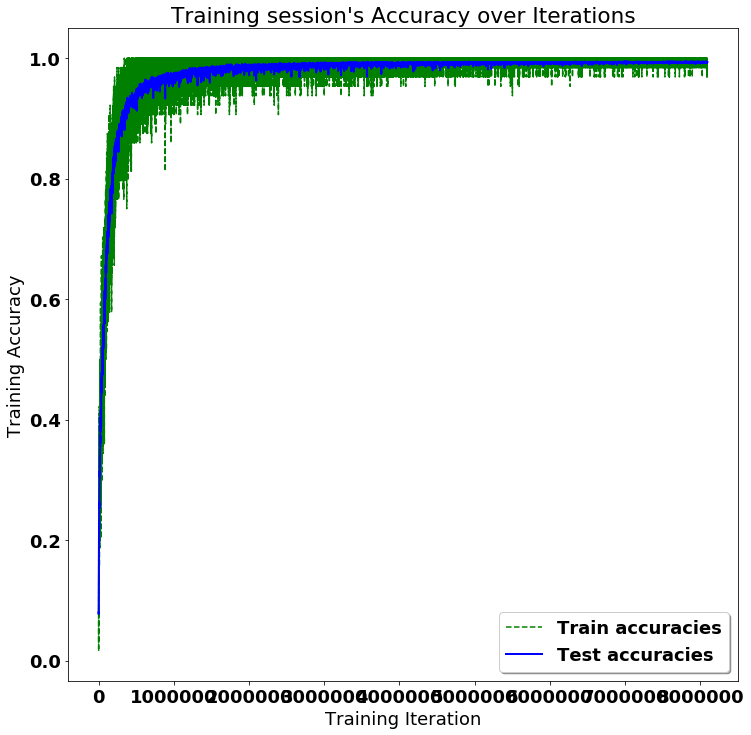

Testing Accuracy: 99.31372404098511%

Precision: 99.31629456355851%
Recall: 99.31372549019608%
f1_score: 99.31376322118636%

Confusion Matrix:
Created using test set of 31620 datapoints, normalised to % of each class in the test dataset


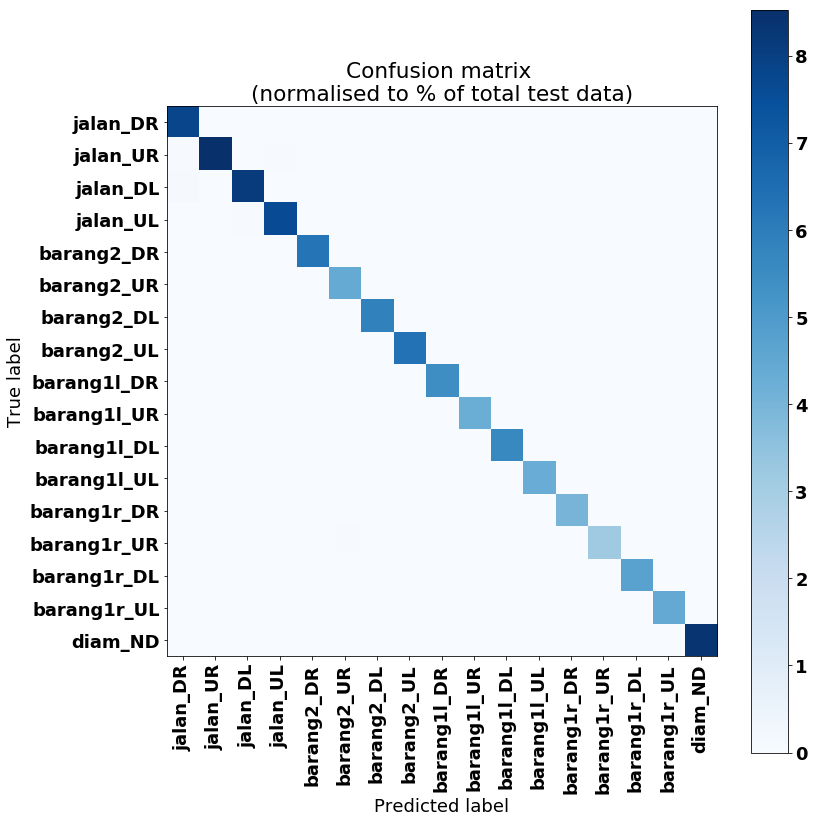

[[2466    2    0    6   10]
 [   0 1726    1    0    1]
 [   0    7 1981    3    1]
 [   0    3    5 1270    0]
 [   0    0    0    0    0]]
Group Testing Accuracy: 99.47874899759422%


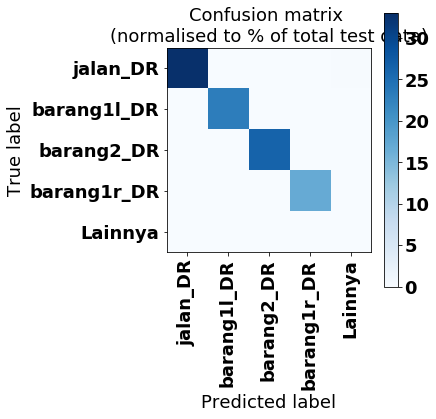

[[2695    0    0    0   35]
 [   0  997   11    0    6]
 [   0    2 1399    0    3]
 [   0    0    4 1356    2]
 [   0    0    0    0    0]]
Group Testing Accuracy: 99.03225806451613%


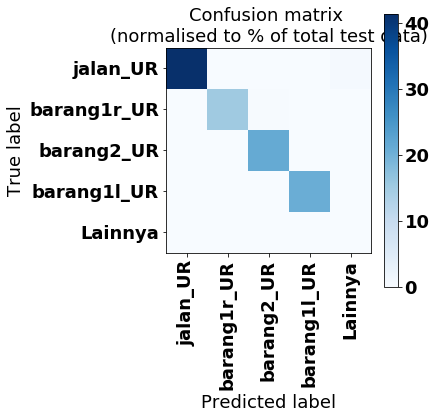

[[2569    8    1    1   31]
 [   0 1777    6    4    1]
 [   0    0 1851    3    6]
 [   0    0    6 1494    0]
 [   0    0    0    0    0]]
Group Testing Accuracy: 99.1363753544728%


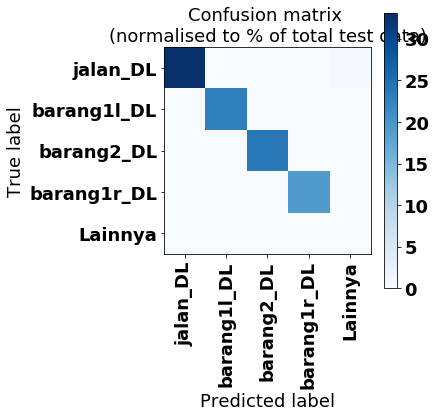

[[1367    0    6    1    0]
 [   5 2404    2    0   13]
 [   0    0 1409    1    0]
 [   6    0    7 2001    2]
 [   0    0    0    0    0]]
Group Testing Accuracy: 99.40476190476191%


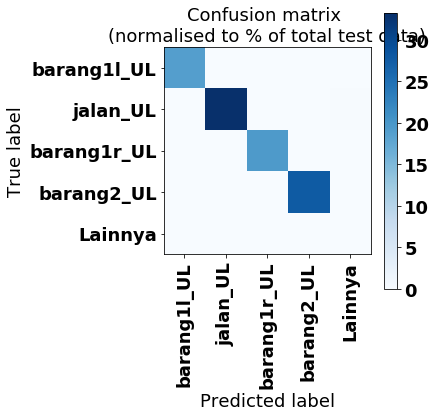

Average Group Testing Accuracy: 99.26303608033626%


In [16]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



# Grouped confusion matrix
LABGRO = [  {0,4,8,12}, 
            {1,5,9,13},  
            {2,6,10,14},  
            {3,7,11,15},  
            {16}]

avg_acc_gr = 0
for gr in range(4):
    y_gr = []
    pred_gr = []

    for y, pred in zip(y_test, predictions):
        s = LABGRO[gr]
        l = list(s)
        # Only get the ones in the same group on both sides
        if y[0] in s:
            # Rearrage the numbers to 0, 1, 2, etc
            y_gr.append(l.index(y[0]))
            if pred in s:
                pred_gr.append(l.index(pred))
            else: # Assign to "Others"
                pred_gr.append(len(l)+1)

    LABGR = LABELS[list(LABGRO[gr])]
    LABGR = np.append(LABGR, "Lainnya")

    confusion_matrix = metrics.confusion_matrix(y_gr, pred_gr)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print(confusion_matrix)

    acc_gr = 0
    for x in range(len(LABGR)):
        acc_gr += confusion_matrix[x,x]
    acc_gr /= sum(sum(confusion_matrix))
    avg_acc_gr += acc_gr
    print("Group Testing Accuracy: {}%".format(acc_gr*100))


    # Plot Results: 
    width = 6
    height = 6
    plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.Blues
    )
    plt.rcParams.update({'axes.titlesize': 'medium'})
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(len(LABGR))
    plt.xticks(tick_marks, LABGR, rotation=90)
    plt.yticks(tick_marks, LABGR)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print("Average Group Testing Accuracy: {}%".format(avg_acc_gr*100/4))

In [17]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [18]:
#sess.close()
print(test_accuracies)

[0.080075905, 0.0771031, 0.096457936, 0.12258065, 0.1598988, 0.17482606, 0.17729285, 0.18649589, 0.20958254, 0.20993042, 0.22517394, 0.19743833, 0.22972801, 0.22292852, 0.21925996, 0.24402277, 0.25613534, 0.26312461, 0.25303605, 0.25534472, 0.25857052, 0.2734029, 0.2966477, 0.293074, 0.3016129, 0.2965528, 0.3050917, 0.31480077, 0.30850726, 0.30487034, 0.30512333, 0.31574953, 0.32074636, 0.33855155, 0.32109424, 0.3252688, 0.33782417, 0.35749525, 0.34316888, 0.35673624, 0.35452247, 0.371284, 0.3730234, 0.36650854, 0.36018342, 0.3831752, 0.3780835, 0.39114484, 0.38061354, 0.40341556, 0.3925996, 0.38912082, 0.39402276, 0.4019924, 0.4084124, 0.41568628, 0.40784314, 0.39376977, 0.3909867, 0.40015814, 0.391809, 0.40180266, 0.40366855, 0.399494, 0.38782415, 0.4160974, 0.42972803, 0.4206515, 0.43706515, 0.43785578, 0.43975332, 0.44857684, 0.45041114, 0.45351043, 0.46208096, 0.46726754, 0.46331435, 0.46815306, 0.47207463, 0.47843137, 0.47628084, 0.45885515, 0.44462365, 0.46438962, 0.4660974, 0.4

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [19]:
# Let's convert this notebook to a README for the GitHub project's title page:
# !jupyter nbconvert --to markdown LSTM.ipynb
# !mv LSTM.md README.md

## 

In [20]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
